In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import nltk
import numpy as np
import pandas as pd
from math import log
import urllib.request
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# amazon = pd.read_csv('/content/drive/My Drive/amazon_reviews.csv')
binary_airline = pd.read_csv('/content/drive/My Drive/binary_air_review.csv')
# binary_hotel = pd.read_csv('/content/drive/My Drive/hotel-reviews.csv')
# clothing = pd.read_csv('/content/drive/My Drive/clothing.csv')
# movie = pd.read_csv('/content/drive/My Drive/train.csv')
# steam = pd.read_csv('/content/drive/My Drive/steam.csv')
# yelp = pd.read_csv('/content/drive/My Drive/yelp.csv')

In [4]:
# sorting = amazon.sort_values(['label'])                     ## contents
sorting = binary_airline.sort_values(['rating'])            ## comment
# sorting = binary_hotel.sort_values(['Is_Response'])         ## Description
# sorting = clothing.sort_values(['Recommended IND'])         ## Review Text
# sorting = movie.sort_values(['sentiment'])                  ## text
# sorting = steam.sort_values(['user_suggestion'])            ## user_review
# sorting = yelp.sort_values(['rating'])                      ## review

In [5]:
sorting

,Unnamed: 0,comment,rating
0,0,Good customer service thejith. Dealing with cu...,0
24897,24897,I have used WallyPark several times with very ...,0
24898,24898,Very happy and pleased with experience at Wall...,0
24899,24899,Will not park anywhere else! Quality of servic...,0
24900,24900,"Quality and service has fallen off, plus ended...",0
...,...,...,...
49776,103536,This was our first and last experience with Wa...,1
49777,103537,Had some really bad experiences: 1) Was LIED t...,1
49778,103538,Excellent service and excellent products! When...,1
49798,103558,Booked 3 rooms and was sent a misleading email...,1


In [6]:
## 본문부분 열 이름과 점수부분 열 이름 입력

contents_name = "comment"
label_name = "rating"

In [7]:
def data_loading(sorting, contents_name, label_name):

  review_ = sorting.reset_index()
  # 라벨 인코더 생성
  encoder = LabelEncoder()

  # X_train데이터를 이용 피팅하고 라벨숫자로 변환한다
  encoder.fit(review_[label_name])
  target_encoded = encoder.transform(review_[label_name])

  contents = list(np.array(review_[contents_name].tolist()))
  label = list(target_encoded)
  cnts_N = contents[:2000]+contents[-2000:]   ## X_train
  label_N = label[:2000]+label[-2000:]        ## y_train

  ## train data를 제외한 test data
  test_dict = {'document':contents[2000:-2000],"label":label[2000:-2000]}
  test_df = pd.DataFrame(test_dict)

  np.random.seed(0)

  df_shuffled=test_df.iloc[np.random.permutation(test_df.index)].reset_index(drop=True)
  df_shuffled

  tdata = df_shuffled['document']
  tlabel = df_shuffled['label']

  return cnts_N, label_N, tdata, tlabel

In [8]:
## train test split과 같이 진행

train_X, train_Y, test_X, test_Y = data_loading(sorting, contents_name, label_name)

In [9]:
def preprocessing(data):

    from nltk import FreqDist
    from nltk.stem.snowball import SnowballStemmer
    snowball = SnowballStemmer('english')

    normalized_text = []  ## 괄호 제거 및 문자이외의 데이터 제거
    for scr in data:
        scr = re.sub('\(', ' ', scr)
        scr = re.sub('\)', ' ', scr)
        scr = re.sub('[^ a-zA-Zㄱ-힗]', '', scr)
        normalized_text.append(scr.lower())

    result = [word_tokenize(sentence) for sentence in normalized_text]  ## 토큰화

    ## 단어 빈도 수 계산( 10번이상 등장하지 않는 단어 stopword에 포함 )
    vocab = list(set(w for i in result for w in i))
    vocab.sort()

    check_freq = []
    for line in result:
        for wd in line:
            check_freq.append(wd)

    fdist = FreqDist(check_freq)

    low_freq = []
    for i in vocab:
        if fdist[i] < 10:
            low_freq.append(i)

    stop_words = set(stopwords.words('english'))
    stop_words = list(stop_words)
    for i in low_freq:
        stop_words.append(i)

    ## stopwords 제거 및 stemming
    except_stopword = []
    for st in result:
        temp = []
        for tk in st:
            if tk not in stop_words:
                temp.append(snowball.stem(tk))
        except_stopword.append(temp)
    
    return except_stopword

In [10]:
## train data 토큰화

train_tokens = preprocessing(train_X)

리뷰의 최대 길이 : 358
리뷰의 평균 길이 : 23.90825


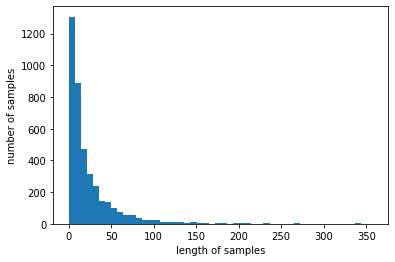

In [11]:
print('리뷰의 최대 길이 :',max(len(l) for l in train_tokens))
print('리뷰의 평균 길이 :',sum(map(len, train_tokens))/len(train_tokens))
plt.hist([len(s) for s in train_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [12]:
vocab = list(set(w for i in train_tokens for w in i ))
vocab.sort()

In [13]:
print('단어의 갯수는 총 %d개 이다'%(len(vocab)))

단어의 갯수는 총 1146개 이다


In [14]:
## 전처리 된 단어들을 다시 문장화

def corpus(tokens):
  corp = []
  for sent in tokens:
    tmp = " ".join(sent)
    corp.append(tmp)

  return corp

train_corp = corpus(train_tokens)

#LIME

In [15]:
!pip install lime

     |████████████████████████████████| 276kB 4.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=141fe3175134d05f065970112d2cbf5b07e15a4c46c0f40daa46094303788a2c
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [16]:
import sklearn
import sklearn.metrics
import sklearn.ensemble
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import lime
import lime.lime_tabular
from lime import lime_text
from lime.lime_text import LimeTextExplainer

from io import StringIO
from __future__ import print_function

TF-IDF vectorizer를 이용해서 vector 화 진행

Logistic Regression을 이용한 classification 모델 학습

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
import operator


vector = TfidfVectorizer(strip_accents='ascii')
tfidf_matrix = vector.fit_transform(train_corp).toarray()

logreg = LogisticRegression()
logreg.fit(tfidf_matrix, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
from lime import lime_text
from sklearn.pipeline import make_pipeline

c = make_pipeline(vector, logreg)

In [19]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(feature_selection='lasso_path' ,verbose = True, class_names=[0,1])

한문장 예시 확인

In [21]:
idx = 150
exp = explainer.explain_instance(train_corp[idx], c.predict_proba, num_features=10)
print('True class: %s' % train_Y[idx])
exp.show_in_notebook(text=True)
exp.as_list()

Intercept 0.375251955254877
Prediction_local [0.25029761]
Right: 0.2562483181362478
True class: 0


[('love', -0.1318035182431108),
 ('websit', 0.05075504817091552),
 ('look', -0.03755684653962876),
 ('everi', -0.03548160347437304),
 ('singl', 0.03401531719319281),
 ('thank', -0.026879658786368506),
 ('book', 0.01895229624879895),
 ('choic', 0.003044616945530586)]

In [22]:
## 한 문장 별로 LIME을 적용하여 단어별 점수를 추출하여 dictionary 형태로 저장

def make_dict(idx, train_corp):
  
  exp = explainer.explain_instance(train_corp[idx], c.predict_proba, num_features=10)
  sent_list = exp.as_list()
  score_dict = {w[0]:w[1] for w in sent_list}

  tmp = sorted(score_dict.items(), key = lambda item: abs(item[1]), reverse=True)
  tdf = pd.DataFrame(tmp).set_index([0])

  return tdf

In [ ]:
## 가장 값아 큰 값을 사전의 값으로 지정하며 업데이트 진행

def build_dict(corp, matrix):
  sent_dict = {}

  threshold = 0.8

  for idx in tqdm(range(len(corp))):
    n_0 = logreg.predict_proba(matrix)[idx][0]
    n_1 = logreg.predict_proba(matrix)[idx][1]
    if (n_0 > threshold) or (n_1 > threshold):

      exp = explainer.explain_instance(corp[idx], c.predict_proba, num_features=10)
      sent_list = exp.as_list()

      for tmp in sent_list:
        if tmp[0] in sent_dict:
          if sent_dict[tmp[0]] < tmp[1]:
            sent_dict[tmp[0]] = tmp[1]
          else :
            None

        else :
          sent_dict[tmp[0]] = tmp[1]
    else :
      None

  return sent_dict

sent_dict = build_dict(train_corp, tfidf_matrix)

  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 1/4000 [00:00<46:48,  1.42it/s]

Intercept 0.2651131866972264
Prediction_local [0.03826943]
Right: 0.06127757835019627


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 3/4000 [00:01<36:41,  1.82it/s]

Intercept 0.595304225089757
Prediction_local [0.8024856]
Right: 0.8066821980871256


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 6/4000 [00:01<28:26,  2.34it/s]

Intercept 0.5821729549673549
Prediction_local [0.86075589]
Right: 0.8436179319616601


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 8/4000 [00:02<24:48,  2.68it/s]

Intercept 0.6335283621546308
Prediction_local [0.87567096]
Right: 0.8607912229453243


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 9/4000 [00:02<25:21,  2.62it/s]

Intercept 0.3029021691755225
Prediction_local [0.05491764]
Right: 0.07895278440378319


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 11/4000 [00:02<22:13,  2.99it/s]

Intercept 0.35190719234465806
Prediction_local [0.11358367]
Right: 0.13603071951457243


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 12/4000 [00:03<24:12,  2.74it/s]

Intercept 0.5875000577058682
Prediction_local [0.85623262]
Right: 0.8326946146831856


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 15/4000 [00:03<19:57,  3.33it/s]

Intercept 0.35602566895585425
Prediction_local [0.17758293]
Right: 0.18486837349929125


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 16/4000 [00:04<23:14,  2.86it/s]

Intercept 0.3845516433274111
Prediction_local [0.09621348]
Right: 0.12273798114877006


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  0%|          | 20/4000 [00:04<18:57,  3.50it/s]

Intercept 0.59483268194351
Prediction_local [0.85060418]
Right: 0.8294372538415866


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 23/4000 [00:05<16:43,  3.96it/s]

Intercept 0.26558779226015305
Prediction_local [0.03351419]
Right: 0.05447694816774299


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 24/4000 [00:05<18:57,  3.50it/s]

Intercept 0.24143421558459283
Prediction_local [0.03143296]
Right: 0.05503421627890172


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 27/4000 [00:06<16:15,  4.07it/s]

Intercept 0.5876426930360865
Prediction_local [0.85682739]
Right: 0.8487132974256946


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 29/4000 [00:06<15:22,  4.30it/s]

Intercept 0.6525160228546266
Prediction_local [0.83960324]
Right: 0.83777480131582


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 30/4000 [00:06<18:54,  3.50it/s]

Intercept 0.35455802767415856
Prediction_local [0.13305727]
Right: 0.15051996458596473


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 34/4000 [00:07<15:29,  4.27it/s]

Intercept 0.36823461021195436
Prediction_local [0.13049902]
Right: 0.1418101327375469


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 35/4000 [00:07<20:31,  3.22it/s]

Intercept 0.22470639327440134
Prediction_local [-0.00019538]
Right: 0.026937657322032783


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 36/4000 [00:08<21:57,  3.01it/s]

Intercept 0.30126310123221434
Prediction_local [0.10881444]
Right: 0.11810127972580353


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 37/4000 [00:08<22:50,  2.89it/s]

Intercept 0.3176087646832577
Prediction_local [0.07140165]
Right: 0.09099411913434957


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 40/4000 [00:09<19:49,  3.33it/s]

Intercept 0.37684330757369794
Prediction_local [0.10461858]
Right: 0.13633593787657383


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 41/4000 [00:09<22:47,  2.90it/s]

Intercept 0.6610214629515551
Prediction_local [0.87113336]
Right: 0.8685488075566339


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 42/4000 [00:10<23:46,  2.78it/s]

Intercept 0.612133181805904
Prediction_local [0.85502217]
Right: 0.8364618911907609


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 43/4000 [00:10<25:52,  2.55it/s]

Intercept 0.39814467891754146
Prediction_local [0.12327238]
Right: 0.14906010057628866


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 44/4000 [00:10<25:58,  2.54it/s]

Intercept 0.621032756371114
Prediction_local [0.88962842]
Right: 0.8711549649352828


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 46/4000 [00:11<22:42,  2.90it/s]

Intercept 0.7409724390872333
Prediction_local [0.97416791]
Right: 0.9558515201997833


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 49/4000 [00:11<19:01,  3.46it/s]

Intercept 0.618313230510948
Prediction_local [0.89305565]
Right: 0.8773014582619512


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|▏         | 50/4000 [00:12<21:13,  3.10it/s]

Intercept 0.5731393455430832
Prediction_local [0.838101]
Right: 0.8136371420367924


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|▏         | 52/4000 [00:12<19:02,  3.45it/s]

Intercept 0.6243371036781137
Prediction_local [0.85445344]
Right: 0.8435981659672857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|▏         | 53/4000 [00:13<21:33,  3.05it/s]

Intercept 0.2661588695139838
Prediction_local [0.05142638]
Right: 0.06629236787761715


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|▏         | 55/4000 [00:13<18:47,  3.50it/s]

Intercept 0.3866790703221711
Prediction_local [0.08595667]
Right: 0.11067880274035091


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|▏         | 56/4000 [00:13<19:31,  3.37it/s]

Intercept 0.2973456071037067
Prediction_local [0.01364756]
Right: 0.046648442077288625


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 60/4000 [00:14<16:09,  4.06it/s]

Intercept 0.3283975014123757
Prediction_local [0.08079911]
Right: 0.10517721058554873


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 62/4000 [00:14<15:05,  4.35it/s]

Intercept 0.3170813235964581
Prediction_local [0.11783242]
Right: 0.13105439744424557


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 63/4000 [00:15<19:45,  3.32it/s]

Intercept 0.20857964518097616
Prediction_local [0.01687181]
Right: 0.03753799349418789


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 65/4000 [00:15<19:03,  3.44it/s]

Intercept 0.39023485911193156
Prediction_local [0.17354515]
Right: 0.18426809072696324


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 67/4000 [00:16<18:40,  3.51it/s]

Intercept 0.758653807797515
Prediction_local [0.98191915]
Right: 0.9610074625859314


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 68/4000 [00:16<22:57,  2.85it/s]

Intercept 0.735983548595701
Prediction_local [0.95713561]
Right: 0.9385438349026092


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 69/4000 [00:17<24:35,  2.66it/s]

Intercept 0.3073491282306995
Prediction_local [0.12283075]
Right: 0.1314041064618129


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 71/4000 [00:17<21:13,  3.08it/s]

Intercept 0.3462140387622079
Prediction_local [0.13867876]
Right: 0.1488146361162933


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 72/4000 [00:18<25:08,  2.60it/s]

Intercept 0.39248574519709695
Prediction_local [0.14111317]
Right: 0.16332596895617846


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 76/4000 [00:18<20:11,  3.24it/s]

Intercept 0.7241459635079649
Prediction_local [0.94349592]
Right: 0.9294344251317666


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 77/4000 [00:19<24:04,  2.72it/s]

Intercept 0.7113587811595392
Prediction_local [0.97273593]
Right: 0.9455929660423892


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 81/4000 [00:19<18:50,  3.47it/s]

Intercept 0.7454928266768994
Prediction_local [0.97142493]
Right: 0.9542954579189898


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 84/4000 [00:19<15:56,  4.09it/s]

Intercept 0.21085479740875843
Prediction_local [0.01125376]
Right: 0.031250920172786856


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 87/4000 [00:20<14:21,  4.54it/s]

Intercept 0.42224391277857354
Prediction_local [0.13270903]
Right: 0.1591242951417051


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 91/4000 [00:21<12:59,  5.01it/s]

Intercept 0.3695237255146908
Prediction_local [0.11664377]
Right: 0.13076946562484076


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 92/4000 [00:21<19:21,  3.36it/s]

Intercept 0.5992914994995092
Prediction_local [0.81152897]
Right: 0.8073461799077453


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 93/4000 [00:22<23:14,  2.80it/s]

Intercept 0.6584359601810632
Prediction_local [0.93920388]
Right: 0.9212512726582336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 95/4000 [00:22<20:04,  3.24it/s]

Intercept 0.4019357440993434
Prediction_local [0.18392945]
Right: 0.19821365254993986


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 97/4000 [00:22<17:48,  3.65it/s]

Intercept 0.33505592707299026
Prediction_local [0.14455416]
Right: 0.15664948011109037


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 99/4000 [00:23<16:50,  3.86it/s]

Intercept 0.31040030472774116
Prediction_local [0.05184721]
Right: 0.08289406309856763


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 101/4000 [00:23<15:16,  4.25it/s]

Intercept 0.5841093920905267
Prediction_local [0.86959545]
Right: 0.8541308778248553


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 103/4000 [00:24<15:55,  4.08it/s]

Intercept 0.19799749911823344
Prediction_local [0.01124478]
Right: 0.031885005930474955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 104/4000 [00:24<20:50,  3.11it/s]

Intercept 0.7451760519866929
Prediction_local [0.97452177]
Right: 0.9526607017330997


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 109/4000 [00:25<16:27,  3.94it/s]

Intercept 0.6111969663629406
Prediction_local [0.84253804]
Right: 0.843999520284629


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 111/4000 [00:25<16:56,  3.82it/s]

Intercept 0.4017183340213498
Prediction_local [0.18617877]
Right: 0.1998061235623799


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 116/4000 [00:26<13:21,  4.85it/s]

Intercept 0.28474538241757974
Prediction_local [0.07040799]
Right: 0.09040256880352582


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 122/4000 [00:26<10:46,  6.00it/s]

Intercept 0.6085515363532344
Prediction_local [0.93579417]
Right: 0.9012635222923043


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 123/4000 [00:27<17:15,  3.74it/s]

Intercept 0.663210850962904
Prediction_local [0.94097564]
Right: 0.9135002091867774


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 124/4000 [00:27<19:22,  3.33it/s]

Intercept 0.28707544339868973
Prediction_local [0.08953847]
Right: 0.09798110026416759


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 125/4000 [00:27<21:00,  3.07it/s]

Intercept 0.3925364932206207
Prediction_local [0.08868226]
Right: 0.11738767284573833


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 129/4000 [00:28<16:50,  3.83it/s]

Intercept 0.6156686470615103
Prediction_local [0.90389074]
Right: 0.8848194328185313


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 130/4000 [00:28<19:21,  3.33it/s]

Intercept 0.36250960221514017
Prediction_local [0.09617256]
Right: 0.11821292135088302


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 132/4000 [00:29<17:35,  3.67it/s]

Intercept 0.4090139033790531
Prediction_local [0.13874602]
Right: 0.15405536053573302


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 134/4000 [00:29<15:59,  4.03it/s]

Intercept 0.2641503759393911
Prediction_local [0.03200477]
Right: 0.049904583982364394


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 136/4000 [00:29<14:54,  4.32it/s]

Intercept 0.6275263303081312
Prediction_local [0.85945582]
Right: 0.8483288721105857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 139/4000 [00:30<14:20,  4.49it/s]

Intercept 0.6805671804059719
Prediction_local [0.94445621]
Right: 0.9203102417729471


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▎         | 141/4000 [00:30<13:58,  4.60it/s]

Intercept 0.6410840270234727
Prediction_local [0.89174871]
Right: 0.8891657708560666


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▎         | 142/4000 [00:31<19:55,  3.23it/s]

Intercept 0.6079435390311376
Prediction_local [0.86375692]
Right: 0.8462539230629399


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▎         | 145/4000 [00:31<16:28,  3.90it/s]

Intercept 0.6269689208147586
Prediction_local [0.90439193]
Right: 0.8800845481950794


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▎         | 146/4000 [00:32<19:12,  3.34it/s]

Intercept 0.7245119976894135
Prediction_local [0.91372584]
Right: 0.9140450257082504


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▎         | 147/4000 [00:32<20:54,  3.07it/s]

Intercept 0.6972057966274227
Prediction_local [0.96709529]
Right: 0.935794057093004


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 150/4000 [00:33<17:58,  3.57it/s]

Intercept 0.2924272590121884
Prediction_local [0.05271475]
Right: 0.0726468457413153


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 153/4000 [00:33<16:14,  3.95it/s]

Intercept 0.6931551772059519
Prediction_local [0.92919252]
Right: 0.9104528011221847


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 154/4000 [00:34<21:19,  3.01it/s]

Intercept 0.6423598832309912
Prediction_local [0.88311622]
Right: 0.8653696029180071


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 156/4000 [00:34<19:18,  3.32it/s]

Intercept 0.6186179783352631
Prediction_local [0.82212373]
Right: 0.8145711747378548


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 159/4000 [00:35<15:59,  4.00it/s]

Intercept 0.5809040141793921
Prediction_local [0.91006501]
Right: 0.8834397453443374


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 160/4000 [00:35<18:24,  3.48it/s]

Intercept 0.23571628586125004
Prediction_local [0.00092766]
Right: 0.029128189375177797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 162/4000 [00:35<16:40,  3.84it/s]

Intercept 0.7448233778832631
Prediction_local [0.97867079]
Right: 0.9542399023752237


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 163/4000 [00:36<20:22,  3.14it/s]

Intercept 0.3727270409533473
Prediction_local [0.13362846]
Right: 0.15780722675380146


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 167/4000 [00:36<16:16,  3.92it/s]

Intercept 0.22559461290598953
Prediction_local [0.00496085]
Right: 0.03230557657032315


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 169/4000 [00:37<15:03,  4.24it/s]

Intercept 0.3707737822110976
Prediction_local [0.17921613]
Right: 0.19182963554715024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 172/4000 [00:37<13:49,  4.61it/s]

Intercept 0.36380163221352835
Prediction_local [0.15458735]
Right: 0.16586148481636614


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 173/4000 [00:37<17:09,  3.72it/s]

Intercept 0.313861913103298
Prediction_local [0.13451005]
Right: 0.14265520194297812


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 182/4000 [00:38<11:32,  5.52it/s]

Intercept 0.8082824382977865
Prediction_local [0.98730332]
Right: 0.9682743764332853


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 186/4000 [00:38<10:04,  6.31it/s]

Intercept 0.5974846321597121
Prediction_local [0.87738689]
Right: 0.8538906087891298


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 190/4000 [00:39<09:49,  6.46it/s]

Intercept 0.6207619580519016
Prediction_local [0.89906844]
Right: 0.8743797050725527


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 193/4000 [00:39<09:45,  6.51it/s]

Intercept 0.6080152044763817
Prediction_local [0.84905469]
Right: 0.8346443503859091


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 195/4000 [00:40<11:02,  5.74it/s]

Intercept 0.6505162194589874
Prediction_local [0.89680684]
Right: 0.8797170534794423


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.36083645799699154
Prediction_local [0.1630295]
Right: 0.1671735218026012


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▍         | 197/4000 [00:41<16:51,  3.76it/s]

Intercept 0.7008313439496103
Prediction_local [0.93596856]
Right: 0.927032516463464


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 203/4000 [00:41<13:15,  4.77it/s]

Intercept 0.3770763805535899
Prediction_local [0.15696536]
Right: 0.16137340319677726


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 206/4000 [00:42<11:55,  5.30it/s]

Intercept 0.7356997216570019
Prediction_local [0.99422458]
Right: 0.9615134372431058


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 209/4000 [00:42<11:17,  5.59it/s]

Intercept 0.6624107026190218
Prediction_local [0.9505319]
Right: 0.9207075772511278


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 211/4000 [00:43<12:41,  4.97it/s]

Intercept 0.6238779241108359
Prediction_local [0.92495541]
Right: 0.9027286096006982


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 212/4000 [00:43<16:10,  3.90it/s]

Intercept 0.34471476198597906
Prediction_local [0.15195961]
Right: 0.16226313520756866


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 214/4000 [00:43<14:40,  4.30it/s]

Intercept 0.6461828445851322
Prediction_local [0.95290076]
Right: 0.9246218156846435


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 216/4000 [00:44<14:14,  4.43it/s]

Intercept 0.7069402216416412
Prediction_local [0.95501531]
Right: 0.9308662569545799


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  5%|▌         | 218/4000 [00:44<14:50,  4.25it/s]

Intercept 0.6060253822375842
Prediction_local [0.86534959]
Right: 0.8427472201981236


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 220/4000 [00:45<14:16,  4.41it/s]

Intercept 0.6520068713435263
Prediction_local [0.89644565]
Right: 0.8755313514817535


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 221/4000 [00:45<18:19,  3.44it/s]

Intercept 0.6196546003384737
Prediction_local [0.90801252]
Right: 0.8760554840420248


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 222/4000 [00:46<19:40,  3.20it/s]

Intercept 0.37154924919891785
Prediction_local [0.11141987]
Right: 0.1310311529149871


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 223/4000 [00:46<20:38,  3.05it/s]

Intercept 0.29455924453510657
Prediction_local [0.05680525]
Right: 0.07665660076098244


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 224/4000 [00:46<22:04,  2.85it/s]

Intercept 0.33512291452789333
Prediction_local [0.16314243]
Right: 0.16586883335157962


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 225/4000 [00:47<23:23,  2.69it/s]

Intercept 0.4145667143484149
Prediction_local [0.13283185]
Right: 0.16142931370008828


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 226/4000 [00:47<24:19,  2.59it/s]

Intercept 0.18938038115578928
Prediction_local [0.0255375]
Right: 0.04179822249232155


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 232/4000 [00:48<18:23,  3.41it/s]

Intercept 0.4515351579576713
Prediction_local [0.16464212]
Right: 0.19945077055668553


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 235/4000 [00:48<16:15,  3.86it/s]

Intercept 0.7185299882108062
Prediction_local [0.96598108]
Right: 0.941097950196449


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 238/4000 [00:49<13:47,  4.54it/s]

Intercept 0.3960877228469719
Prediction_local [0.16599937]
Right: 0.1679166493663411


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 239/4000 [00:49<17:09,  3.65it/s]

Intercept 0.6730676456900557
Prediction_local [0.92721437]
Right: 0.9101932026435982


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 240/4000 [00:49<19:24,  3.23it/s]

Intercept 0.608137737345624
Prediction_local [0.8956978]
Right: 0.8781063816781968


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 241/4000 [00:50<19:41,  3.18it/s]

Intercept 0.21576689381298475
Prediction_local [-0.00876159]
Right: 0.020836691200285376


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 244/4000 [00:50<16:39,  3.76it/s]

Intercept 0.32469134562907875
Prediction_local [0.14415051]
Right: 0.15313707454660105


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 248/4000 [00:51<13:47,  4.53it/s]

Intercept 0.7633817075877926
Prediction_local [0.98478567]
Right: 0.9600877747386086


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▌         | 249/4000 [00:51<18:49,  3.32it/s]

Intercept 0.39772646640863873
Prediction_local [0.12412948]
Right: 0.14332405764936057


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  6%|▋         | 254/4000 [00:52<15:06,  4.13it/s]

Intercept 0.6038556588687478
Prediction_local [0.86219356]
Right: 0.8386326636166797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 261/4000 [00:52<14:02,  4.44it/s]

Intercept 0.16798862953144064
Prediction_local [0.00986269]
Right: 0.025951699428241052


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5829869472291199
Prediction_local [0.83716608]
Right: 0.8367932951700503


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 264/4000 [00:53<15:32,  4.01it/s]

Intercept 0.6912550176770769
Prediction_local [0.90551696]
Right: 0.9007948752835395


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 266/4000 [00:54<15:58,  3.89it/s]

Intercept 0.564769592110375
Prediction_local [0.85701603]
Right: 0.8278058606481024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 268/4000 [00:54<16:04,  3.87it/s]

Intercept 0.33494369942888286
Prediction_local [0.07807788]
Right: 0.10008212154986533


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 270/4000 [00:55<16:13,  3.83it/s]

Intercept 0.7160112116515724
Prediction_local [0.93776385]
Right: 0.9218485808275778


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 275/4000 [00:55<13:02,  4.76it/s]

Intercept 0.6577019457683014
Prediction_local [0.93173763]
Right: 0.9074586879657449


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 276/4000 [00:56<16:25,  3.78it/s]

Intercept 0.6760014675503655
Prediction_local [0.86526927]
Right: 0.8663627498376776


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 277/4000 [00:56<21:31,  2.88it/s]

Intercept 0.5274510321470741
Prediction_local [0.87187151]
Right: 0.8310247990014109


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 280/4000 [00:57<17:44,  3.49it/s]

Intercept 0.35719294374013455
Prediction_local [0.17278626]
Right: 0.1862505606740758


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 282/4000 [00:57<16:26,  3.77it/s]

Intercept 0.7736036250548466
Prediction_local [0.97548506]
Right: 0.9559385926502816


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 284/4000 [00:57<15:14,  4.06it/s]

Intercept 0.30907835792498384
Prediction_local [0.08552704]
Right: 0.0994885877792326


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 286/4000 [00:58<14:29,  4.27it/s]

Intercept 0.23303123650231677
Prediction_local [-0.00799584]
Right: 0.02544883551325056


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 287/4000 [00:58<18:45,  3.30it/s]

Intercept 0.373677916629073
Prediction_local [0.13031613]
Right: 0.15313181078936808


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 288/4000 [00:59<20:38,  3.00it/s]

Intercept 0.6072497316040273
Prediction_local [0.87158227]
Right: 0.8490830912767398


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 293/4000 [00:59<16:03,  3.85it/s]

Intercept 0.836801022926462
Prediction_local [0.99867538]
Right: 0.9801250855080063


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 295/4000 [01:00<14:53,  4.15it/s]

Intercept 0.35208942140663446
Prediction_local [0.10552489]
Right: 0.12242731281531874


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 296/4000 [01:00<17:26,  3.54it/s]

Intercept 0.575359079490122
Prediction_local [0.80812103]
Right: 0.8005132510029099


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  7%|▋         | 297/4000 [01:00<18:48,  3.28it/s]

Intercept 0.7520281449857256
Prediction_local [0.96732138]
Right: 0.9484846934963067


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 301/4000 [01:01<15:04,  4.09it/s]

Intercept 0.5988922269657715
Prediction_local [0.84044931]
Right: 0.8353090419261227


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 304/4000 [01:01<12:44,  4.83it/s]

Intercept 0.5509100602103423
Prediction_local [0.84363461]
Right: 0.8347643531527109


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 305/4000 [01:02<17:17,  3.56it/s]

Intercept 0.6677915913520112
Prediction_local [0.97437406]
Right: 0.9434021436338632


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 308/4000 [01:02<15:14,  4.04it/s]

Intercept 0.6007741557814779
Prediction_local [0.88743971]
Right: 0.8617524139228359


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 309/4000 [01:02<18:53,  3.26it/s]

Intercept 0.6760157571879333
Prediction_local [0.89025612]
Right: 0.884252974729857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 310/4000 [01:03<21:10,  2.90it/s]

Intercept 0.630442841968885
Prediction_local [0.91351282]
Right: 0.8847902627464013


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 313/4000 [01:03<17:20,  3.54it/s]

Intercept 0.34980964277373905
Prediction_local [0.14465905]
Right: 0.14950672715805693


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 316/4000 [01:04<15:22,  3.99it/s]

Intercept 0.21826934384397567
Prediction_local [0.00861984]
Right: 0.03195002359301935


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 318/4000 [01:04<15:33,  3.94it/s]

Intercept 0.5460034931513222
Prediction_local [0.84329105]
Right: 0.8104564497904565


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 319/4000 [01:05<18:15,  3.36it/s]

Intercept 0.2156368466524062
Prediction_local [-0.00971489]
Right: 0.022364446614526585


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 320/4000 [01:05<21:44,  2.82it/s]

Intercept 0.6430206231461344
Prediction_local [0.9071111]
Right: 0.8826265573084904


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 321/4000 [01:06<24:17,  2.52it/s]

Intercept 0.380567666157835
Prediction_local [0.17657111]
Right: 0.19329772096656603


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 324/4000 [01:06<19:32,  3.13it/s]

Intercept 0.6087308623294747
Prediction_local [0.82923872]
Right: 0.8211808447857163


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 325/4000 [01:07<23:41,  2.58it/s]

Intercept 0.7096243678439322
Prediction_local [0.93729305]
Right: 0.9188054255108816


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 328/4000 [01:07<19:20,  3.16it/s]

Intercept 0.6527599669458926
Prediction_local [0.94475542]
Right: 0.9158513085694874


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 330/4000 [01:08<17:31,  3.49it/s]

Intercept 0.6797828598521398
Prediction_local [0.91240762]
Right: 0.8961021001406626


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 332/4000 [01:08<15:39,  3.90it/s]

Intercept 0.3572902304302699
Prediction_local [0.19428657]
Right: 0.19958874489735312


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 338/4000 [01:08<12:17,  4.96it/s]

Intercept 0.8165443470666718
Prediction_local [0.99262377]
Right: 0.9729727893744103


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  8%|▊         | 339/4000 [01:09<15:28,  3.94it/s]

Intercept 0.2827848850551343
Prediction_local [0.07262163]
Right: 0.08591566095490867


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 341/4000 [01:09<16:02,  3.80it/s]

Intercept 0.29126216832774027
Prediction_local [0.07283562]
Right: 0.08974026892283415


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 342/4000 [01:10<20:20,  3.00it/s]

Intercept 0.41937466733182566
Prediction_local [0.14654317]
Right: 0.17421924219460372


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 343/4000 [01:10<22:53,  2.66it/s]

Intercept 0.6585966798214431
Prediction_local [0.94517654]
Right: 0.9219632017930854


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 345/4000 [01:11<20:48,  2.93it/s]

Intercept 0.3309082859800926
Prediction_local [0.15194002]
Right: 0.15738480634464144


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 347/4000 [01:11<19:37,  3.10it/s]

Intercept 0.344015113998116
Prediction_local [0.19995769]
Right: 0.19353104996919457


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 348/4000 [01:12<20:34,  2.96it/s]

Intercept 0.5355703731687409
Prediction_local [0.84237436]
Right: 0.8073696357392033


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▊         | 349/4000 [01:12<20:55,  2.91it/s]

Intercept 0.31820531520840667
Prediction_local [0.05216431]
Right: 0.07457851634750377


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 350/4000 [01:13<23:50,  2.55it/s]

Intercept 0.3341196681384708
Prediction_local [0.05971786]
Right: 0.09150017030180962


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 353/4000 [01:13<19:39,  3.09it/s]

Intercept 0.3520294125858746
Prediction_local [0.12540597]
Right: 0.1413098996288536


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 356/4000 [01:14<16:46,  3.62it/s]

Intercept 0.37832088177998496
Prediction_local [0.1462948]
Right: 0.1702246319187797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 361/4000 [01:14<13:37,  4.45it/s]

Intercept 0.3051661492125727
Prediction_local [0.09215063]
Right: 0.10726239588283802


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 363/4000 [01:15<13:44,  4.41it/s]

Intercept 0.24899179282535272
Prediction_local [0.00817185]
Right: 0.03850155111032028


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 364/4000 [01:15<17:31,  3.46it/s]

Intercept 0.6087898933775491
Prediction_local [0.89646648]
Right: 0.8717186150679687


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 365/4000 [01:15<20:31,  2.95it/s]

Intercept 0.30998395826538183
Prediction_local [0.04504352]
Right: 0.07705684620200087


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 369/4000 [01:16<16:57,  3.57it/s]

Intercept 0.5653860109018924
Prediction_local [0.90204189]
Right: 0.8647503148431966


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 371/4000 [01:17<17:00,  3.56it/s]

Intercept 0.2774547036381778
Prediction_local [0.05050681]
Right: 0.07447419634215897


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 373/4000 [01:17<17:24,  3.47it/s]

Intercept 0.6742392486469568
Prediction_local [0.94525321]
Right: 0.9229330386580024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 375/4000 [01:18<17:25,  3.47it/s]

Intercept 0.3957761094907245
Prediction_local [0.17281679]
Right: 0.19092509527877288


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 378/4000 [01:18<14:30,  4.16it/s]

Intercept 0.7572648086520705
Prediction_local [0.99128901]
Right: 0.9617742176809332


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  9%|▉         | 379/4000 [01:19<19:21,  3.12it/s]

Intercept 0.3711235307760694
Prediction_local [0.11880205]
Right: 0.13860980824311334


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 383/4000 [01:19<15:28,  3.90it/s]

Intercept 0.7280147591391612
Prediction_local [0.97881697]
Right: 0.9536142483516186


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 384/4000 [01:20<20:09,  2.99it/s]

Intercept 0.7095136032099185
Prediction_local [0.95341574]
Right: 0.9304341681433413


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 385/4000 [01:20<21:05,  2.86it/s]

Intercept 0.7353045245417213
Prediction_local [0.95279147]
Right: 0.9352632944975314


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 387/4000 [01:21<19:20,  3.11it/s]

Intercept 0.40835283506671305
Prediction_local [0.13921031]
Right: 0.16447737244252983


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 388/4000 [01:21<20:30,  2.94it/s]

Intercept 0.33739625182444494
Prediction_local [0.1490673]
Right: 0.15920834132132394


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 390/4000 [01:21<18:33,  3.24it/s]

Intercept 0.8208528059746258
Prediction_local [1.00177048]
Right: 0.9798408199293346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 391/4000 [01:22<19:03,  3.16it/s]

Intercept 0.2566349688943703
Prediction_local [0.06638464]
Right: 0.08030513718093754


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 393/4000 [01:22<17:08,  3.51it/s]

Intercept 0.3108443760265329
Prediction_local [0.13206722]
Right: 0.1433607146609752


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 394/4000 [01:23<19:01,  3.16it/s]

Intercept 0.6300172089747365
Prediction_local [0.85892861]
Right: 0.8471440515187835


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|▉         | 397/4000 [01:23<16:31,  3.63it/s]

Intercept 0.3776473986172107
Prediction_local [0.12266321]
Right: 0.1524702562051695


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 400/4000 [01:24<14:37,  4.10it/s]

Intercept 0.7634063707579758
Prediction_local [0.9886591]
Right: 0.9642514464889853


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 401/4000 [01:24<19:44,  3.04it/s]

Intercept 0.22606221548040012
Prediction_local [0.03428691]
Right: 0.05260446093783024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 402/4000 [01:24<20:10,  2.97it/s]

Intercept 0.7632160318268791
Prediction_local [1.00293598]
Right: 0.9736503274165388


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 403/4000 [01:25<20:11,  2.97it/s]

Intercept 0.6100881330244351
Prediction_local [0.85724048]
Right: 0.8437635608079792


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 404/4000 [01:25<22:51,  2.62it/s]

Intercept 0.40438010817860515
Prediction_local [0.15411704]
Right: 0.17989442892160734


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 406/4000 [01:26<19:45,  3.03it/s]

Intercept 0.3255914967667541
Prediction_local [0.08758235]
Right: 0.1049419815175104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 408/4000 [01:26<17:33,  3.41it/s]

Intercept 0.3917205304402618
Prediction_local [0.17959695]
Right: 0.1975984364198811


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 410/4000 [01:27<16:23,  3.65it/s]

Intercept 0.6181675803337319
Prediction_local [0.88698189]
Right: 0.8631951472529961


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 412/4000 [01:27<15:45,  3.80it/s]

Intercept 0.3536613362126223
Prediction_local [0.09017461]
Right: 0.1146026487432119


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 413/4000 [01:28<20:51,  2.87it/s]

Intercept 0.5508810223836716
Prediction_local [0.8683984]
Right: 0.8368542165390821


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 415/4000 [01:28<18:11,  3.29it/s]

Intercept 0.7453340136521669
Prediction_local [0.95199673]
Right: 0.940269521674346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 10%|█         | 416/4000 [01:29<22:19,  2.68it/s]

Intercept 0.5748353618659348
Prediction_local [0.89399883]
Right: 0.8578400671015918


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 421/4000 [01:29<17:06,  3.49it/s]

Intercept 0.6357501629820188
Prediction_local [0.8623763]
Right: 0.8561132917696335


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 422/4000 [01:29<20:23,  2.92it/s]

Intercept 0.3666114641682927
Prediction_local [0.16909667]
Right: 0.18347603548258548


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 423/4000 [01:30<22:54,  2.60it/s]

Intercept 0.25061138768728713
Prediction_local [0.03569315]
Right: 0.05902814284683973


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 425/4000 [01:30<20:07,  2.96it/s]

Intercept 0.23059472099265726
Prediction_local [-0.00040235]
Right: 0.029533680463490662


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 426/4000 [01:31<22:42,  2.62it/s]

Intercept 0.6141709189388369
Prediction_local [0.90313772]
Right: 0.8802665696641256


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 427/4000 [01:31<24:50,  2.40it/s]

Intercept 0.32451602564646087
Prediction_local [0.07605082]
Right: 0.10023917283599372


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 431/4000 [01:32<19:05,  3.12it/s]

Intercept 0.7437975995806954
Prediction_local [0.9732069]
Right: 0.9512325003164254


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 432/4000 [01:32<21:41,  2.74it/s]

Intercept 0.6111749716142006
Prediction_local [0.8918872]
Right: 0.8639183786632566


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 433/4000 [01:33<23:38,  2.51it/s]

Intercept 0.5859881419911062
Prediction_local [0.86071718]
Right: 0.8397368021651709


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 434/4000 [01:33<24:30,  2.43it/s]

Intercept 0.1785255961771275
Prediction_local [0.00608981]
Right: 0.027029187543431282


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 435/4000 [01:33<23:21,  2.54it/s]

Intercept 0.3111275815960508
Prediction_local [0.08032478]
Right: 0.09392827797307626


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 440/4000 [01:34<17:43,  3.35it/s]

Intercept 0.20990165918279696
Prediction_local [-0.00860151]
Right: 0.021487580630355683


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 441/4000 [01:34<18:56,  3.13it/s]

Intercept 0.21865002166751873
Prediction_local [0.02427187]
Right: 0.04276992913872721


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 442/4000 [01:35<23:10,  2.56it/s]

Intercept 0.6110989269641482
Prediction_local [0.86270661]
Right: 0.8409233449940057


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 444/4000 [01:35<21:09,  2.80it/s]

Intercept 0.20690573633787546
Prediction_local [0.03287571]
Right: 0.047456739668499816


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 446/4000 [01:36<18:35,  3.19it/s]

Intercept 0.33936838054528196
Prediction_local [0.1327814]
Right: 0.1478822598686619


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█         | 447/4000 [01:36<20:26,  2.90it/s]

Intercept 0.2390948819214776
Prediction_local [0.04081303]
Right: 0.05859972790930881


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█▏        | 452/4000 [01:37<16:19,  3.62it/s]

Intercept 0.5979688742807123
Prediction_local [0.86540258]
Right: 0.8540198469164942


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█▏        | 453/4000 [01:37<19:28,  3.04it/s]

Intercept 0.23920518539397734
Prediction_local [0.01648698]
Right: 0.03904213591683112


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█▏        | 455/4000 [01:38<17:17,  3.42it/s]

Intercept 0.37764413943026726
Prediction_local [0.15343285]
Right: 0.1715536642137165


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█▏        | 457/4000 [01:38<16:56,  3.49it/s]

Intercept 0.3487674849510225
Prediction_local [0.09163565]
Right: 0.11868322967235444


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 11%|█▏        | 459/4000 [01:39<15:33,  3.79it/s]

Intercept 0.2851808510766377
Prediction_local [0.07468334]
Right: 0.09077937887918638


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 460/4000 [01:39<17:45,  3.32it/s]

Intercept 0.2682505202871507
Prediction_local [0.0391597]
Right: 0.054613614777084575


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 461/4000 [01:40<21:28,  2.75it/s]

Intercept 0.7005141224800048
Prediction_local [0.98389997]
Right: 0.9527485026130522


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 463/4000 [01:40<18:47,  3.14it/s]

Intercept 0.6249264366123497
Prediction_local [0.88184623]
Right: 0.8593348483676934


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 464/4000 [01:40<20:31,  2.87it/s]

Intercept 0.6146808944229267
Prediction_local [0.89506785]
Right: 0.872126975230359


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 467/4000 [01:41<16:48,  3.50it/s]

Intercept 0.7273446635907448
Prediction_local [0.97106436]
Right: 0.9463341574289665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 468/4000 [01:41<19:03,  3.09it/s]

Intercept 0.3027227289691883
Prediction_local [0.02385281]
Right: 0.04204655552703317


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 470/4000 [01:42<17:58,  3.27it/s]

Intercept 0.4081733011289657
Prediction_local [0.17469531]
Right: 0.18854540227327618


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 473/4000 [01:42<14:45,  3.98it/s]

Intercept 0.16633223959668877
Prediction_local [0.00660145]
Right: 0.02630617321208097


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 474/4000 [01:43<17:55,  3.28it/s]

Intercept 0.370391022181479
Prediction_local [0.13268729]
Right: 0.15554196526114739


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 476/4000 [01:43<17:03,  3.44it/s]

Intercept 0.6824988415127242
Prediction_local [0.92468685]
Right: 0.9073017669174039


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 478/4000 [01:43<15:19,  3.83it/s]

Intercept 0.13973189186044066
Prediction_local [-0.01567831]
Right: 0.008045325973605603


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 480/4000 [01:44<14:51,  3.95it/s]

Intercept 0.2979221319813653
Prediction_local [0.07118941]
Right: 0.0939243808524847


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 482/4000 [01:44<15:13,  3.85it/s]

Intercept 0.7259598060766514
Prediction_local [0.95858416]
Right: 0.9378064322084104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 484/4000 [01:45<14:58,  3.91it/s]

Intercept 0.6472176916788093
Prediction_local [0.92391237]
Right: 0.8980519696730609


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 486/4000 [01:45<14:13,  4.12it/s]

Intercept 0.6558474089934876
Prediction_local [0.93209998]
Right: 0.9043011739821046


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 487/4000 [01:46<16:01,  3.66it/s]

Intercept 0.11559244941391346
Prediction_local [-0.01040781]
Right: 0.009452747505857846


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 488/4000 [01:46<20:16,  2.89it/s]

Intercept 0.32517001118060135
Prediction_local [0.05809698]
Right: 0.08508870992998806


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 489/4000 [01:47<20:23,  2.87it/s]

Intercept 0.7114097740135618
Prediction_local [0.93217899]
Right: 0.915651677464664


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 491/4000 [01:47<18:26,  3.17it/s]

Intercept 0.3685607105206532
Prediction_local [0.18510266]
Right: 0.18158999929430564


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 496/4000 [01:48<14:41,  3.98it/s]

Intercept 0.23828690491104798
Prediction_local [0.04166712]
Right: 0.059600997649195804


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 497/4000 [01:48<18:54,  3.09it/s]

Intercept 0.5558832716532116
Prediction_local [0.84860985]
Right: 0.8207250416266547


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 12%|█▏        | 499/4000 [01:49<17:55,  3.25it/s]

Intercept 0.660905850627479
Prediction_local [0.9560105]
Right: 0.9241206158768781


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 505/4000 [01:49<14:23,  4.05it/s]

Intercept 0.37870479384998784
Prediction_local [0.14883651]
Right: 0.17290811348731336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 507/4000 [01:50<14:25,  4.03it/s]

Intercept 0.5697377395960934
Prediction_local [0.90182057]
Right: 0.8617706627227207


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 508/4000 [01:50<17:25,  3.34it/s]

Intercept 0.644042414550794
Prediction_local [0.93811514]
Right: 0.9080311556632381


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 510/4000 [01:51<16:22,  3.55it/s]

Intercept 0.5961395710802309
Prediction_local [0.90009373]
Right: 0.8769591309080784


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 511/4000 [01:51<19:24,  3.00it/s]

Intercept 0.7900311488832353
Prediction_local [0.96565359]
Right: 0.9528905908046229


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 512/4000 [01:51<20:37,  2.82it/s]

Intercept 0.654734882162562
Prediction_local [0.95709325]
Right: 0.9193509582716023


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 517/4000 [01:52<16:19,  3.56it/s]

Intercept 0.5735675943057517
Prediction_local [0.87846044]
Right: 0.8453485278341114


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 519/4000 [01:52<14:43,  3.94it/s]

Intercept 0.6927046357460791
Prediction_local [0.99922229]
Right: 0.973825495653803


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 522/4000 [01:53<12:49,  4.52it/s]

Intercept 0.40047077036880296
Prediction_local [0.17118191]
Right: 0.1849664985228514


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 524/4000 [01:53<12:59,  4.46it/s]

Intercept 0.38379574845167796
Prediction_local [0.06097328]
Right: 0.09782121473761245


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 525/4000 [01:54<17:12,  3.36it/s]

Intercept 0.4084525724514492
Prediction_local [0.16559003]
Right: 0.18467460338627592


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 527/4000 [01:54<15:27,  3.75it/s]

Intercept 0.592206529430693
Prediction_local [0.76163769]
Right: 0.8160024976584321


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 528/4000 [01:55<19:13,  3.01it/s]

Intercept 0.30489340543072846
Prediction_local [0.1585847]
Right: 0.16387319614080098


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 531/4000 [01:55<15:52,  3.64it/s]

Intercept 0.6857210992870283
Prediction_local [0.92074032]
Right: 0.9053345106496858


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 532/4000 [01:56<20:04,  2.88it/s]

Intercept 0.5412566776990597
Prediction_local [0.88379627]
Right: 0.8684653817250826


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 533/4000 [01:56<22:14,  2.60it/s]

Intercept 0.33134870230700103
Prediction_local [0.02642875]
Right: 0.06398224083045746


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 13%|█▎        | 536/4000 [01:57<18:33,  3.11it/s]

Intercept 0.38182149129382237
Prediction_local [0.15035986]
Right: 0.17047376575203096


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▎        | 540/4000 [01:57<15:23,  3.74it/s]

Intercept 0.3428438518849959
Prediction_local [0.09536618]
Right: 0.11691151670742794


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▎        | 542/4000 [01:58<14:46,  3.90it/s]

Intercept 0.29996150555672485
Prediction_local [0.07952756]
Right: 0.10026829797731975


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▎        | 546/4000 [01:58<12:21,  4.66it/s]

Intercept 0.30683019266104605
Prediction_local [0.07841192]
Right: 0.09470224983615738


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▎        | 547/4000 [01:58<15:12,  3.78it/s]

Intercept 0.6520542370614705
Prediction_local [0.92327342]
Right: 0.8952200071192845


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▎        | 549/4000 [01:59<13:48,  4.16it/s]

Intercept 0.19687918826055206
Prediction_local [0.00534767]
Right: 0.02520131812133297


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 553/4000 [01:59<11:17,  5.09it/s]

Intercept 0.6013206950907408
Prediction_local [0.84719148]
Right: 0.8327224361020209


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 559/4000 [02:00<09:07,  6.28it/s]

Intercept 0.3523660869638343
Prediction_local [0.10731384]
Right: 0.1276904521050933


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 566/4000 [02:00<07:55,  7.22it/s]

Intercept 0.7199566172113631
Prediction_local [0.97385804]
Right: 0.9473306700452353


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 571/4000 [02:01<07:22,  7.76it/s]

Intercept 0.25462322969474704
Prediction_local [0.02001518]
Right: 0.04712738081688365


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 572/4000 [02:01<13:33,  4.21it/s]

Intercept 0.3950767780662486
Prediction_local [0.15990986]
Right: 0.18185572434822697


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 573/4000 [02:02<16:06,  3.54it/s]

Intercept 0.8198912069507556
Prediction_local [1.0094951]
Right: 0.9832381288797822


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 575/4000 [02:02<15:25,  3.70it/s]

Intercept 0.2943895376069698
Prediction_local [0.05192252]
Right: 0.07711882952656142


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 577/4000 [02:03<14:03,  4.06it/s]

Intercept 0.6156213237681278
Prediction_local [0.7990107]
Right: 0.8005328276075632


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 14%|█▍        | 580/4000 [02:03<12:11,  4.67it/s]

Intercept 0.5567765507651106
Prediction_local [0.83247465]
Right: 0.8307306942205175


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 583/4000 [02:04<11:40,  4.88it/s]

Intercept 0.6849811427613333
Prediction_local [0.93789127]
Right: 0.9162639228244353


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 584/4000 [02:04<15:42,  3.63it/s]

Intercept 0.3632971916281876
Prediction_local [0.16479874]
Right: 0.17976541414214015


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 585/4000 [02:04<19:30,  2.92it/s]

Intercept 0.6606718685427082
Prediction_local [0.90284501]
Right: 0.8855924855478297


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 586/4000 [02:05<22:48,  2.49it/s]

Intercept 0.6135082355911952
Prediction_local [0.89466513]
Right: 0.8724807261756768


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 587/4000 [02:05<23:45,  2.39it/s]

Intercept 0.2847771483203278
Prediction_local [0.08298575]
Right: 0.0946264741237461


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 589/4000 [02:06<20:23,  2.79it/s]

Intercept 0.6135000040892578
Prediction_local [0.87501704]
Right: 0.8579651718820448


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 591/4000 [02:06<18:11,  3.12it/s]

Intercept 0.3439286941880978
Prediction_local [0.18733948]
Right: 0.1837401700211544


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 592/4000 [02:07<19:30,  2.91it/s]

Intercept 0.6121284292355417
Prediction_local [0.88641908]
Right: 0.8650254025421883


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 593/4000 [02:07<19:53,  2.85it/s]

Intercept 0.24000088480351062
Prediction_local [0.05707207]
Right: 0.0748114466080149


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 596/4000 [02:08<17:00,  3.33it/s]

Intercept 0.5779527926985699
Prediction_local [0.85776963]
Right: 0.8329613077479265


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▍        | 599/4000 [02:08<14:13,  3.98it/s]

Intercept 0.720727804107929
Prediction_local [0.93645054]
Right: 0.9197039812357737


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 600/4000 [02:08<16:08,  3.51it/s]

Intercept 0.8572348448207711
Prediction_local [1.00672678]
Right: 0.9860190840239639


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 603/4000 [02:09<13:34,  4.17it/s]

Intercept 0.39950827675168554
Prediction_local [0.15593289]
Right: 0.15543466134322628


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 604/4000 [02:09<18:27,  3.07it/s]

Intercept 0.3795419571820899
Prediction_local [0.11422127]
Right: 0.14286253784413938


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 606/4000 [02:10<17:15,  3.28it/s]

Intercept 0.6539487888016005
Prediction_local [0.93335972]
Right: 0.9083361529583409


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 607/4000 [02:10<19:38,  2.88it/s]

Intercept 0.6150060374868889
Prediction_local [0.89514641]
Right: 0.8758115237155616


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 608/4000 [02:11<20:22,  2.77it/s]

Intercept 0.6625879750636342
Prediction_local [0.93126109]
Right: 0.9176480453073742


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 611/4000 [02:11<17:03,  3.31it/s]

Intercept 0.5743209194710397
Prediction_local [0.87396753]
Right: 0.8445546190500853


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 612/4000 [02:12<18:51,  2.99it/s]

Intercept 0.36342911692225355
Prediction_local [0.14722142]
Right: 0.14833599134240127


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 614/4000 [02:12<17:06,  3.30it/s]

Intercept 0.37058347137361025
Prediction_local [0.16745633]
Right: 0.17792020912091444


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 15%|█▌        | 619/4000 [02:13<13:30,  4.17it/s]

Intercept 0.757927468397783
Prediction_local [0.98052881]
Right: 0.9586505138183762


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 621/4000 [02:13<13:38,  4.13it/s]

Intercept 0.3629748464979238
Prediction_local [0.15960141]
Right: 0.17325871159735554


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 628/4000 [02:14<10:48,  5.20it/s]

Intercept 0.6462440976824373
Prediction_local [0.85537693]
Right: 0.8550916491373775


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 629/4000 [02:14<15:46,  3.56it/s]

Intercept 0.667400564094222
Prediction_local [0.90396325]
Right: 0.8854920938443211


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 630/4000 [02:14<17:35,  3.19it/s]

Intercept 0.4030081899564544
Prediction_local [0.15352146]
Right: 0.16960168855833352


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 631/4000 [02:15<19:28,  2.88it/s]

Intercept 0.6368477900101875
Prediction_local [0.89077304]
Right: 0.8740189781791876


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 633/4000 [02:15<17:24,  3.22it/s]

Intercept 0.6214198480622124
Prediction_local [0.83327111]
Right: 0.8272130887867513


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 635/4000 [02:16<15:48,  3.55it/s]

Intercept 0.6750585853965182
Prediction_local [0.96124153]
Right: 0.928304814164707


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 637/4000 [02:16<14:27,  3.88it/s]

Intercept 0.7616099838286521
Prediction_local [0.98853699]
Right: 0.9643403763018036


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 638/4000 [02:17<18:40,  3.00it/s]

Intercept 0.7505357921336746
Prediction_local [0.95898436]
Right: 0.9429915254012653


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 639/4000 [02:17<19:18,  2.90it/s]

Intercept 0.6887261125626218
Prediction_local [0.92606528]
Right: 0.903294546710524


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 641/4000 [02:18<18:10,  3.08it/s]

Intercept 0.26300907254488803
Prediction_local [0.04683996]
Right: 0.0667637883142194


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 645/4000 [02:18<14:20,  3.90it/s]

Intercept 0.6553594066398065
Prediction_local [0.89798157]
Right: 0.87870056504549


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 646/4000 [02:18<18:13,  3.07it/s]

Intercept 0.6876494531272002
Prediction_local [0.94358416]
Right: 0.9189256231072424


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▌        | 648/4000 [02:19<16:29,  3.39it/s]

Intercept 0.35837292537193116
Prediction_local [0.14675712]
Right: 0.16310028237767663


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 650/4000 [02:19<16:03,  3.48it/s]

Intercept 0.42958749177703026
Prediction_local [0.15890664]
Right: 0.1923328307981666


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 652/4000 [02:20<14:12,  3.93it/s]

Intercept 0.35314725898937577
Prediction_local [0.17694689]
Right: 0.18544879806470135


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 655/4000 [02:20<12:56,  4.31it/s]

Intercept 0.22716825056870726
Prediction_local [0.00792488]
Right: 0.030009330651272557


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 656/4000 [02:21<17:41,  3.15it/s]

Intercept 0.3079142639499065
Prediction_local [0.06697178]
Right: 0.09280539390862019


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 657/4000 [02:21<20:01,  2.78it/s]

Intercept 0.7129074667213744
Prediction_local [0.97016189]
Right: 0.9448212344702026


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 16%|█▋        | 660/4000 [02:22<16:06,  3.46it/s]

Intercept 0.25089884984812005
Prediction_local [0.05778675]
Right: 0.0708509892347094


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 661/4000 [02:22<16:51,  3.30it/s]

Intercept 0.3163668001006855
Prediction_local [0.07166671]
Right: 0.0894793597271009


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 662/4000 [02:23<19:43,  2.82it/s]

Intercept 0.6750595491126171
Prediction_local [0.92533847]
Right: 0.9105529308352488


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 663/4000 [02:23<21:40,  2.57it/s]

Intercept 0.43499849598126716
Prediction_local [0.16770967]
Right: 0.19131016121853375


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 664/4000 [02:23<20:36,  2.70it/s]

Intercept 0.7471062544598636
Prediction_local [1.01577246]
Right: 0.9838757816807894


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 666/4000 [02:24<17:59,  3.09it/s]

Intercept 0.5920511888879507
Prediction_local [0.84779879]
Right: 0.8293880763838134


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 667/4000 [02:24<20:45,  2.68it/s]

Intercept 0.5744474544149355
Prediction_local [0.8195077]
Right: 0.8087694952814747


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 669/4000 [02:25<17:57,  3.09it/s]

Intercept 0.6070683524564866
Prediction_local [0.81371]
Right: 0.8081855730943484


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 670/4000 [02:25<19:22,  2.86it/s]

Intercept 0.6807841414854325
Prediction_local [0.94838521]
Right: 0.9234792105888048


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 672/4000 [02:25<17:02,  3.26it/s]

Intercept 0.4365629821651218
Prediction_local [0.11026053]
Right: 0.14694701129962887


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 674/4000 [02:26<16:22,  3.38it/s]

Intercept 0.598589102599226
Prediction_local [0.90382718]
Right: 0.8762445725245723


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 676/4000 [02:26<15:02,  3.68it/s]

Intercept 0.5949760833448976
Prediction_local [0.88915531]
Right: 0.8593058400719014


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 678/4000 [02:27<13:41,  4.04it/s]

Intercept 0.6255269987170591
Prediction_local [0.92141193]
Right: 0.90462040315973


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 679/4000 [02:27<16:21,  3.38it/s]

Intercept 0.34886261964236714
Prediction_local [0.10706085]
Right: 0.11977535280822196


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 680/4000 [02:28<19:25,  2.85it/s]

Intercept 0.2626344118004511
Prediction_local [0.06217565]
Right: 0.0800430865654843


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 682/4000 [02:28<16:53,  3.27it/s]

Intercept 0.3116487416832746
Prediction_local [0.07767117]
Right: 0.09031738591502188


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 684/4000 [02:29<15:53,  3.48it/s]

Intercept 0.7006026014030079
Prediction_local [0.87964228]
Right: 0.8633548680503261


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 687/4000 [02:29<13:56,  3.96it/s]

Intercept 0.5898145052114452
Prediction_local [0.85591691]
Right: 0.8347174064500266


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 692/4000 [02:30<11:14,  4.91it/s]

Intercept 0.3241576520207653
Prediction_local [0.11790638]
Right: 0.1347858890595123


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 694/4000 [02:30<12:06,  4.55it/s]

Intercept 0.7093281353595965
Prediction_local [0.93420322]
Right: 0.9170961778970075


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 695/4000 [02:31<16:01,  3.44it/s]

Intercept 0.21596717684198802
Prediction_local [0.02553386]
Right: 0.04323812271958186


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 17%|█▋        | 696/4000 [02:31<17:44,  3.10it/s]

Intercept 0.567771341797026
Prediction_local [0.83465748]
Right: 0.8234864396938213


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 701/4000 [02:32<14:21,  3.83it/s]

Intercept 0.34914602607869527
Prediction_local [0.16481104]
Right: 0.17339563338970365


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 702/4000 [02:32<16:50,  3.26it/s]

Intercept 0.40680739753269235
Prediction_local [0.19429379]
Right: 0.19863621552981098


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 703/4000 [02:32<18:01,  3.05it/s]

Intercept 0.5382747699787293
Prediction_local [0.89073605]
Right: 0.869866857722716


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 708/4000 [02:33<14:28,  3.79it/s]

Intercept 0.38765453667756866
Prediction_local [0.14026034]
Right: 0.15897305662672245


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 709/4000 [02:33<16:55,  3.24it/s]

Intercept 0.6208230066171867
Prediction_local [0.90670683]
Right: 0.8772558458621837


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 711/4000 [02:34<16:04,  3.41it/s]

Intercept 0.8063908101132177
Prediction_local [0.97868387]
Right: 0.9644738452915756


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 712/4000 [02:34<18:04,  3.03it/s]

Intercept 0.642511240957776
Prediction_local [0.89384435]
Right: 0.8776563400358871


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 716/4000 [02:35<14:58,  3.65it/s]

Intercept 0.6678633600645242
Prediction_local [0.92059501]
Right: 0.9049253221402492


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 717/4000 [02:35<19:18,  2.83it/s]

Intercept 0.17197203553944906
Prediction_local [0.01738381]
Right: 0.032528087963394674


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 718/4000 [02:36<22:07,  2.47it/s]

Intercept 0.31115075588037855
Prediction_local [0.04871011]
Right: 0.07649289142736382


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 720/4000 [02:36<19:01,  2.87it/s]

Intercept 0.39701411974869105
Prediction_local [0.16832474]
Right: 0.18331670344518114


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 723/4000 [02:37<15:43,  3.47it/s]

Intercept 0.6184239346138483
Prediction_local [0.872118]
Right: 0.8547516289698279


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 729/4000 [02:37<12:12,  4.46it/s]

Intercept 0.17756727319259216
Prediction_local [0.00848172]
Right: 0.02811594490007655


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 734/4000 [02:38<10:29,  5.19it/s]

Intercept 0.6437088360597882
Prediction_local [0.96314222]
Right: 0.9295643001464132


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 737/4000 [02:38<09:43,  5.59it/s]

Intercept 0.4116226326878436
Prediction_local [0.14136754]
Right: 0.1707007509117447


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 738/4000 [02:39<15:35,  3.49it/s]

Intercept 0.5064237203773897
Prediction_local [0.83820454]
Right: 0.801684961910214


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 18%|█▊        | 739/4000 [02:39<20:17,  2.68it/s]

Intercept 0.8182907340055947
Prediction_local [0.99005386]
Right: 0.9739020615368044


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▊        | 741/4000 [02:40<17:23,  3.12it/s]

Intercept 0.33452568106858516
Prediction_local [0.10673834]
Right: 0.1238921093291061


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▊        | 742/4000 [02:40<18:37,  2.92it/s]

Intercept 0.6859329651538647
Prediction_local [0.94533285]
Right: 0.9253605754429676


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▊        | 744/4000 [02:41<17:43,  3.06it/s]

Intercept 0.6179856453549681
Prediction_local [0.87960531]
Right: 0.8611577246371991


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▊        | 746/4000 [02:41<15:30,  3.50it/s]

Intercept 0.7135525816494948
Prediction_local [0.94031762]
Right: 0.9232065645024069


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 750/4000 [02:42<12:49,  4.22it/s]

Intercept 0.34510373706163244
Prediction_local [0.13722167]
Right: 0.1457950677679377


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 754/4000 [02:42<10:46,  5.02it/s]

Intercept 0.6233297659018328
Prediction_local [0.86848842]
Right: 0.8500832849940955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 758/4000 [02:42<09:14,  5.85it/s]

Intercept 0.7739459873875889
Prediction_local [0.98375457]
Right: 0.9614753499244557


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 765/4000 [02:43<07:28,  7.21it/s]

Intercept 0.5778173757855574
Prediction_local [0.82464516]
Right: 0.8138900993762489


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 766/4000 [02:43<13:05,  4.12it/s]

Intercept 0.5902453160248021
Prediction_local [0.8765516]
Right: 0.8498526963617349


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 769/4000 [02:44<12:18,  4.38it/s]

Intercept 0.5628684994008188
Prediction_local [0.83981772]
Right: 0.8150526036945047


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 775/4000 [02:44<09:50,  5.46it/s]

Intercept 0.3637780201873301
Prediction_local [0.0824495]
Right: 0.11596965288779809


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 776/4000 [02:45<14:17,  3.76it/s]

Intercept 0.4295982014451917
Prediction_local [0.16383452]
Right: 0.18711999159820655


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 19%|█▉        | 778/4000 [02:45<13:17,  4.04it/s]

Intercept 0.63385593910834
Prediction_local [0.88904045]
Right: 0.8695700760607336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 781/4000 [02:46<12:17,  4.37it/s]

Intercept 0.563292634905223
Prediction_local [0.90027431]
Right: 0.8649005601202208


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 786/4000 [02:46<09:51,  5.43it/s]

Intercept 0.5852909417749665
Prediction_local [0.87852106]
Right: 0.8477869799297362


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 787/4000 [02:47<12:43,  4.21it/s]

Intercept 0.7013057397374461
Prediction_local [0.96288531]
Right: 0.9474203815445776


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 793/4000 [02:47<10:05,  5.29it/s]

Intercept 0.6051513596989531
Prediction_local [0.89826549]
Right: 0.8854006412485803


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 794/4000 [02:47<13:20,  4.01it/s]

Intercept 0.663714050819
Prediction_local [0.94297111]
Right: 0.9255621184301933


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|█▉        | 797/4000 [02:48<11:09,  4.78it/s]

Intercept 0.2348427107849528
Prediction_local [0.03487912]
Right: 0.06266519762295819


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 803/4000 [02:48<09:33,  5.57it/s]

Intercept 0.6777884780108084
Prediction_local [0.9267097]
Right: 0.9089172870318524


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 805/4000 [02:49<10:44,  4.96it/s]

Intercept 0.33162325178751645
Prediction_local [0.09060866]
Right: 0.11582501471164569


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 810/4000 [02:49<09:10,  5.79it/s]

Intercept 0.353348155112886
Prediction_local [0.079784]
Right: 0.11117894794296898


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 815/4000 [02:50<08:01,  6.61it/s]

Intercept 0.23480515405481572
Prediction_local [0.01119457]
Right: 0.03754837505019359


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 816/4000 [02:50<12:39,  4.19it/s]

Intercept 0.31424948189532786
Prediction_local [0.04302752]
Right: 0.07206831813200315


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 817/4000 [02:51<16:17,  3.26it/s]

Intercept 0.4065000221441832
Prediction_local [0.14912424]
Right: 0.17745607412086506


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 20%|██        | 819/4000 [02:51<15:14,  3.48it/s]

Intercept 0.5835608557654497
Prediction_local [0.87576297]
Right: 0.8499692755498532


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 822/4000 [02:52<13:25,  3.94it/s]

Intercept 0.7278310073637159
Prediction_local [0.95809236]
Right: 0.9367513564493566


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 823/4000 [02:52<15:04,  3.51it/s]

Intercept 0.7493483875812463
Prediction_local [0.95527386]
Right: 0.9378871304097147


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 824/4000 [02:53<16:24,  3.22it/s]

Intercept 0.6406339981886888
Prediction_local [0.88656342]
Right: 0.8686644947394535


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 827/4000 [02:53<13:44,  3.85it/s]

Intercept 0.39659694964634296
Prediction_local [0.12138362]
Right: 0.14385176712579173


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 828/4000 [02:53<15:59,  3.31it/s]

Intercept 0.3285691027189791
Prediction_local [0.10919267]
Right: 0.1219026424416926


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 830/4000 [02:54<14:43,  3.59it/s]

Intercept 0.6455917557902895
Prediction_local [0.87692114]
Right: 0.8695304456178666


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 831/4000 [02:54<18:45,  2.82it/s]

Intercept 0.6142221798367351
Prediction_local [0.86010224]
Right: 0.8475055346835433


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 835/4000 [02:55<14:37,  3.61it/s]

Intercept 0.3946702412723163
Prediction_local [0.11580062]
Right: 0.12364053733273425


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 837/4000 [02:55<14:20,  3.68it/s]

Intercept 0.6398657055074367
Prediction_local [0.93813403]
Right: 0.9077079170497244


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 842/4000 [02:56<11:36,  4.53it/s]

Intercept 0.7273153889601982
Prediction_local [0.95961522]
Right: 0.9365057728811179


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 843/4000 [02:56<14:58,  3.51it/s]

Intercept 0.33948698120910475
Prediction_local [0.195049]
Right: 0.19341591557589255


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 846/4000 [02:57<12:25,  4.23it/s]

Intercept 0.6001401558983848
Prediction_local [0.82755511]
Right: 0.8142549634172851


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██        | 848/4000 [02:57<12:23,  4.24it/s]

Intercept 0.667707137526991
Prediction_local [0.97019493]
Right: 0.947696399630251


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██▏       | 851/4000 [02:57<10:39,  4.92it/s]

Intercept 0.25422225994436415
Prediction_local [0.00457076]
Right: 0.032986120663471535


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 21%|██▏       | 857/4000 [02:58<09:05,  5.77it/s]

Intercept 0.6380417222402839
Prediction_local [0.87629082]
Right: 0.8628062546663269


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 863/4000 [02:59<07:46,  6.73it/s]

Intercept 0.2980103415242371
Prediction_local [0.01863872]
Right: 0.0526950766614932


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 865/4000 [02:59<09:03,  5.77it/s]

Intercept 0.32124693294094825
Prediction_local [0.11195604]
Right: 0.12821380370618438


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 866/4000 [03:00<12:41,  4.12it/s]

Intercept 0.28480013919267083
Prediction_local [0.05365115]
Right: 0.07033621259737248


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 867/4000 [03:00<16:46,  3.11it/s]

Intercept 0.632781744342592
Prediction_local [0.86471596]
Right: 0.8502272068374326


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 875/4000 [03:01<12:36,  4.13it/s]

Intercept 0.34863287489127226
Prediction_local [0.11461336]
Right: 0.13127083876725384


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6245072049818848
Prediction_local [0.84622599]
Right: 0.841262854228439


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 878/4000 [03:01<13:51,  3.75it/s]

Intercept 0.39115270696591875
Prediction_local [0.17705947]
Right: 0.19591286337651498


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 880/4000 [03:02<12:52,  4.04it/s]

Intercept 0.4130733510615644
Prediction_local [0.10261832]
Right: 0.13290360396365286


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 882/4000 [03:02<12:52,  4.04it/s]

Intercept 0.6594379813886182
Prediction_local [0.92025651]
Right: 0.8999290069022449


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.31907475706877286
Prediction_local [0.05632075]
Right: 0.07853016520878614


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 884/4000 [03:03<16:10,  3.21it/s]

Intercept 0.2318309981420167
Prediction_local [0.01753793]
Right: 0.03906681546707748


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 885/4000 [03:04<17:19,  3.00it/s]

Intercept 0.6030327433786058
Prediction_local [0.87698975]
Right: 0.8635842887392594


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 886/4000 [03:04<17:27,  2.97it/s]

Intercept 0.6481112197121863
Prediction_local [0.92728699]
Right: 0.908709087681198


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 890/4000 [03:05<14:04,  3.68it/s]

Intercept 0.29033127838751854
Prediction_local [0.04952585]
Right: 0.07413981808019171


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 891/4000 [03:05<17:13,  3.01it/s]

Intercept 0.3056210757202298
Prediction_local [0.07509283]
Right: 0.08524207476545212


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 892/4000 [03:05<18:07,  2.86it/s]

Intercept 0.6439321932905705
Prediction_local [0.89443672]
Right: 0.8769573430991303


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 893/4000 [03:06<19:30,  2.65it/s]

Intercept 0.4275485475782663
Prediction_local [0.13617953]
Right: 0.17560935021953883


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 894/4000 [03:06<18:40,  2.77it/s]

Intercept 0.35953598222158767
Prediction_local [-0.01017444]
Right: 0.037666175937360914


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 896/4000 [03:07<17:05,  3.03it/s]

Intercept 0.5903680097726766
Prediction_local [0.84532519]
Right: 0.8252986502390008


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 897/4000 [03:07<17:48,  2.90it/s]

Intercept 0.33647608195272793
Prediction_local [0.12752311]
Right: 0.14145808728235248


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 22%|██▏       | 899/4000 [03:08<16:48,  3.08it/s]

Intercept 0.257402614779712
Prediction_local [0.04286257]
Right: 0.06329365254041118


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 903/4000 [03:08<13:52,  3.72it/s]

Intercept 0.5557879741955549
Prediction_local [0.83607828]
Right: 0.8104700776902148


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 905/4000 [03:09<13:58,  3.69it/s]

Intercept 0.6376171475103494
Prediction_local [0.85665107]
Right: 0.8541972260423321


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 912/4000 [03:09<11:49,  4.35it/s]

Intercept 0.6225622791877059
Prediction_local [0.84589958]
Right: 0.8356518196938644


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 914/4000 [03:10<11:10,  4.60it/s]

Intercept 0.27349697412497465
Prediction_local [0.07113614]
Right: 0.0775053645943992


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 916/4000 [03:10<11:42,  4.39it/s]

Intercept 0.640478278011172
Prediction_local [0.85867706]
Right: 0.8459444760438983


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 918/4000 [03:11<12:16,  4.19it/s]

Intercept 0.6547982746825332
Prediction_local [0.94883438]
Right: 0.9195889410130147


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 919/4000 [03:11<14:07,  3.64it/s]

Intercept 0.7228764376936851
Prediction_local [0.99457636]
Right: 0.9635564886631767


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 921/4000 [03:11<12:47,  4.01it/s]

Intercept 0.692582026422964
Prediction_local [0.9707998]
Right: 0.9337986738796091


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 922/4000 [03:12<16:31,  3.10it/s]

Intercept 0.5784880981941525
Prediction_local [0.86951344]
Right: 0.8441724658741947


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 923/4000 [03:12<18:27,  2.78it/s]

Intercept 0.6222055943063821
Prediction_local [0.88874463]
Right: 0.8690373534467959


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 925/4000 [03:13<16:45,  3.06it/s]

Intercept 0.3710323573831863
Prediction_local [0.08816788]
Right: 0.12089750538522157


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 930/4000 [03:13<12:58,  3.94it/s]

Intercept 0.2573871717679931
Prediction_local [0.06546835]
Right: 0.08044131066585436


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 934/4000 [03:14<11:13,  4.55it/s]

Intercept 0.7405528798892531
Prediction_local [0.96187191]
Right: 0.9429474453749279


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 936/4000 [03:14<11:36,  4.40it/s]

Intercept 0.6123391991781519
Prediction_local [0.81881653]
Right: 0.8143869339997494


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 937/4000 [03:15<13:48,  3.70it/s]

Intercept 0.2821803730090241
Prediction_local [0.07792922]
Right: 0.08850317493124212


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 23%|██▎       | 939/4000 [03:15<12:21,  4.13it/s]

Intercept 0.6265473166354548
Prediction_local [0.92680621]
Right: 0.9060162346426278


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▎       | 942/4000 [03:15<10:40,  4.77it/s]

Intercept 0.5886704986638407
Prediction_local [0.87785918]
Right: 0.8544366174316266


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▎       | 943/4000 [03:16<16:04,  3.17it/s]

Intercept 0.39709233919068365
Prediction_local [0.09895134]
Right: 0.1350962903027564


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▎       | 945/4000 [03:17<15:42,  3.24it/s]

Intercept 0.5866256071044564
Prediction_local [0.81940396]
Right: 0.8088046610309781


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▎       | 946/4000 [03:17<18:39,  2.73it/s]

Intercept 0.3911352310124393
Prediction_local [0.1436612]
Right: 0.17374670197764602


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▎       | 948/4000 [03:18<16:24,  3.10it/s]

Intercept 0.5639718098206323
Prediction_local [0.8506665]
Right: 0.8265341831071428


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 951/4000 [03:18<13:51,  3.67it/s]

Intercept 0.702677028605093
Prediction_local [0.93699196]
Right: 0.9207460747469781


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 953/4000 [03:18<12:42,  4.00it/s]

Intercept 0.3057038631033294
Prediction_local [0.09487185]
Right: 0.11100430437768785


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 954/4000 [03:19<14:24,  3.52it/s]

Intercept 0.3374553211738557
Prediction_local [0.04077426]
Right: 0.05674226869616007


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 955/4000 [03:19<15:16,  3.32it/s]

Intercept 0.2282607012996112
Prediction_local [0.000779]
Right: 0.028791800452632427


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 957/4000 [03:20<14:37,  3.47it/s]

Intercept 0.5936874550160097
Prediction_local [0.8640028]
Right: 0.8456128789921994


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 958/4000 [03:20<15:56,  3.18it/s]

Intercept 0.6257435457268176
Prediction_local [0.85670942]
Right: 0.8485320349824544


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 966/4000 [03:20<12:12,  4.14it/s]

Intercept 0.22420863804210683
Prediction_local [0.03549027]
Right: 0.05143698997683203


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 969/4000 [03:21<11:07,  4.54it/s]

Intercept 0.5964975107963983
Prediction_local [0.86783265]
Right: 0.8438800359871242


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6864046363867928
Prediction_local [0.96656315]
Right: 0.9381861472567089


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 971/4000 [03:22<14:27,  3.49it/s]

Intercept 0.32776190602938293
Prediction_local [0.07672711]
Right: 0.10322832109997565


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 973/4000 [03:22<13:58,  3.61it/s]

Intercept 0.7345026114406603
Prediction_local [0.97910472]
Right: 0.9535662138329986


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 976/4000 [03:23<12:14,  4.12it/s]

Intercept 0.16225540646851572
Prediction_local [0.00758914]
Right: 0.024543924718295997


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 24%|██▍       | 980/4000 [03:23<10:45,  4.68it/s]

Intercept 0.30419117049115624
Prediction_local [0.05920285]
Right: 0.08293937055211631


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 983/4000 [03:24<09:55,  5.07it/s]

Intercept 0.3546216361618565
Prediction_local [0.15192033]
Right: 0.1720811886588281


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 986/4000 [03:24<09:17,  5.41it/s]

Intercept 0.3191000257868745
Prediction_local [0.09027248]
Right: 0.10845575741685719


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 988/4000 [03:25<10:18,  4.87it/s]

Intercept 0.6543201698623045
Prediction_local [0.92814761]
Right: 0.9017900763128871


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 992/4000 [03:25<09:06,  5.50it/s]

Intercept 0.59757406303172
Prediction_local [0.88424591]
Right: 0.8582187550636089


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 993/4000 [03:26<14:06,  3.55it/s]

Intercept 0.3884394872001876
Prediction_local [0.12106674]
Right: 0.15193069996633052


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▍       | 994/4000 [03:26<16:20,  3.07it/s]

Intercept 0.6412736830318956
Prediction_local [0.83833532]
Right: 0.8256278866731788


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1000/4000 [03:27<12:46,  3.92it/s]

Intercept 0.7031314181162494
Prediction_local [0.96950845]
Right: 0.945435946868661


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1001/4000 [03:27<14:19,  3.49it/s]

Intercept 0.6633462533771847
Prediction_local [0.91594364]
Right: 0.8950471398542588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1002/4000 [03:28<16:33,  3.02it/s]

Intercept 0.6057464183475386
Prediction_local [0.83369408]
Right: 0.8326893751088771


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1003/4000 [03:28<17:30,  2.85it/s]

Intercept 0.6716790850440033
Prediction_local [0.95876009]
Right: 0.932432791167011


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1008/4000 [03:29<13:32,  3.68it/s]

Intercept 0.6193109851622628
Prediction_local [0.92481295]
Right: 0.901227741117757


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1011/4000 [03:29<12:02,  4.14it/s]

Intercept 0.35038635464681744
Prediction_local [0.17484488]
Right: 0.1788481875960652


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1014/4000 [03:30<10:52,  4.58it/s]

Intercept 0.6122523910115186
Prediction_local [0.9042985]
Right: 0.8742667104161309


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 25%|██▌       | 1017/4000 [03:30<09:43,  5.11it/s]

Intercept 0.3541711260770809
Prediction_local [0.13886413]
Right: 0.1474295564149531


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1022/4000 [03:30<07:57,  6.24it/s]

Intercept 0.4060556710336476
Prediction_local [0.1224978]
Right: 0.12091878023024988


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1025/4000 [03:31<08:13,  6.03it/s]

Intercept 0.5851339997348247
Prediction_local [0.83343677]
Right: 0.8188399287064361


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1026/4000 [03:31<13:08,  3.77it/s]

Intercept 0.2839916676010294
Prediction_local [0.03864804]
Right: 0.06524941545378679


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1027/4000 [03:32<15:07,  3.27it/s]

Intercept 0.4109272793310219
Prediction_local [0.12987962]
Right: 0.16316672651005965


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1029/4000 [03:32<14:17,  3.47it/s]

Intercept 0.5581423073500064
Prediction_local [0.83916324]
Right: 0.8151604994351703


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1031/4000 [03:33<14:02,  3.53it/s]

Intercept 0.5642475135139741
Prediction_local [0.87300433]
Right: 0.8383738811413798


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1032/4000 [03:33<17:37,  2.81it/s]

Intercept 0.3870383340493306
Prediction_local [0.15576227]
Right: 0.1812782287880873


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1035/4000 [03:34<14:16,  3.46it/s]

Intercept 0.2638756865511266
Prediction_local [0.05049941]
Right: 0.06493641510978759


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1036/4000 [03:34<17:31,  2.82it/s]

Intercept 0.6009933130838696
Prediction_local [0.82837276]
Right: 0.8223180985324278


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1037/4000 [03:35<19:53,  2.48it/s]

Intercept 0.3622126550309649
Prediction_local [0.07023731]
Right: 0.10246727129851443


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1039/4000 [03:35<16:34,  2.98it/s]

Intercept 0.6242547229991782
Prediction_local [0.8452826]
Right: 0.8425234553498306


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1041/4000 [03:36<15:20,  3.21it/s]

Intercept 0.2511069311011563
Prediction_local [0.03404088]
Right: 0.0567445725328718


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1043/4000 [03:36<13:36,  3.62it/s]

Intercept 0.28839361117819706
Prediction_local [0.05960132]
Right: 0.07562491783910454


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1044/4000 [03:37<17:22,  2.84it/s]

Intercept 0.7852211520534764
Prediction_local [0.97838843]
Right: 0.9608700137801807


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▌       | 1049/4000 [03:37<13:36,  3.62it/s]

Intercept 0.3619010162138211
Prediction_local [0.11770618]
Right: 0.14355274078335403


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▋       | 1050/4000 [03:37<15:40,  3.14it/s]

Intercept 0.6569093978131296
Prediction_local [0.9200279]
Right: 0.9114431477266999


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▋       | 1051/4000 [03:38<18:09,  2.71it/s]

Intercept 0.7686562624841379
Prediction_local [0.979638]
Right: 0.9586965092204253


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▋       | 1052/4000 [03:38<18:19,  2.68it/s]

Intercept 0.25755463716141713
Prediction_local [0.09009843]
Right: 0.09472807612632225


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▋       | 1054/4000 [03:39<16:02,  3.06it/s]

Intercept 0.268928461576525
Prediction_local [0.05809254]
Right: 0.0623056906694677


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 26%|██▋       | 1059/4000 [03:39<12:37,  3.88it/s]

Intercept 0.6850584009000562
Prediction_local [0.93429954]
Right: 0.9161712978020453


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1062/4000 [03:40<11:10,  4.38it/s]

Intercept 0.6139983382890771
Prediction_local [0.89261148]
Right: 0.8648719715253163


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1063/4000 [03:40<14:23,  3.40it/s]

Intercept 0.3309107479885426
Prediction_local [0.11315878]
Right: 0.13347141924951014


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1068/4000 [03:41<11:18,  4.32it/s]

Intercept 0.6475937134445124
Prediction_local [0.90055979]
Right: 0.882483794566879


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1069/4000 [03:41<14:58,  3.26it/s]

Intercept 0.3848415504881737
Prediction_local [0.18222681]
Right: 0.19988001145013695


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1070/4000 [03:42<17:45,  2.75it/s]

Intercept 0.6128368801119656
Prediction_local [0.86356313]
Right: 0.8481796240726021


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1071/4000 [03:42<20:01,  2.44it/s]

Intercept 0.666392341953352
Prediction_local [0.90533715]
Right: 0.8894284254136031


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1072/4000 [03:43<20:11,  2.42it/s]

Intercept 0.30188058685469665
Prediction_local [0.07683241]
Right: 0.1010692284916445


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1074/4000 [03:43<17:36,  2.77it/s]

Intercept 0.5976411160369558
Prediction_local [0.89925409]
Right: 0.8677515041763618


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1077/4000 [03:43<14:38,  3.33it/s]

Intercept 0.6642928926898286
Prediction_local [0.93653539]
Right: 0.9082936034929333


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1082/4000 [03:44<11:46,  4.13it/s]

Intercept 0.3556484567452307
Prediction_local [0.18250703]
Right: 0.1848197475099116


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1086/4000 [03:44<09:57,  4.87it/s]

Intercept 0.43149873895666147
Prediction_local [0.14687387]
Right: 0.17047680821495032


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1089/4000 [03:45<09:47,  4.96it/s]

Intercept 0.6083823614546419
Prediction_local [0.85924342]
Right: 0.8463251777229862


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1093/4000 [03:46<08:37,  5.62it/s]

Intercept 0.36579367750352687
Prediction_local [0.13973933]
Right: 0.15710431929781113


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1096/4000 [03:46<07:53,  6.13it/s]

Intercept 0.6352310757389243
Prediction_local [0.84316652]
Right: 0.8345876278681644


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1098/4000 [03:46<08:41,  5.56it/s]

Intercept 0.37180871042956554
Prediction_local [0.17991032]
Right: 0.182837319833823


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 27%|██▋       | 1099/4000 [03:47<11:47,  4.10it/s]

Intercept 0.3065805224566872
Prediction_local [0.02564029]
Right: 0.055729336468755594


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1100/4000 [03:47<12:59,  3.72it/s]

Intercept 0.5653648790203829
Prediction_local [1.01403382]
Right: 0.9357891431667927


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1101/4000 [03:48<16:07,  3.00it/s]

Intercept 0.5836362773641541
Prediction_local [0.842482]
Right: 0.830619238773397


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1103/4000 [03:48<14:31,  3.32it/s]

Intercept 0.5316183458728144
Prediction_local [0.86237519]
Right: 0.8282320295168637


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1106/4000 [03:49<12:42,  3.80it/s]

Intercept 0.35792628373350777
Prediction_local [0.12028612]
Right: 0.13303604240421166


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1107/4000 [03:49<14:42,  3.28it/s]

Intercept 0.267474067910021
Prediction_local [0.0495036]
Right: 0.07058560238566397


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1108/4000 [03:49<15:43,  3.06it/s]

Intercept 0.2701968719687924
Prediction_local [0.0263113]
Right: 0.05282293286073475


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1109/4000 [03:50<16:32,  2.91it/s]

Intercept 0.34771770082967657
Prediction_local [0.12705071]
Right: 0.14081501061954835


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1111/4000 [03:50<14:46,  3.26it/s]

Intercept 0.5980942112873442
Prediction_local [0.82417436]
Right: 0.8186335182285779


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1117/4000 [03:51<11:20,  4.24it/s]

Intercept 0.7609923368562488
Prediction_local [0.99906063]
Right: 0.9716318736588986


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1118/4000 [03:51<14:33,  3.30it/s]

Intercept 0.25370828630309195
Prediction_local [0.04812005]
Right: 0.06864319346947914


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1123/4000 [03:52<11:50,  4.05it/s]

Intercept 0.4017687426781315
Prediction_local [0.12518133]
Right: 0.15583475079544787


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1124/4000 [03:52<14:13,  3.37it/s]

Intercept 0.6716599963958751
Prediction_local [0.93120564]
Right: 0.905450295862896


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1126/4000 [03:52<13:01,  3.68it/s]

Intercept 0.5987996766580453
Prediction_local [0.96536473]
Right: 0.9285899153472595


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1128/4000 [03:53<13:07,  3.65it/s]

Intercept 0.29232370345735037
Prediction_local [0.05167815]
Right: 0.07660772335221384


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1131/4000 [03:53<11:05,  4.31it/s]

Intercept 0.460156788430028
Prediction_local [0.14183202]
Right: 0.13098159086088215


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1135/4000 [03:54<09:41,  4.93it/s]

Intercept 0.2872216058630495
Prediction_local [0.04032005]
Right: 0.06775178791189584


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 28%|██▊       | 1138/4000 [03:55<09:28,  5.03it/s]

Intercept 0.3229457790481337
Prediction_local [0.04997231]
Right: 0.07891645650572253


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▊       | 1142/4000 [03:55<08:33,  5.57it/s]

Intercept 0.2912588140291623
Prediction_local [0.04391144]
Right: 0.06846277362730692


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▊       | 1143/4000 [03:56<12:57,  3.68it/s]

Intercept 0.6095432863634944
Prediction_local [0.90301736]
Right: 0.8752898010878418


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▊       | 1146/4000 [03:56<11:39,  4.08it/s]

Intercept 0.31745780760325126
Prediction_local [0.08824765]
Right: 0.10624898866780602


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1151/4000 [03:57<09:44,  4.87it/s]

Intercept 0.6723751776675516
Prediction_local [0.94928897]
Right: 0.9218191094868438


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1154/4000 [03:57<09:33,  4.96it/s]

Intercept 0.4081006686207956
Prediction_local [0.12000559]
Right: 0.15554243314054345


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1156/4000 [03:58<09:17,  5.11it/s]

Intercept 0.2582517561069736
Prediction_local [0.0298307]
Right: 0.058807504592041954


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1158/4000 [03:58<09:35,  4.94it/s]

Intercept 0.3416703169789359
Prediction_local [0.12990759]
Right: 0.13888817230618888


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1160/4000 [03:58<09:37,  4.92it/s]

Intercept 0.3849780085334523
Prediction_local [0.19042113]
Right: 0.19823851246735932


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1163/4000 [03:59<09:20,  5.06it/s]

Intercept 0.2901528145834088
Prediction_local [0.06317854]
Right: 0.08268744065917827


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1167/4000 [04:00<08:18,  5.68it/s]

Intercept 0.2487959109380243
Prediction_local [0.0533519]
Right: 0.07130794277701026


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1169/4000 [04:00<09:31,  4.95it/s]

Intercept 0.3588508220232254
Prediction_local [0.10473653]
Right: 0.1259887824196303


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1172/4000 [04:00<08:45,  5.39it/s]

Intercept 0.2767111256260153
Prediction_local [0.02139419]
Right: 0.049351230085480764


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1174/4000 [04:01<09:42,  4.85it/s]

Intercept 0.6284001833738013
Prediction_local [0.87780677]
Right: 0.8643937194234677


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1177/4000 [04:02<09:10,  5.13it/s]

Intercept 0.33079168994822
Prediction_local [0.12683295]
Right: 0.13878751354297536


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 29%|██▉       | 1178/4000 [04:02<12:26,  3.78it/s]

Intercept 0.6492246332087716
Prediction_local [0.93204001]
Right: 0.9077100870428871


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1182/4000 [04:03<10:47,  4.35it/s]

Intercept 0.3527159987717281
Prediction_local [0.11351167]
Right: 0.13827951208481784


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1183/4000 [04:03<14:13,  3.30it/s]

Intercept 0.6577328977593323
Prediction_local [0.88476971]
Right: 0.8788802963599464


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1187/4000 [04:03<11:40,  4.01it/s]

Intercept 0.7017746106290785
Prediction_local [0.95362587]
Right: 0.9306150995670314


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1188/4000 [04:04<13:09,  3.56it/s]

Intercept 0.640215837857514
Prediction_local [0.9497092]
Right: 0.9210636477500508


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1191/4000 [04:04<11:06,  4.22it/s]

Intercept 0.3592218284345411
Prediction_local [0.15484187]
Right: 0.15978262618356526


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1194/4000 [04:05<09:43,  4.81it/s]

Intercept 0.2786821850358894
Prediction_local [0.05434494]
Right: 0.0651737369575721


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1195/4000 [04:05<13:06,  3.57it/s]

Intercept 0.4082938711909383
Prediction_local [0.11382641]
Right: 0.13718718996249024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|██▉       | 1199/4000 [04:06<10:49,  4.31it/s]

Intercept 0.8337639222432709
Prediction_local [0.9970824]
Right: 0.9777767388275281


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1201/4000 [04:06<10:11,  4.57it/s]

Intercept 0.343559948341436
Prediction_local [0.09759577]
Right: 0.11921010365745803


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1203/4000 [04:06<10:24,  4.48it/s]

Intercept 0.274862876352217
Prediction_local [0.0648858]
Right: 0.084309683574339


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1204/4000 [04:07<12:00,  3.88it/s]

Intercept 0.6667580372438984
Prediction_local [0.91315455]
Right: 0.8909810444651114


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1205/4000 [04:07<13:19,  3.50it/s]

Intercept 0.5817142464455098
Prediction_local [0.84632049]
Right: 0.8374403705127147


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1206/4000 [04:08<14:29,  3.21it/s]

Intercept 0.5584833252713151
Prediction_local [0.84752656]
Right: 0.8147137319969998


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1208/4000 [04:08<13:07,  3.54it/s]

Intercept 0.39263675853524876
Prediction_local [0.13450329]
Right: 0.13778701016576742


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1209/4000 [04:08<16:31,  2.81it/s]

Intercept 0.2707021846200901
Prediction_local [0.05062312]
Right: 0.07112403809893174


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1210/4000 [04:09<17:56,  2.59it/s]

Intercept 0.28665578160506133
Prediction_local [0.04669324]
Right: 0.07324118964018683


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1212/4000 [04:09<16:15,  2.86it/s]

Intercept 0.6157797257069926
Prediction_local [0.8881308]
Right: 0.8644655055480106


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 30%|███       | 1214/4000 [04:10<14:27,  3.21it/s]

Intercept 0.32587701373903083
Prediction_local [0.13937404]
Right: 0.1495348229775055


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1222/4000 [04:10<11:03,  4.19it/s]

Intercept 0.651951490387205
Prediction_local [0.89565976]
Right: 0.8805870031323756


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1223/4000 [04:11<13:11,  3.51it/s]

Intercept 0.7785348170568082
Prediction_local [0.97795228]
Right: 0.9591825134147015


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1224/4000 [04:11<15:06,  3.06it/s]

Intercept 0.3070487227139852
Prediction_local [0.04409431]
Right: 0.07132115981965481


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1227/4000 [04:12<12:32,  3.69it/s]

Intercept 0.6328874121963554
Prediction_local [0.8747399]
Right: 0.8665033832577833


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1228/4000 [04:12<15:29,  2.98it/s]

Intercept 0.7606863046922749
Prediction_local [0.97341164]
Right: 0.9530202007691078


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1229/4000 [04:13<16:19,  2.83it/s]

Intercept 0.3572962812037338
Prediction_local [0.15551521]
Right: 0.1740852920934234


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1231/4000 [04:13<14:19,  3.22it/s]

Intercept 0.5528958262532384
Prediction_local [0.83708526]
Right: 0.8057703818552375


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1237/4000 [04:14<11:19,  4.07it/s]

Intercept 0.359504436430797
Prediction_local [0.16247471]
Right: 0.16739677747286927


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1238/4000 [04:14<13:11,  3.49it/s]

Intercept 0.3276872438462944
Prediction_local [0.18708425]
Right: 0.17567355478844981


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1239/4000 [04:14<15:14,  3.02it/s]

Intercept 0.2644612986592224
Prediction_local [0.04770532]
Right: 0.06424043923632128


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1240/4000 [04:15<15:22,  2.99it/s]

Intercept 0.6302649698144517
Prediction_local [0.96631897]
Right: 0.9445181390743136


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1241/4000 [04:15<15:28,  2.97it/s]

Intercept 0.6013753308647372
Prediction_local [0.81902051]
Right: 0.8071536870704427


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1242/4000 [04:15<15:38,  2.94it/s]

Intercept 0.6338238503855624
Prediction_local [0.88578147]
Right: 0.8783363488868952


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███       | 1244/4000 [04:16<14:53,  3.08it/s]

Intercept 0.8440561866195009
Prediction_local [0.99842657]
Right: 0.982204909736972


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███▏      | 1251/4000 [04:17<11:37,  3.94it/s]

Intercept 0.6438253987092377
Prediction_local [0.91023446]
Right: 0.8909224046796995


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███▏      | 1254/4000 [04:17<10:45,  4.26it/s]

Intercept 0.3210324652603185
Prediction_local [0.10206383]
Right: 0.11820546551259539


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███▏      | 1256/4000 [04:18<10:35,  4.32it/s]

Intercept 0.6352683832349872
Prediction_local [0.9236575]
Right: 0.8969514599327287


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███▏      | 1257/4000 [04:18<12:31,  3.65it/s]

Intercept 0.632410576272087
Prediction_local [0.8595631]
Right: 0.8485763504828824


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 31%|███▏      | 1258/4000 [04:18<14:16,  3.20it/s]

Intercept 0.24608428597755305
Prediction_local [0.03329734]
Right: 0.05830819310320066


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1260/4000 [04:19<13:14,  3.45it/s]

Intercept 0.39000104651892264
Prediction_local [0.13779782]
Right: 0.16604021346434908


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1264/4000 [04:19<11:01,  4.14it/s]

Intercept 0.2139733751702574
Prediction_local [0.00939953]
Right: 0.03313157489994999


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1266/4000 [04:20<11:00,  4.14it/s]

Intercept 0.3338794228250883
Prediction_local [0.06913104]
Right: 0.09296883033299948


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1268/4000 [04:20<11:02,  4.13it/s]

Intercept 0.37770309158017035
Prediction_local [0.13538792]
Right: 0.15975984745446467


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1269/4000 [04:21<14:50,  3.07it/s]

Intercept 0.4326734884459912
Prediction_local [0.16263759]
Right: 0.19050660661343247


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1271/4000 [04:21<13:31,  3.36it/s]

Intercept 0.7357399887671922
Prediction_local [0.98243672]
Right: 0.9537512190196734


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1273/4000 [04:22<12:02,  3.77it/s]

Intercept 0.6516924820925869
Prediction_local [0.86122]
Right: 0.8492573274921397


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1274/4000 [04:22<15:36,  2.91it/s]

Intercept 0.2500697832878106
Prediction_local [0.05364783]
Right: 0.07007520521211545


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1275/4000 [04:23<15:55,  2.85it/s]

Intercept 0.710988721858352
Prediction_local [0.9630718]
Right: 0.9366045933199686


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1278/4000 [04:23<13:16,  3.42it/s]

Intercept 0.3698325511353885
Prediction_local [0.11609225]
Right: 0.14309609155174932


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1281/4000 [04:24<11:08,  4.07it/s]

Intercept 0.271216232724232
Prediction_local [0.04488647]
Right: 0.06363133977869558


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1283/4000 [04:24<11:40,  3.88it/s]

Intercept 0.5728008240076284
Prediction_local [0.83331759]
Right: 0.8175047014754239


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1288/4000 [04:25<09:51,  4.58it/s]

Intercept 0.5886668255812876
Prediction_local [0.84638296]
Right: 0.8249685844603508


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1289/4000 [04:25<13:46,  3.28it/s]

Intercept 0.32533561579851966
Prediction_local [0.09113991]
Right: 0.110543910112791


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1291/4000 [04:26<12:51,  3.51it/s]

Intercept 0.6429582766623925
Prediction_local [0.96498523]
Right: 0.9383444448943282


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1293/4000 [04:26<12:35,  3.58it/s]

Intercept 0.5633048186515947
Prediction_local [0.85714576]
Right: 0.8292165660453414


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▏      | 1294/4000 [04:27<16:21,  2.76it/s]

Intercept 0.4089754524540549
Prediction_local [0.12031683]
Right: 0.1570635519427388


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 32%|███▎      | 1300/4000 [04:27<12:46,  3.52it/s]

Intercept 0.3201969094951096
Prediction_local [0.06431932]
Right: 0.08777829763268354


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1301/4000 [04:28<16:16,  2.76it/s]

Intercept 0.34046832569098434
Prediction_local [0.16115929]
Right: 0.16045447991851955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1305/4000 [04:29<13:26,  3.34it/s]

Intercept 0.3892376514904154
Prediction_local [0.11285086]
Right: 0.13836825468181296


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1310/4000 [04:29<10:47,  4.16it/s]

Intercept 0.2975402068665939
Prediction_local [0.0556722]
Right: 0.07641371281899093


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1312/4000 [04:29<10:24,  4.31it/s]

Intercept 0.20260008746300456
Prediction_local [0.0138307]
Right: 0.03648144484254987


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1314/4000 [04:30<10:21,  4.32it/s]

Intercept 0.6271001989392366
Prediction_local [0.85169319]
Right: 0.8444310347097086


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1319/4000 [04:31<08:43,  5.12it/s]

Intercept 0.3276228712402891
Prediction_local [0.0968529]
Right: 0.11666403133187848


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1320/4000 [04:31<11:21,  3.93it/s]

Intercept 0.6179794547834672
Prediction_local [0.82517081]
Right: 0.8223962520129691


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1325/4000 [04:32<09:33,  4.66it/s]

Intercept 0.7063989137016456
Prediction_local [0.98170353]
Right: 0.9519132425630921


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1327/4000 [04:32<10:07,  4.40it/s]

Intercept 0.292472681152969
Prediction_local [0.05341576]
Right: 0.07203929753853199


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1328/4000 [04:32<12:53,  3.46it/s]

Intercept 0.3925109529635856
Prediction_local [0.16487564]
Right: 0.18155670934055362


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1329/4000 [04:33<15:04,  2.95it/s]

Intercept 0.3779188971816581
Prediction_local [0.14315387]
Right: 0.15918088348526774


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1333/4000 [04:33<12:06,  3.67it/s]

Intercept 0.7266840066503919
Prediction_local [0.96256816]
Right: 0.9403779508618939


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1336/4000 [04:34<10:42,  4.15it/s]

Intercept 0.325800149884077
Prediction_local [0.06880237]
Right: 0.10017917188829131


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 33%|███▎      | 1339/4000 [04:34<09:36,  4.61it/s]

Intercept 0.3523409219961993
Prediction_local [0.09810449]
Right: 0.11843052398026326


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1340/4000 [04:35<13:50,  3.20it/s]

Intercept 0.3315623666898697
Prediction_local [0.07177064]
Right: 0.09688364040448415


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1341/4000 [04:35<15:04,  2.94it/s]

Intercept 0.5834193290003161
Prediction_local [0.85003348]
Right: 0.8240769453190054


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1344/4000 [04:36<12:51,  3.44it/s]

Intercept 0.38727444609721107
Prediction_local [0.10927175]
Right: 0.13552861755526907


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1345/4000 [04:36<14:37,  3.03it/s]

Intercept 0.646602159995005
Prediction_local [0.90927253]
Right: 0.8931341865812664


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1348/4000 [04:37<12:23,  3.57it/s]

Intercept 0.6756374730439412
Prediction_local [0.97353219]
Right: 0.9396045785888895


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▎      | 1349/4000 [04:37<15:52,  2.78it/s]

Intercept 0.1949728319688861
Prediction_local [0.01414791]
Right: 0.03279410473579713


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1350/4000 [04:38<16:12,  2.72it/s]

Intercept 0.3000724744247731
Prediction_local [0.07157993]
Right: 0.08945057296761713


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1351/4000 [04:38<16:28,  2.68it/s]

Intercept 0.5798390159756106
Prediction_local [0.82643257]
Right: 0.8306689283619367


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1352/4000 [04:38<16:49,  2.62it/s]

Intercept 0.5443983483308122
Prediction_local [0.80097886]
Right: 0.8073015817953388


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1355/4000 [04:39<13:36,  3.24it/s]

Intercept 0.7133071882052417
Prediction_local [0.96694361]
Right: 0.9404532901608174


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1356/4000 [04:39<16:21,  2.69it/s]

Intercept 0.5680343613868192
Prediction_local [0.83591666]
Right: 0.8095082739163204


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1358/4000 [04:40<14:29,  3.04it/s]

Intercept 0.392112133137713
Prediction_local [0.10459556]
Right: 0.13708949265958192


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1360/4000 [04:40<13:24,  3.28it/s]

Intercept 0.7241090966240353
Prediction_local [0.96815974]
Right: 0.9442613116217984


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1362/4000 [04:41<12:03,  3.65it/s]

Intercept 0.6950329979099105
Prediction_local [0.95419325]
Right: 0.9315518199596893


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1363/4000 [04:41<15:38,  2.81it/s]

Intercept 0.3207249907616039
Prediction_local [0.07970665]
Right: 0.10217518390118988


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1364/4000 [04:42<15:33,  2.82it/s]

Intercept 0.6065616889648964
Prediction_local [0.89983937]
Right: 0.8798112828232708


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1365/4000 [04:42<17:54,  2.45it/s]

Intercept 0.7089119365857192
Prediction_local [0.95358306]
Right: 0.9319068111542007


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1366/4000 [04:43<18:48,  2.33it/s]

Intercept 0.6011227896107338
Prediction_local [0.80841916]
Right: 0.8079419292430305


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1369/4000 [04:43<15:22,  2.85it/s]

Intercept 0.5975316029018398
Prediction_local [0.85171429]
Right: 0.8376771411689098


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1374/4000 [04:44<11:57,  3.66it/s]

Intercept 0.27007332430284736
Prediction_local [0.04595042]
Right: 0.07113931871459456


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 34%|███▍      | 1378/4000 [04:44<09:49,  4.45it/s]

Intercept 0.6458942661007695
Prediction_local [0.96799197]
Right: 0.9272579979107611


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1382/4000 [04:45<08:24,  5.19it/s]

Intercept 0.3188132104235323
Prediction_local [0.10769574]
Right: 0.1229190396078553


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1387/4000 [04:45<07:23,  5.90it/s]

Intercept 0.6614345008666139
Prediction_local [0.952039]
Right: 0.9234417372182679


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1390/4000 [04:46<07:28,  5.81it/s]

Intercept 0.7207774461851023
Prediction_local [0.96701305]
Right: 0.9413597875691117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1392/4000 [04:46<07:36,  5.72it/s]

Intercept 0.6833170712148138
Prediction_local [0.93416642]
Right: 0.9111060599737146


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1393/4000 [04:46<10:30,  4.14it/s]

Intercept 0.4169513546595851
Prediction_local [0.16091973]
Right: 0.18812930077106008


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1396/4000 [04:47<09:26,  4.60it/s]

Intercept 0.3634614363639468
Prediction_local [0.14665986]
Right: 0.16194009423062186


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▍      | 1397/4000 [04:47<13:29,  3.21it/s]

Intercept 0.6495519915216252
Prediction_local [0.90380148]
Right: 0.8860394648878188


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1402/4000 [04:48<10:42,  4.05it/s]

Intercept 0.3640505492834789
Prediction_local [0.12800198]
Right: 0.1450232880972516


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1404/4000 [04:48<10:40,  4.05it/s]

Intercept 0.7203357921796282
Prediction_local [0.97085286]
Right: 0.9446280175777856


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1405/4000 [04:49<14:38,  2.95it/s]

Intercept 0.7152634473995495
Prediction_local [0.97410531]
Right: 0.9485382904776058


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1407/4000 [04:49<13:25,  3.22it/s]

Intercept 0.686924409377796
Prediction_local [0.97961941]
Right: 0.9592274431348602


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1408/4000 [04:50<14:02,  3.08it/s]

Intercept 0.7182799734300374
Prediction_local [0.9287197]
Right: 0.9208304148722956


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1409/4000 [04:50<14:55,  2.89it/s]

Intercept 0.621311618028423
Prediction_local [0.87282147]
Right: 0.8595875200964901


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1410/4000 [04:51<17:08,  2.52it/s]

Intercept 0.5794373035326468
Prediction_local [0.82799299]
Right: 0.814254049302847


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1413/4000 [04:51<14:27,  2.98it/s]

Intercept 0.6313492370203322
Prediction_local [0.89857698]
Right: 0.87697784342967


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1414/4000 [04:52<15:46,  2.73it/s]

Intercept 0.32266006119709645
Prediction_local [0.13355338]
Right: 0.14113232632584707


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 35%|███▌      | 1419/4000 [04:52<12:10,  3.53it/s]

Intercept 0.3182090528509049
Prediction_local [0.12952068]
Right: 0.13902361932729002


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1429/4000 [04:53<07:13,  5.93it/s]

Intercept 0.6733909131762799
Prediction_local [0.9490167]
Right: 0.9246240201246805


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1432/4000 [04:53<06:57,  6.16it/s]

Intercept 0.7370115436086881
Prediction_local [0.97653625]
Right: 0.9518599266674407


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1434/4000 [04:54<07:56,  5.39it/s]

Intercept 0.3579279966861006
Prediction_local [0.1163731]
Right: 0.1384315710934005


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1436/4000 [04:54<09:28,  4.51it/s]

Intercept 0.37058880922164555
Prediction_local [0.09227314]
Right: 0.12095338525480281


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1438/4000 [04:55<09:31,  4.49it/s]

Intercept 0.31409633212173704
Prediction_local [0.11009069]
Right: 0.12182994140194561


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1439/4000 [04:55<13:33,  3.15it/s]

Intercept 0.3713397412549901
Prediction_local [0.16329031]
Right: 0.18324217856210742


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1440/4000 [04:56<14:58,  2.85it/s]

Intercept 0.3093147335404658
Prediction_local [0.06606311]
Right: 0.08993906491804804


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1441/4000 [04:56<16:40,  2.56it/s]

Intercept 0.6580673491086235
Prediction_local [0.91446645]
Right: 0.8923692470370812


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1443/4000 [04:57<14:45,  2.89it/s]

Intercept 0.6794752876593821
Prediction_local [0.92249945]
Right: 0.9027055954482669


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1444/4000 [04:57<15:45,  2.70it/s]

Intercept 0.6049778911960656
Prediction_local [0.9083129]
Right: 0.8751033101680311


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1446/4000 [04:57<14:07,  3.01it/s]

Intercept 0.30692713582127285
Prediction_local [0.07784105]
Right: 0.09576768503807949


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▌      | 1449/4000 [04:58<12:33,  3.39it/s]

Intercept 0.3678757649706029
Prediction_local [0.16331839]
Right: 0.17904650006399592


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▋      | 1450/4000 [04:59<15:50,  2.68it/s]

Intercept 0.5559843198982664
Prediction_local [0.87311255]
Right: 0.8385051022328768


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▋      | 1453/4000 [04:59<13:01,  3.26it/s]

Intercept 0.5906687663599341
Prediction_local [0.8684953]
Right: 0.8428138510348194


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▋      | 1454/4000 [05:00<14:24,  2.94it/s]

Intercept 0.32695188672372666
Prediction_local [0.07424975]
Right: 0.09625309941902449


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▋      | 1458/4000 [05:00<11:38,  3.64it/s]

Intercept 0.6176844139932043
Prediction_local [0.84173664]
Right: 0.8385509435370966


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 36%|███▋      | 1459/4000 [05:00<13:48,  3.07it/s]

Intercept 0.5856218649583986
Prediction_local [0.90737364]
Right: 0.8761189224865327


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1463/4000 [05:01<11:19,  3.73it/s]

Intercept 0.36265556698214285
Prediction_local [0.19142064]
Right: 0.19462551274714676


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1466/4000 [05:02<10:06,  4.18it/s]

Intercept 0.34383129971902227
Prediction_local [0.10258144]
Right: 0.12282193248860032


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1467/4000 [05:02<12:44,  3.31it/s]

Intercept 0.33846429740610284
Prediction_local [0.09514507]
Right: 0.11828752837317266


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1468/4000 [05:02<13:42,  3.08it/s]

Intercept 0.28441307679391487
Prediction_local [0.03043916]
Right: 0.052299837279594946


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1469/4000 [05:03<14:54,  2.83it/s]

Intercept 0.38104534055722117
Prediction_local [0.1836094]
Right: 0.19042376368653835


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1470/4000 [05:03<16:31,  2.55it/s]

Intercept 0.656310078414067
Prediction_local [0.95443008]
Right: 0.9236533746975323


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1473/4000 [05:04<13:52,  3.04it/s]

Intercept 0.7291804996037485
Prediction_local [0.95403348]
Right: 0.9353380860913731


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1474/4000 [05:04<15:57,  2.64it/s]

Intercept 0.32492275147954996
Prediction_local [0.08331177]
Right: 0.10413843541538732


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1476/4000 [05:05<13:43,  3.06it/s]

Intercept 0.6788375703716384
Prediction_local [0.93485056]
Right: 0.9092099120166519


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1477/4000 [05:05<15:40,  2.68it/s]

Intercept 0.5735963731016026
Prediction_local [0.82954995]
Right: 0.8132160389666715


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1480/4000 [05:06<13:05,  3.21it/s]

Intercept 0.32722500516794106
Prediction_local [0.02931144]
Right: 0.06362198045417225


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1486/4000 [05:06<10:27,  4.01it/s]

Intercept 0.3641455675780581
Prediction_local [0.16023997]
Right: 0.17720125722255883


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1487/4000 [05:07<12:29,  3.35it/s]

Intercept 0.6898084958812754
Prediction_local [0.97254939]
Right: 0.9393455375577052


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1488/4000 [05:07<14:14,  2.94it/s]

Intercept 0.3053404172594661
Prediction_local [0.02987009]
Right: 0.061530143320547785


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1490/4000 [05:08<12:37,  3.31it/s]

Intercept 0.5904509282533759
Prediction_local [0.87317049]
Right: 0.8542447198230664


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1492/4000 [05:08<11:49,  3.53it/s]

Intercept 0.321269242689192
Prediction_local [0.08973176]
Right: 0.11019650748463515


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1493/4000 [05:08<12:51,  3.25it/s]

Intercept 0.6918048667804408
Prediction_local [0.92846412]
Right: 0.9123954297591503


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1494/4000 [05:09<15:52,  2.63it/s]

Intercept 0.19588345320904693
Prediction_local [0.00020828]
Right: 0.023383233083983712


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 37%|███▋      | 1498/4000 [05:09<12:24,  3.36it/s]

Intercept 0.6727750176346022
Prediction_local [0.93161814]
Right: 0.9063556173472698


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1501/4000 [05:10<11:02,  3.77it/s]

Intercept 0.33383361183569515
Prediction_local [0.04573676]
Right: 0.0787513628948529


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1502/4000 [05:10<14:06,  2.95it/s]

Intercept 0.3110267802714176
Prediction_local [0.07382877]
Right: 0.09237092488528546


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1506/4000 [05:11<11:05,  3.75it/s]

Intercept 0.3048784140267062
Prediction_local [0.14028905]
Right: 0.14018248618627338


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1508/4000 [05:11<10:31,  3.95it/s]

Intercept 0.5611908059851146
Prediction_local [0.87858584]
Right: 0.8481320552404117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1509/4000 [05:12<13:27,  3.08it/s]

Intercept 0.6314336121477334
Prediction_local [0.87276417]
Right: 0.853889307145616


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1511/4000 [05:12<12:23,  3.35it/s]

Intercept 0.40759217011481
Prediction_local [0.11392133]
Right: 0.14617750506891636


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1513/4000 [05:13<11:27,  3.62it/s]

Intercept 0.20927358472581126
Prediction_local [0.01389667]
Right: 0.036596460793729975


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1514/4000 [05:13<13:23,  3.09it/s]

Intercept 0.7180134642819644
Prediction_local [0.94919268]
Right: 0.9284481726216474


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1519/4000 [05:14<10:30,  3.93it/s]

Intercept 0.6298794121118576
Prediction_local [0.90054333]
Right: 0.8767813573465975


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1520/4000 [05:14<11:34,  3.57it/s]

Intercept 0.7676264694041531
Prediction_local [0.98156742]
Right: 0.9587860966157126


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1523/4000 [05:15<10:22,  3.98it/s]

Intercept 0.8323166209054494
Prediction_local [1.00378801]
Right: 0.9843347718221046


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1524/4000 [05:15<13:18,  3.10it/s]

Intercept 0.28980091008299813
Prediction_local [0.06160722]
Right: 0.07789581543765921


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1532/4000 [05:16<09:57,  4.13it/s]

Intercept 0.5908062350643586
Prediction_local [0.85504032]
Right: 0.8362499758916162


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1535/4000 [05:16<08:46,  4.68it/s]

Intercept 0.7850061503713976
Prediction_local [0.99559016]
Right: 0.9693592896589046


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1537/4000 [05:16<08:26,  4.86it/s]

Intercept 0.6462730683767482
Prediction_local [0.90392693]
Right: 0.8926092061171522


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6497150104093838
Prediction_local [0.98813088]
Right: 0.9531455531607109


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 38%|███▊      | 1539/4000 [05:17<10:35,  3.87it/s]

Intercept 0.680272415266113
Prediction_local [0.94363547]
Right: 0.9176992185967684


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▊      | 1543/4000 [05:18<08:53,  4.60it/s]

Intercept 0.5959699389987327
Prediction_local [0.92137327]
Right: 0.8862004173980595


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▊      | 1547/4000 [05:18<07:34,  5.39it/s]

Intercept 0.535115380492328
Prediction_local [0.8815953]
Right: 0.8371484214280317


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▊      | 1548/4000 [05:19<11:45,  3.47it/s]

Intercept 0.6362008037440099
Prediction_local [0.86124327]
Right: 0.8515826864851495


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1551/4000 [05:19<09:59,  4.09it/s]

Intercept 0.6945084220443081
Prediction_local [0.95080526]
Right: 0.9293444302308396


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1552/4000 [05:19<11:16,  3.62it/s]

Intercept 0.5702869602415749
Prediction_local [0.87127637]
Right: 0.8557988341556241


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1557/4000 [05:20<08:54,  4.57it/s]

Intercept 0.1967977173745886
Prediction_local [-0.00796963]
Right: 0.021527206433299643


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1558/4000 [05:20<11:34,  3.51it/s]

Intercept 0.7022739593125032
Prediction_local [0.94327815]
Right: 0.9267475578459253


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1559/4000 [05:21<13:57,  2.91it/s]

Intercept 0.5289249900322176
Prediction_local [0.85579838]
Right: 0.8174066250953343


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1560/4000 [05:21<15:28,  2.63it/s]

Intercept 0.31899231183019416
Prediction_local [0.05536668]
Right: 0.08502721263324149


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1561/4000 [05:22<16:40,  2.44it/s]

Intercept 0.28193895985718337
Prediction_local [0.05676083]
Right: 0.07906250433811454


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1562/4000 [05:22<18:50,  2.16it/s]

Intercept 0.31287412203907267
Prediction_local [0.07688342]
Right: 0.0971674267616143


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1563/4000 [05:23<18:15,  2.22it/s]

Intercept 0.5475035293194785
Prediction_local [0.87763743]
Right: 0.8610343006806924


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1565/4000 [05:23<15:47,  2.57it/s]

Intercept 0.35040759211538064
Prediction_local [0.09583367]
Right: 0.11845861477150992


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1566/4000 [05:23<15:35,  2.60it/s]

Intercept 0.7288980938804611
Prediction_local [0.99371114]
Right: 0.9566871778712858


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1569/4000 [05:24<12:23,  3.27it/s]

Intercept 0.6633615835533218
Prediction_local [0.93845153]
Right: 0.9142876840727721


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1571/4000 [05:24<11:43,  3.46it/s]

Intercept 0.39024469595180994
Prediction_local [0.11514226]
Right: 0.1433425641243511


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1573/4000 [05:25<10:17,  3.93it/s]

Intercept 0.5999368625583044
Prediction_local [0.81932864]
Right: 0.804184771479145


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1576/4000 [05:25<09:06,  4.44it/s]

Intercept 0.2896589501306316
Prediction_local [0.08672886]
Right: 0.09928989015211837


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1577/4000 [05:26<11:51,  3.40it/s]

Intercept 0.7176677248941558
Prediction_local [0.96060512]
Right: 0.9405540000737682


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1578/4000 [05:26<13:16,  3.04it/s]

Intercept 0.2876102815127807
Prediction_local [0.07987466]
Right: 0.08896959184140141


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 39%|███▉      | 1579/4000 [05:27<15:27,  2.61it/s]

Intercept 0.3892396707356688
Prediction_local [0.1672232]
Right: 0.18176036002875334


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1581/4000 [05:27<14:02,  2.87it/s]

Intercept 0.31523738382505095
Prediction_local [0.08584068]
Right: 0.10770981663106169


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1584/4000 [05:28<11:55,  3.38it/s]

Intercept 0.3601905901179772
Prediction_local [0.0945396]
Right: 0.11943724197298579


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1585/4000 [05:28<14:26,  2.79it/s]

Intercept 0.29387036583227966
Prediction_local [0.09695198]
Right: 0.10773011320419594


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1586/4000 [05:29<16:08,  2.49it/s]

Intercept 0.371681709583269
Prediction_local [0.10456604]
Right: 0.13359816922591738


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1587/4000 [05:29<16:47,  2.39it/s]

Intercept 0.3761251337422664
Prediction_local [0.18386154]
Right: 0.18992698989835452


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1589/4000 [05:30<15:19,  2.62it/s]

Intercept 0.35525813718179133
Prediction_local [0.06095508]
Right: 0.09583879568090836


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1590/4000 [05:30<16:48,  2.39it/s]

Intercept 0.34957959944259936
Prediction_local [0.13410262]
Right: 0.15098088508350146


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1591/4000 [05:31<18:28,  2.17it/s]

Intercept 0.3448977413515943
Prediction_local [0.10150168]
Right: 0.1261445527685934


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1592/4000 [05:31<18:22,  2.18it/s]

Intercept 0.6379370983728412
Prediction_local [0.85223791]
Right: 0.8457267617376623


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1594/4000 [05:32<15:58,  2.51it/s]

Intercept 0.3157724235773077
Prediction_local [0.08905073]
Right: 0.11155384871670988


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1595/4000 [05:32<16:27,  2.43it/s]

Intercept 0.6286971918815816
Prediction_local [0.89470901]
Right: 0.877886874592078


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1596/4000 [05:33<17:21,  2.31it/s]

Intercept 0.6140084468446467
Prediction_local [0.84970874]
Right: 0.8436156364368601


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|███▉      | 1597/4000 [05:33<16:23,  2.44it/s]

Intercept 0.31400657738986065
Prediction_local [0.14178457]
Right: 0.14943043744439605


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1600/4000 [05:33<13:29,  2.97it/s]

Intercept 0.39468820725758946
Prediction_local [0.14009069]
Right: 0.15074217965426023


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1602/4000 [05:34<12:48,  3.12it/s]

Intercept 0.28514580938843087
Prediction_local [0.06182172]
Right: 0.08300770774742573


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1604/4000 [05:34<11:39,  3.42it/s]

Intercept 0.3641217500453768
Prediction_local [0.16943243]
Right: 0.17955354421943015


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1605/4000 [05:35<12:46,  3.12it/s]

Intercept 0.6983077242006313
Prediction_local [0.96878674]
Right: 0.9419165432628875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1606/4000 [05:35<13:25,  2.97it/s]

Intercept 0.6463855038972962
Prediction_local [0.9418594]
Right: 0.9125488187763131


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1607/4000 [05:36<14:40,  2.72it/s]

Intercept 0.1422862869404802
Prediction_local [-0.0029045]
Right: 0.015126349617447729


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1613/4000 [05:36<11:09,  3.57it/s]

Intercept 0.7354714433047336
Prediction_local [0.98837432]
Right: 0.960607102121221


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1614/4000 [05:37<13:20,  2.98it/s]

Intercept 0.4415877645570188
Prediction_local [0.16099847]
Right: 0.19274345017839353


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1616/4000 [05:37<12:20,  3.22it/s]

Intercept 0.3912840011122933
Prediction_local [0.14330138]
Right: 0.16693751337375876


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 40%|████      | 1618/4000 [05:37<10:50,  3.66it/s]

Intercept 0.7283865067169034
Prediction_local [0.92991778]
Right: 0.9173665288550144


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1623/4000 [05:38<08:44,  4.53it/s]

Intercept 0.22738879537697318
Prediction_local [0.01209284]
Right: 0.03835683542874692


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1625/4000 [05:38<09:05,  4.35it/s]

Intercept 0.40824475703907653
Prediction_local [0.12396545]
Right: 0.15425237104179104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1626/4000 [05:39<11:04,  3.57it/s]

Intercept 0.539379109467197
Prediction_local [0.88506803]
Right: 0.8500480777730117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1632/4000 [05:39<08:41,  4.54it/s]

Intercept 0.21754955617468083
Prediction_local [0.01467275]
Right: 0.03749701451415367


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1633/4000 [05:40<10:26,  3.78it/s]

Intercept 0.5821114984940924
Prediction_local [0.83078087]
Right: 0.8194499040940234


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1637/4000 [05:40<08:49,  4.46it/s]

Intercept 0.5868651053756181
Prediction_local [0.84575584]
Right: 0.8272196058937502


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1638/4000 [05:41<11:22,  3.46it/s]

Intercept 0.3833217203442999
Prediction_local [0.12635685]
Right: 0.14262436513514914


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1641/4000 [05:41<09:47,  4.01it/s]

Intercept 0.33181453794848736
Prediction_local [0.08253174]
Right: 0.10799182786229308


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1642/4000 [05:42<12:15,  3.21it/s]

Intercept 0.6573456850111811
Prediction_local [0.94019011]
Right: 0.9280596529288929


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1643/4000 [05:42<13:45,  2.85it/s]

Intercept 0.4220483050739984
Prediction_local [0.17079413]
Right: 0.19590757943632714


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1647/4000 [05:43<11:03,  3.55it/s]

Intercept 0.38657714596603965
Prediction_local [0.14204664]
Right: 0.15982368413009387


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████      | 1649/4000 [05:43<10:17,  3.81it/s]

Intercept 0.6504273559687235
Prediction_local [0.94436907]
Right: 0.9137993697173749


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████▏     | 1652/4000 [05:44<09:20,  4.19it/s]

Intercept 0.6597373266076396
Prediction_local [0.94224882]
Right: 0.9140898955783369


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████▏     | 1653/4000 [05:44<11:31,  3.39it/s]

Intercept 0.3327148330481693
Prediction_local [0.10908344]
Right: 0.12166297683067913


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████▏     | 1654/4000 [05:44<13:03,  2.99it/s]

Intercept 0.39630862079586493
Prediction_local [0.17353728]
Right: 0.17933928153027773


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████▏     | 1656/4000 [05:45<12:03,  3.24it/s]

Intercept 0.560267903398163
Prediction_local [0.84335139]
Right: 0.8269707142404621


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 41%|████▏     | 1657/4000 [05:45<12:32,  3.11it/s]

Intercept 0.6370116993334654
Prediction_local [0.87859718]
Right: 0.8643089184118674


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1663/4000 [05:46<09:55,  3.92it/s]

Intercept 0.5363141403014395
Prediction_local [0.83221173]
Right: 0.8002813231240661


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1671/4000 [05:46<08:21,  4.64it/s]

Intercept 0.35844572110635653
Prediction_local [0.15734669]
Right: 0.17079220413586915


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.3161462490371991
Prediction_local [0.10868542]
Right: 0.12583175937208455


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1674/4000 [05:47<09:51,  3.93it/s]

Intercept 0.39381467569039164
Prediction_local [0.08042152]
Right: 0.12097470278722408


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5934823247287175
Prediction_local [0.87490332]
Right: 0.8486422052736966


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1676/4000 [05:48<12:28,  3.10it/s]

Intercept 0.3565329769310438
Prediction_local [0.11578682]
Right: 0.13444876237688874


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1679/4000 [05:49<10:25,  3.71it/s]

Intercept 0.5934560190248633
Prediction_local [0.9364912]
Right: 0.8935848626135644


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1689/4000 [05:49<07:17,  5.28it/s]

Intercept 0.5572011904107121
Prediction_local [0.83811026]
Right: 0.8090830286895898


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1693/4000 [05:50<06:31,  5.89it/s]

Intercept 0.26131564017350806
Prediction_local [0.00928987]
Right: 0.04062482243002627


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6661472405353288
Prediction_local [0.9519569]
Right: 0.922585081972422


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1696/4000 [05:51<08:23,  4.58it/s]

Intercept 0.5737354345119641
Prediction_local [0.82824808]
Right: 0.8135097463246146


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 42%|████▏     | 1698/4000 [05:51<09:00,  4.26it/s]

Intercept 0.3254898438151367
Prediction_local [0.13348127]
Right: 0.14308254471097656


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1701/4000 [05:52<08:18,  4.61it/s]

Intercept 0.6063385068922629
Prediction_local [0.84271324]
Right: 0.8344440508406155


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1703/4000 [05:52<07:53,  4.86it/s]

Intercept 0.6919058557734449
Prediction_local [0.95000931]
Right: 0.9312970615035142


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1704/4000 [05:53<10:27,  3.66it/s]

Intercept 0.5714418041438184
Prediction_local [0.81269741]
Right: 0.805206894436238


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1706/4000 [05:53<09:49,  3.89it/s]

Intercept 0.6654442856108316
Prediction_local [0.91330857]
Right: 0.8946711196196971


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1708/4000 [05:54<08:57,  4.26it/s]

Intercept 0.2539316112417772
Prediction_local [-0.02123153]
Right: 0.022871025250732202


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1710/4000 [05:54<08:55,  4.27it/s]

Intercept 0.8005520935968055
Prediction_local [0.99953506]
Right: 0.974673576711261


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1716/4000 [05:55<07:18,  5.21it/s]

Intercept 0.3617676983213364
Prediction_local [0.10784291]
Right: 0.13991849890524966


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1718/4000 [05:55<07:13,  5.26it/s]

Intercept 0.30599259079891084
Prediction_local [0.10304144]
Right: 0.11601455565238332


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1727/4000 [05:56<05:56,  6.38it/s]

Intercept 0.410179725219464
Prediction_local [0.15902138]
Right: 0.18977589742230766


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.7496233248094749
Prediction_local [0.98706414]
Right: 0.958779402445364


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.628187655295245
Prediction_local [0.91064199]
Right: 0.8830362917596287


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1730/4000 [05:57<08:52,  4.26it/s]

Intercept 0.46579610821714734
Prediction_local [0.13756327]
Right: 0.17697579611710262


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1732/4000 [05:57<09:20,  4.05it/s]

Intercept 0.6044879748837175
Prediction_local [0.90615701]
Right: 0.8845408967596282


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.30758985567649355
Prediction_local [0.06194318]
Right: 0.0831538821630637


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1734/4000 [05:58<11:04,  3.41it/s]

Intercept 0.38586340918067263
Prediction_local [0.17755036]
Right: 0.18871160800504833


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1737/4000 [05:59<09:46,  3.86it/s]

Intercept 0.6616133201769752
Prediction_local [0.91991717]
Right: 0.8982461370544768


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 43%|████▎     | 1738/4000 [05:59<11:09,  3.38it/s]

Intercept 0.7533625603191787
Prediction_local [0.97847206]
Right: 0.9546289491841645


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1740/4000 [06:00<10:03,  3.75it/s]

Intercept 0.15348211186534033
Prediction_local [-0.00655248]
Right: 0.014645543716237849


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1741/4000 [06:00<12:35,  2.99it/s]

Intercept 0.6668707711886873
Prediction_local [0.9450317]
Right: 0.9165788787592256


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1742/4000 [06:00<12:52,  2.92it/s]

Intercept 0.6220712369700141
Prediction_local [0.84323005]
Right: 0.8306220915927915


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1744/4000 [06:01<11:27,  3.28it/s]

Intercept 0.6948633388791847
Prediction_local [0.98131385]
Right: 0.9502918865393594


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1745/4000 [06:01<11:48,  3.19it/s]

Intercept 0.40428262873487364
Prediction_local [0.1907647]
Right: 0.19482520552418908


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▎     | 1747/4000 [06:02<10:37,  3.53it/s]

Intercept 0.686359923243276
Prediction_local [0.91878362]
Right: 0.9097006951970744


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1750/4000 [06:02<08:57,  4.18it/s]

Intercept 0.6931316643233554
Prediction_local [0.94232023]
Right: 0.9225817002607964


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1752/4000 [06:02<08:49,  4.25it/s]

Intercept 0.5747843336476798
Prediction_local [0.87710011]
Right: 0.8474534198236451


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1753/4000 [06:03<12:06,  3.09it/s]

Intercept 0.2272474621779106
Prediction_local [0.04793597]
Right: 0.06215380073984652


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1755/4000 [06:03<11:04,  3.38it/s]

Intercept 0.33206510632904623
Prediction_local [0.1062799]
Right: 0.12403350324318761


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1761/4000 [06:04<08:50,  4.22it/s]

Intercept 0.41646158002904904
Prediction_local [0.1782974]
Right: 0.19372828745062776


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1764/4000 [06:05<08:12,  4.54it/s]

Intercept 0.5640508456200511
Prediction_local [0.82482677]
Right: 0.8082079293547092


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1765/4000 [06:05<10:37,  3.50it/s]

Intercept 0.29055102831221336
Prediction_local [0.03916831]
Right: 0.0694037325685588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1767/4000 [06:05<09:33,  3.89it/s]

Intercept 0.8483391336096022
Prediction_local [1.00568006]
Right: 0.9847325460022052


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1770/4000 [06:06<08:14,  4.51it/s]

Intercept 0.39218358423986
Prediction_local [0.09012994]
Right: 0.11620219978750346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1773/4000 [06:06<07:52,  4.71it/s]

Intercept 0.7389396550350695
Prediction_local [0.96440675]
Right: 0.9454992661026104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1774/4000 [06:07<09:54,  3.75it/s]

Intercept 0.39657978062833676
Prediction_local [0.1451154]
Right: 0.16736264725599276


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1776/4000 [06:07<09:38,  3.85it/s]

Intercept 0.3867369807240751
Prediction_local [0.18781128]
Right: 0.19347971009042622


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1777/4000 [06:08<13:30,  2.74it/s]

Intercept 0.4110572980943229
Prediction_local [0.12607478]
Right: 0.15874276809549795


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 44%|████▍     | 1780/4000 [06:08<11:35,  3.19it/s]

Intercept 0.2925323975161855
Prediction_local [0.06602993]
Right: 0.08662215061653018


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1782/4000 [06:09<11:02,  3.35it/s]

Intercept 0.2822158980093086
Prediction_local [0.0372651]
Right: 0.06282422116776715


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1783/4000 [06:09<12:58,  2.85it/s]

Intercept 0.3168106970796368
Prediction_local [0.08116309]
Right: 0.10282084622084103


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1787/4000 [06:10<10:27,  3.52it/s]

Intercept 0.4076489359679405
Prediction_local [0.09414283]
Right: 0.13756373422596546


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1788/4000 [06:11<13:20,  2.76it/s]

Intercept 0.5640754220869766
Prediction_local [0.87487183]
Right: 0.8411638337105818


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1789/4000 [06:11<13:33,  2.72it/s]

Intercept 0.6589563468196229
Prediction_local [0.91671972]
Right: 0.903788016298463


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1791/4000 [06:11<12:21,  2.98it/s]

Intercept 0.26718098340375135
Prediction_local [0.08056208]
Right: 0.09545944448229898


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1792/4000 [06:12<13:11,  2.79it/s]

Intercept 0.5761106314126296
Prediction_local [0.84870189]
Right: 0.8243927527081695


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▍     | 1794/4000 [06:12<11:26,  3.21it/s]

Intercept 0.7381913134107874
Prediction_local [0.95127189]
Right: 0.9419178020503374


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1801/4000 [06:13<08:47,  4.17it/s]

Intercept 0.351275324145931
Prediction_local [0.12400413]
Right: 0.14326873593078074


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1803/4000 [06:13<08:37,  4.24it/s]

Intercept 0.24024288231363322
Prediction_local [0.01894176]
Right: 0.04395513784602737


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1804/4000 [06:14<09:53,  3.70it/s]

Intercept 0.7957673135823781
Prediction_local [0.98394105]
Right: 0.9627945011015794


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1805/4000 [06:14<10:41,  3.42it/s]

Intercept 0.14987004459213515
Prediction_local [-0.00173271]
Right: 0.02041948665806389


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1807/4000 [06:14<10:12,  3.58it/s]

Intercept 0.3595134587901293
Prediction_local [0.17645133]
Right: 0.17195880721874618


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1808/4000 [06:15<10:37,  3.44it/s]

Intercept 0.7322117167861172
Prediction_local [0.95502691]
Right: 0.9298359442179156


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1809/4000 [06:15<11:12,  3.26it/s]

Intercept 0.6030949379996684
Prediction_local [0.8322048]
Right: 0.8223889855603767


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1810/4000 [06:15<12:03,  3.03it/s]

Intercept 0.5926535096633709
Prediction_local [0.85159762]
Right: 0.8333850643342711


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1812/4000 [06:16<10:20,  3.53it/s]

Intercept 0.6864225076350733
Prediction_local [0.99129332]
Right: 0.9607277069732663


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1815/4000 [06:16<09:04,  4.01it/s]

Intercept 0.37915551992262486
Prediction_local [0.16902483]
Right: 0.1848854843998041


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1818/4000 [06:17<08:13,  4.42it/s]

Intercept 0.6214284228492895
Prediction_local [0.94966036]
Right: 0.9183747052642088


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 45%|████▌     | 1819/4000 [06:17<10:33,  3.44it/s]

Intercept 0.7179379398354662
Prediction_local [0.92700146]
Right: 0.9161648245896428


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1820/4000 [06:18<11:15,  3.23it/s]

Intercept 0.7026983956421421
Prediction_local [0.95792945]
Right: 0.9381972813337469


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1822/4000 [06:18<09:54,  3.66it/s]

Intercept 0.28798533708202767
Prediction_local [0.09493294]
Right: 0.10740631954732943


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1823/4000 [06:18<11:24,  3.18it/s]

Intercept 0.5958368165913941
Prediction_local [0.90177658]
Right: 0.8895668463502945


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1824/4000 [06:19<13:27,  2.70it/s]

Intercept 0.3377857558277709
Prediction_local [0.12403063]
Right: 0.1363337633672697


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1826/4000 [06:19<11:46,  3.08it/s]

Intercept 0.8554686619569857
Prediction_local [1.00379326]
Right: 0.9854632867192009


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1827/4000 [06:20<12:10,  2.97it/s]

Intercept 0.24563603030551087
Prediction_local [0.03862445]
Right: 0.05538957515075946


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1831/4000 [06:20<10:04,  3.59it/s]

Intercept 0.37834239031403594
Prediction_local [0.16182052]
Right: 0.1826741568308697


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1834/4000 [06:21<08:38,  4.17it/s]

Intercept 0.22595510737535404
Prediction_local [0.00548023]
Right: 0.033521394584018885


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1837/4000 [06:21<07:41,  4.68it/s]

Intercept 0.3769999495573335
Prediction_local [0.18421461]
Right: 0.19306735393760804


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1839/4000 [06:22<07:54,  4.55it/s]

Intercept 0.612254943585594
Prediction_local [0.86730648]
Right: 0.8521481943686576


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1841/4000 [06:22<07:17,  4.93it/s]

Intercept 0.6320812190910241
Prediction_local [0.82032892]
Right: 0.8100962244606236


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1843/4000 [06:22<07:25,  4.84it/s]

Intercept 0.614225084033579
Prediction_local [0.8992805]
Right: 0.8807042287547665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1844/4000 [06:23<09:24,  3.82it/s]

Intercept 0.640457534848656
Prediction_local [0.88748178]
Right: 0.8791243436017996


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1845/4000 [06:23<12:03,  2.98it/s]

Intercept 0.4114802627419226
Prediction_local [0.17145054]
Right: 0.19326283373442082


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1847/4000 [06:24<10:55,  3.29it/s]

Intercept 0.33518820442599523
Prediction_local [0.07827568]
Right: 0.10815343526103795


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▌     | 1849/4000 [06:24<09:48,  3.65it/s]

Intercept 0.36749358683264266
Prediction_local [0.07311419]
Right: 0.09432211281480465


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▋     | 1851/4000 [06:25<09:06,  3.93it/s]

Intercept 0.27464373873637127
Prediction_local [0.04279784]
Right: 0.0609974382387555


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▋     | 1854/4000 [06:25<07:44,  4.62it/s]

Intercept 0.3258557256463268
Prediction_local [-0.00328919]
Right: 0.02898634595246542


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▋     | 1855/4000 [06:25<09:18,  3.84it/s]

Intercept 0.7279248422888751
Prediction_local [0.96199035]
Right: 0.9397722246930647


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▋     | 1856/4000 [06:26<10:39,  3.35it/s]

Intercept 0.6578670751007509
Prediction_local [0.94720045]
Right: 0.9244400836726068


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 46%|████▋     | 1859/4000 [06:26<08:49,  4.05it/s]

Intercept 0.204968962779913
Prediction_local [-0.00326127]
Right: 0.023595813521073372


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1866/4000 [06:27<06:56,  5.13it/s]

Intercept 0.3530511643772126
Prediction_local [0.13247907]
Right: 0.15016241159848576


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1867/4000 [06:27<08:31,  4.17it/s]

Intercept 0.5803110974574657
Prediction_local [0.86738367]
Right: 0.8545543532471875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1871/4000 [06:28<07:33,  4.69it/s]

Intercept 0.7173197518020036
Prediction_local [0.9659738]
Right: 0.9473513311707742


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1872/4000 [06:28<09:30,  3.73it/s]

Intercept 0.5924727763768057
Prediction_local [0.90338295]
Right: 0.8780222764332141


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1874/4000 [06:28<09:13,  3.84it/s]

Intercept 0.3538273856035219
Prediction_local [0.15477369]
Right: 0.17387952240637208


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1879/4000 [06:29<07:19,  4.82it/s]

Intercept 0.234220280191302
Prediction_local [0.02790902]
Right: 0.04984685543354879


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1881/4000 [06:29<07:08,  4.95it/s]

Intercept 0.26042605118652806
Prediction_local [0.04952724]
Right: 0.07295839297405105


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1883/4000 [06:30<07:39,  4.61it/s]

Intercept 0.3101394828136631
Prediction_local [0.12891758]
Right: 0.13275568757848868


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1886/4000 [06:30<06:44,  5.23it/s]

Intercept 0.38665661808282764
Prediction_local [0.13743551]
Right: 0.1488172261691094


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1890/4000 [06:31<06:09,  5.71it/s]

Intercept 0.369906274557651
Prediction_local [0.16141902]
Right: 0.1744025592904753


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1894/4000 [06:31<05:17,  6.64it/s]

Intercept 0.3421326364235065
Prediction_local [0.05370803]
Right: 0.07453515895848158


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 47%|████▋     | 1899/4000 [06:32<04:37,  7.56it/s]

Intercept 0.6799748717850707
Prediction_local [0.96222186]
Right: 0.932441540413997


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1900/4000 [06:32<07:06,  4.93it/s]

Intercept 0.34588591679801567
Prediction_local [0.16559748]
Right: 0.17544335925920493


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1903/4000 [06:32<06:27,  5.41it/s]

Intercept 0.22457998055268005
Prediction_local [0.00093539]
Right: 0.030604090842595334


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1906/4000 [06:33<06:14,  5.60it/s]

Intercept 0.25263148478950925
Prediction_local [0.02068708]
Right: 0.04359205071938486


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1911/4000 [06:33<05:35,  6.23it/s]

Intercept 0.6848614075567915
Prediction_local [0.96407281]
Right: 0.9341033269075424


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1918/4000 [06:34<04:37,  7.50it/s]

Intercept 0.32985448918953986
Prediction_local [0.0260459]
Right: 0.05736327256760779


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1920/4000 [06:34<05:46,  6.00it/s]

Intercept 0.6960461859557816
Prediction_local [0.97361397]
Right: 0.9423973451111451


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1928/4000 [06:35<04:37,  7.45it/s]

Intercept 0.6991601437703855
Prediction_local [0.94944391]
Right: 0.9269378889789291


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1930/4000 [06:35<05:12,  6.63it/s]

Intercept 0.3755159037906074
Prediction_local [0.1853339]
Right: 0.19143031573993108


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1933/4000 [06:36<05:00,  6.88it/s]

Intercept 0.2842213356988621
Prediction_local [0.057659]
Right: 0.0794800541172702


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1934/4000 [06:36<07:38,  4.51it/s]

Intercept 0.38506837223971624
Prediction_local [0.14976156]
Right: 0.1660774116713587


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 48%|████▊     | 1935/4000 [06:36<09:15,  3.72it/s]

Intercept 0.6492167348286556
Prediction_local [0.92979481]
Right: 0.9126856999594887


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▊     | 1942/4000 [06:37<07:11,  4.77it/s]

Intercept 0.6378303255766573
Prediction_local [0.90831874]
Right: 0.8828160455067425


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▊     | 1943/4000 [06:37<09:30,  3.60it/s]

Intercept 0.2688792021690029
Prediction_local [0.04329143]
Right: 0.06459964989494996


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▊     | 1946/4000 [06:38<08:01,  4.27it/s]

Intercept 0.5955072075555483
Prediction_local [0.88299949]
Right: 0.8807556751826938


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▊     | 1948/4000 [06:38<07:24,  4.62it/s]

Intercept 0.2817254749728615
Prediction_local [0.05083243]
Right: 0.07189596062595585


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1950/4000 [06:39<07:40,  4.46it/s]

Intercept 0.3224508776497339
Prediction_local [0.11074179]
Right: 0.1311590627456716


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1952/4000 [06:39<07:13,  4.73it/s]

Intercept 0.29959196449250064
Prediction_local [0.05855306]
Right: 0.06915394370802756


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1953/4000 [06:39<08:53,  3.84it/s]

Intercept 0.5972250379730029
Prediction_local [0.82670911]
Right: 0.8228091772607274


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1954/4000 [06:40<11:47,  2.89it/s]

Intercept 0.3267017922547173
Prediction_local [0.07084241]
Right: 0.09874426030363853


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1955/4000 [06:40<12:11,  2.80it/s]

Intercept 0.25297789473562
Prediction_local [0.01394223]
Right: 0.03888975268398273


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1956/4000 [06:41<11:55,  2.86it/s]

Intercept 0.7008049359459575
Prediction_local [0.93979371]
Right: 0.9152218727897364


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1957/4000 [06:41<12:43,  2.67it/s]

Intercept 0.7425143297031149
Prediction_local [0.97390354]
Right: 0.9516588618808163


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1958/4000 [06:42<14:09,  2.40it/s]

Intercept 0.3534717054334763
Prediction_local [0.1468531]
Right: 0.15219297449084726


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1959/4000 [06:42<15:09,  2.24it/s]

Intercept 0.5589332748894053
Prediction_local [0.9099839]
Right: 0.8792769006088325


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1960/4000 [06:43<15:49,  2.15it/s]

Intercept 0.26650224990780397
Prediction_local [0.03631854]
Right: 0.06095666112235002


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1963/4000 [06:43<12:29,  2.72it/s]

Intercept 0.7472853405201877
Prediction_local [0.99202898]
Right: 0.9621094767377103


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1965/4000 [06:43<10:36,  3.20it/s]

Intercept 0.6709860764396052
Prediction_local [0.96889375]
Right: 0.9397354322510088


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1966/4000 [06:44<12:10,  2.79it/s]

Intercept 0.3838945964896181
Prediction_local [0.14043986]
Right: 0.15806037519033314


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1972/4000 [06:44<09:32,  3.54it/s]

Intercept 0.3973779009212188
Prediction_local [0.13390776]
Right: 0.1661620541238137


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1973/4000 [06:45<10:21,  3.26it/s]

Intercept 0.5673985606371622
Prediction_local [0.75708553]
Right: 0.9467725053414888


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1975/4000 [06:45<09:22,  3.60it/s]

Intercept 0.7816914911008304
Prediction_local [0.98812594]
Right: 0.9696428227176936


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 49%|████▉     | 1978/4000 [06:46<08:28,  3.98it/s]

Intercept 0.24861528638877006
Prediction_local [0.06508001]
Right: 0.07810756001827945


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1980/4000 [06:46<07:46,  4.33it/s]

Intercept 0.7771707086804507
Prediction_local [1.01108434]
Right: 0.9800888788955638


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1981/4000 [06:47<10:11,  3.30it/s]

Intercept 0.3824140571729264
Prediction_local [0.14877584]
Right: 0.16690585273801206


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1982/4000 [06:47<12:31,  2.69it/s]

Intercept 0.38982149922959997
Prediction_local [0.12279048]
Right: 0.15058644305950963


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1984/4000 [06:48<10:57,  3.07it/s]

Intercept 0.32217099469056676
Prediction_local [0.15055781]
Right: 0.15760865498378634


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1985/4000 [06:48<12:01,  2.79it/s]

Intercept 0.572496850227137
Prediction_local [0.90188722]
Right: 0.8644259887259157


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1987/4000 [06:49<11:08,  3.01it/s]

Intercept 0.19713728568648736
Prediction_local [0.0215904]
Right: 0.03934233009849338


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1988/4000 [06:49<11:27,  2.93it/s]

Intercept 0.2931370258176996
Prediction_local [0.08070816]
Right: 0.09449966044775057


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1990/4000 [06:49<10:35,  3.16it/s]

Intercept 0.35879576050298273
Prediction_local [0.18463461]
Right: 0.19243428160663395


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1992/4000 [06:50<10:06,  3.31it/s]

Intercept 0.3325224967419048
Prediction_local [0.09801673]
Right: 0.12010882538877257


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1994/4000 [06:50<08:59,  3.72it/s]

Intercept 0.60796615223358
Prediction_local [0.82618721]
Right: 0.8205545509000125


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|████▉     | 1995/4000 [06:51<10:53,  3.07it/s]

Intercept 0.293147800101916
Prediction_local [0.03959304]
Right: 0.06578872586050928


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2004/4000 [06:51<07:11,  4.63it/s]

Intercept 0.34561876782747486
Prediction_local [0.07566864]
Right: 0.10114425167187734


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6241022528605578
Prediction_local [0.89255893]
Right: 0.8677977401812621


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2007/4000 [06:52<07:59,  4.15it/s]

Intercept 0.37254358877465565
Prediction_local [0.18364763]
Right: 0.18465974002307178


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5832634615216016
Prediction_local [0.8663894]
Right: 0.8398378387904895


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2009/4000 [06:53<10:34,  3.14it/s]

Intercept 0.28936435080489886
Prediction_local [0.06133769]
Right: 0.07973636961009092


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2014/4000 [06:54<08:23,  3.94it/s]

Intercept 0.3626278079545463
Prediction_local [0.0846681]
Right: 0.10042204486913911


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6264709479704479
Prediction_local [0.91042745]
Right: 0.8864501961616617


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2016/4000 [06:55<09:35,  3.45it/s]

Intercept 0.30791087249252574
Prediction_local [0.09772451]
Right: 0.1131458397432871


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2017/4000 [06:55<10:49,  3.05it/s]

Intercept 0.27675374620287846
Prediction_local [0.00419812]
Right: 0.03150813496958704


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 50%|█████     | 2018/4000 [06:55<12:04,  2.73it/s]

Intercept 0.590671450895899
Prediction_local [0.85178846]
Right: 0.8357032367054577


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2024/4000 [06:56<09:25,  3.50it/s]

Intercept 0.3543475120689625
Prediction_local [0.17727692]
Right: 0.18824475484162287


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2025/4000 [06:57<11:43,  2.81it/s]

Intercept 0.4110821849096901
Prediction_local [0.14885125]
Right: 0.1791398343322517


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2026/4000 [06:57<12:44,  2.58it/s]

Intercept 0.647357135921879
Prediction_local [0.92813798]
Right: 0.9013696156256648


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2027/4000 [06:57<13:28,  2.44it/s]

Intercept 0.360016801040556
Prediction_local [0.10235696]
Right: 0.12713834602023444


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2029/4000 [06:58<12:01,  2.73it/s]

Intercept 0.6308647528466002
Prediction_local [0.89616815]
Right: 0.872282979079362


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2032/4000 [06:58<09:38,  3.40it/s]

Intercept 0.6452771249360305
Prediction_local [0.89912341]
Right: 0.8811175427984848


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2033/4000 [06:59<10:37,  3.09it/s]

Intercept 0.6904713038940671
Prediction_local [0.96079437]
Right: 0.9384969468570618


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2034/4000 [06:59<10:44,  3.05it/s]

Intercept 0.4244829035721316
Prediction_local [0.14806563]
Right: 0.15265812243876642


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2036/4000 [07:00<09:53,  3.31it/s]

Intercept 0.29612953340618703
Prediction_local [0.06300634]
Right: 0.08515199013373406


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2039/4000 [07:00<08:33,  3.82it/s]

Intercept 0.34315974526136217
Prediction_local [0.07443567]
Right: 0.10278425560191146


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2040/4000 [07:00<09:31,  3.43it/s]

Intercept 0.7047649605153251
Prediction_local [0.96891461]
Right: 0.9410626382095363


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2041/4000 [07:01<11:50,  2.76it/s]

Intercept 0.22197437892704328
Prediction_local [0.02435384]
Right: 0.045188443276953864


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2042/4000 [07:01<12:36,  2.59it/s]

Intercept 0.42456467731825787
Prediction_local [0.13090143]
Right: 0.16070595765053303


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2043/4000 [07:02<12:06,  2.69it/s]

Intercept 0.6782238791444495
Prediction_local [0.93843535]
Right: 0.9178728333773541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████     | 2049/4000 [07:02<09:14,  3.52it/s]

Intercept 0.36413595398397725
Prediction_local [0.14092597]
Right: 0.15851020805614602


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████▏    | 2052/4000 [07:03<08:20,  3.89it/s]

Intercept 0.6276815703336559
Prediction_local [0.86595735]
Right: 0.8470632003778937


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████▏    | 2053/4000 [07:03<10:41,  3.04it/s]

Intercept 0.6184259906497085
Prediction_local [0.91085159]
Right: 0.8829562078298261


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████▏    | 2054/4000 [07:04<10:57,  2.96it/s]

Intercept 0.19864922018223696
Prediction_local [0.001087]
Right: 0.025265010360151597


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████▏    | 2057/4000 [07:04<08:52,  3.65it/s]

Intercept 0.6371456302461345
Prediction_local [0.87947887]
Right: 0.8609210920741562


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 51%|█████▏    | 2059/4000 [07:05<08:50,  3.66it/s]

Intercept 0.3086148931479852
Prediction_local [0.06982943]
Right: 0.09448020274341547


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2060/4000 [07:05<09:47,  3.30it/s]

Intercept 0.7072867334474083
Prediction_local [0.92807318]
Right: 0.9098523265169295


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2063/4000 [07:06<08:39,  3.73it/s]

Intercept 0.3372995434444026
Prediction_local [0.10635203]
Right: 0.12143716731308268


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2065/4000 [07:06<08:27,  3.81it/s]

Intercept 0.4136577595962452
Prediction_local [0.16070002]
Right: 0.17925106285991155


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2066/4000 [07:07<11:23,  2.83it/s]

Intercept 0.3147860383080403
Prediction_local [0.09825283]
Right: 0.11630319739788128


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2068/4000 [07:07<10:21,  3.11it/s]

Intercept 0.30833017733028045
Prediction_local [0.03323102]
Right: 0.05171058130458114


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2071/4000 [07:08<08:34,  3.75it/s]

Intercept 0.7192749664799849
Prediction_local [0.96096561]
Right: 0.9436190958150691


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2074/4000 [07:08<07:26,  4.32it/s]

Intercept 0.5618872068326156
Prediction_local [0.83784819]
Right: 0.8144113983135279


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2075/4000 [07:08<09:52,  3.25it/s]

Intercept 0.7590392962892063
Prediction_local [0.97288043]
Right: 0.9518078984982457


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2080/4000 [07:09<07:45,  4.12it/s]

Intercept 0.31496030905481487
Prediction_local [0.09696042]
Right: 0.10740752669239517


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2081/4000 [07:09<09:16,  3.45it/s]

Intercept 0.1493056389966918
Prediction_local [-0.0104335]
Right: 0.011085614687641975


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2086/4000 [07:10<07:22,  4.32it/s]

Intercept 0.3554542569783203
Prediction_local [0.20398519]
Right: 0.1911310947157821


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2089/4000 [07:10<06:59,  4.56it/s]

Intercept 0.6154014139056799
Prediction_local [0.88431357]
Right: 0.8621936726124104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2091/4000 [07:11<07:06,  4.48it/s]

Intercept 0.30126045544998664
Prediction_local [0.05683618]
Right: 0.07963413885177509


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2092/4000 [07:11<09:54,  3.21it/s]

Intercept 0.5914066677630381
Prediction_local [0.87809927]
Right: 0.8532188749224117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2094/4000 [07:12<08:40,  3.66it/s]

Intercept 0.5986868942122621
Prediction_local [0.84185859]
Right: 0.8325090959468822


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 52%|█████▏    | 2095/4000 [07:12<10:25,  3.05it/s]

Intercept 0.66143132059449
Prediction_local [0.91108845]
Right: 0.8911195043454095


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2103/4000 [07:13<08:02,  3.93it/s]

Intercept 0.3970575889734902
Prediction_local [0.0828571]
Right: 0.11619103016675349


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2106/4000 [07:13<07:02,  4.48it/s]

Intercept 0.6219065515184922
Prediction_local [0.85648496]
Right: 0.8475389915952902


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2109/4000 [07:14<06:36,  4.77it/s]

Intercept 0.7534049764334232
Prediction_local [0.98443399]
Right: 0.9598010321838296


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.3313951412248477
Prediction_local [0.17691138]
Right: 0.16095586668435166


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2111/4000 [07:14<08:27,  3.73it/s]

Intercept 0.5750563416881802
Prediction_local [0.84216102]
Right: 0.8263967385472358


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2114/4000 [07:15<07:15,  4.33it/s]

Intercept 0.39506078355613394
Prediction_local [0.11610147]
Right: 0.14765005051987518


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2117/4000 [07:15<06:18,  4.97it/s]

Intercept 0.37038737537757627
Prediction_local [0.11323793]
Right: 0.12884395851017547


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2118/4000 [07:16<09:32,  3.29it/s]

Intercept 0.3557374867511796
Prediction_local [0.15965375]
Right: 0.172688269366184


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2122/4000 [07:16<07:48,  4.01it/s]

Intercept 0.7508923983897997
Prediction_local [0.95871104]
Right: 0.9419593895196943


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2124/4000 [07:17<07:46,  4.02it/s]

Intercept 0.3017385079931101
Prediction_local [0.05488985]
Right: 0.06709007723295086


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2125/4000 [07:17<09:54,  3.15it/s]

Intercept 0.293410007715577
Prediction_local [0.01151527]
Right: 0.04716803482536442


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2128/4000 [07:18<08:09,  3.82it/s]

Intercept 0.20507406806838296
Prediction_local [0.00150613]
Right: 0.02408264536034874


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2129/4000 [07:18<09:42,  3.21it/s]

Intercept 0.6934843536732476
Prediction_local [0.91595154]
Right: 0.899673191440919


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2130/4000 [07:19<10:43,  2.90it/s]

Intercept 0.837016656011055
Prediction_local [0.99729602]
Right: 0.9796820275236494


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2131/4000 [07:19<11:29,  2.71it/s]

Intercept 0.6848098769999256
Prediction_local [0.94773615]
Right: 0.9220679546181362


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2132/4000 [07:19<12:50,  2.42it/s]

Intercept 0.37916339535978033
Prediction_local [0.15396606]
Right: 0.1671372044179312


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2133/4000 [07:20<12:44,  2.44it/s]

Intercept 0.7065554624020183
Prediction_local [0.93322624]
Right: 0.9153062036097369


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2134/4000 [07:20<13:40,  2.27it/s]

Intercept 0.35169340077337685
Prediction_local [0.04255917]
Right: 0.08085437708075346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2136/4000 [07:21<12:06,  2.57it/s]

Intercept 0.3295531204112545
Prediction_local [0.06309084]
Right: 0.09088251633980882


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 53%|█████▎    | 2138/4000 [07:21<10:40,  2.91it/s]

Intercept 0.34956265540308373
Prediction_local [0.11492001]
Right: 0.13952089858798705


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▎    | 2140/4000 [07:22<09:59,  3.10it/s]

Intercept 0.3186334974997842
Prediction_local [0.07351617]
Right: 0.09850590938906016


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▎    | 2146/4000 [07:22<07:39,  4.04it/s]

Intercept 0.1961396837228745
Prediction_local [0.00549071]
Right: 0.029452179983638797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▎    | 2147/4000 [07:23<09:47,  3.15it/s]

Intercept 0.2707347307681174
Prediction_local [0.07022728]
Right: 0.07949291753006729


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2152/4000 [07:23<07:38,  4.03it/s]

Intercept 0.4232853454793882
Prediction_local [0.19563882]
Right: 0.198351699296323


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2153/4000 [07:24<09:54,  3.11it/s]

Intercept 0.33946439296482434
Prediction_local [0.09978611]
Right: 0.12654199433877042


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2156/4000 [07:24<08:13,  3.73it/s]

Intercept 0.5749601036193431
Prediction_local [0.86740214]
Right: 0.8579270404445547


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2161/4000 [07:25<06:32,  4.69it/s]

Intercept 0.3582173273847435
Prediction_local [0.12329897]
Right: 0.14183228096889686


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2162/4000 [07:25<08:22,  3.66it/s]

Intercept 0.6420881043518322
Prediction_local [0.88113783]
Right: 0.8669864769211528


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2163/4000 [07:26<10:08,  3.02it/s]

Intercept 0.5902787781106826
Prediction_local [0.90534005]
Right: 0.8805399916714343


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2164/4000 [07:26<10:52,  2.82it/s]

Intercept 0.2868419528925121
Prediction_local [0.05117308]
Right: 0.07566228309310866


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2165/4000 [07:26<10:51,  2.82it/s]

Intercept 0.6754741880518117
Prediction_local [0.94395929]
Right: 0.9182456046054402


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2166/4000 [07:27<11:26,  2.67it/s]

Intercept 0.6138392583537047
Prediction_local [0.85973717]
Right: 0.8440968340172157


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2170/4000 [07:27<09:06,  3.35it/s]

Intercept 0.687110380160022
Prediction_local [0.95397824]
Right: 0.9322919058212791


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2172/4000 [07:28<08:06,  3.75it/s]

Intercept 0.6614600071508993
Prediction_local [0.9100507]
Right: 0.8969246551405635


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2173/4000 [07:28<08:38,  3.52it/s]

Intercept 0.6080894938946164
Prediction_local [0.84612466]
Right: 0.8274751712147226


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2174/4000 [07:28<09:42,  3.14it/s]

Intercept 0.6426086836347646
Prediction_local [0.88074087]
Right: 0.865130878017541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2176/4000 [07:29<08:55,  3.41it/s]

Intercept 0.3531405192828364
Prediction_local [0.16090053]
Right: 0.18023495816440543


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 54%|█████▍    | 2177/4000 [07:29<10:53,  2.79it/s]

Intercept 0.34524878769456835
Prediction_local [0.13204441]
Right: 0.14759414554417538


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2180/4000 [07:30<08:49,  3.44it/s]

Intercept 0.21481910730061934
Prediction_local [0.04046398]
Right: 0.04811259438183218


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2182/4000 [07:30<08:10,  3.70it/s]

Intercept 0.665060552754058
Prediction_local [0.91899562]
Right: 0.9040945879341346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2184/4000 [07:31<08:02,  3.77it/s]

Intercept 0.5328307559906783
Prediction_local [0.89126857]
Right: 0.8479111132357132


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2185/4000 [07:31<09:14,  3.28it/s]

Intercept 0.5824566390826833
Prediction_local [0.87766411]
Right: 0.8481648777325047


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2186/4000 [07:32<10:28,  2.89it/s]

Intercept 0.389226635169842
Prediction_local [0.17461099]
Right: 0.18519703726269143


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2187/4000 [07:32<10:57,  2.76it/s]

Intercept 0.37741524031344414
Prediction_local [0.16279673]
Right: 0.1781560554763011


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2190/4000 [07:32<08:46,  3.44it/s]

Intercept 0.5646559747384479
Prediction_local [0.96222137]
Right: 0.9398492252493102


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2191/4000 [07:33<10:48,  2.79it/s]

Intercept 0.35088610945222554
Prediction_local [0.12111256]
Right: 0.1416561843540407


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2193/4000 [07:33<09:59,  3.01it/s]

Intercept 0.6888587277374845
Prediction_local [0.96258534]
Right: 0.9349277403410047


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2196/4000 [07:34<08:46,  3.43it/s]

Intercept 0.7382582127006634
Prediction_local [0.95401878]
Right: 0.9375268580951024


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2198/4000 [07:34<08:16,  3.63it/s]

Intercept 0.3736939930850597
Prediction_local [0.13057643]
Right: 0.15483098847390958


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▍    | 2199/4000 [07:35<09:13,  3.25it/s]

Intercept 0.6089108438736941
Prediction_local [0.86792357]
Right: 0.8520705290273588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2201/4000 [07:35<08:12,  3.65it/s]

Intercept 0.34660558983978795
Prediction_local [0.14711009]
Right: 0.15733694501720857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2202/4000 [07:36<09:10,  3.27it/s]

Intercept 0.6410660680180245
Prediction_local [0.94460017]
Right: 0.9184053254382547


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2204/4000 [07:36<08:07,  3.68it/s]

Intercept 0.2634782694869056
Prediction_local [0.02554751]
Right: 0.050264923639311794


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2207/4000 [07:36<07:05,  4.22it/s]

Intercept 0.6447915095122576
Prediction_local [0.92036595]
Right: 0.8984898917783114


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2208/4000 [07:37<08:30,  3.51it/s]

Intercept 0.7047636634200014
Prediction_local [0.99237954]
Right: 0.959344675045013


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2209/4000 [07:37<09:36,  3.10it/s]

Intercept 0.6512976685875642
Prediction_local [0.97398483]
Right: 0.9328973990596788


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2210/4000 [07:38<10:25,  2.86it/s]

Intercept 0.3532330229375012
Prediction_local [0.13653649]
Right: 0.14579446105825947


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2212/4000 [07:38<09:25,  3.16it/s]

Intercept 0.6655338302914191
Prediction_local [0.92667841]
Right: 0.9099530947332312


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2213/4000 [07:39<10:45,  2.77it/s]

Intercept 0.31605884107384163
Prediction_local [0.14222356]
Right: 0.14868117285936383


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2214/4000 [07:39<10:57,  2.72it/s]

Intercept 0.6318920382218929
Prediction_local [0.86008117]
Right: 0.8507303663187091


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2215/4000 [07:39<12:08,  2.45it/s]

Intercept 0.38010439809587054
Prediction_local [0.18167176]
Right: 0.19409789482987055


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 55%|█████▌    | 2218/4000 [07:40<09:39,  3.08it/s]

Intercept 0.32410437258611935
Prediction_local [0.08036518]
Right: 0.09941487445826688


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2220/4000 [07:40<08:57,  3.31it/s]

Intercept 0.38801818011414274
Prediction_local [0.10220619]
Right: 0.13371519031257828


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2221/4000 [07:41<09:29,  3.12it/s]

Intercept 0.20020644466181714
Prediction_local [0.02247912]
Right: 0.041919920597400906


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2224/4000 [07:41<08:09,  3.63it/s]

Intercept 0.3293084252684635
Prediction_local [0.12243775]
Right: 0.1339849381886158


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2227/4000 [07:42<06:59,  4.23it/s]

Intercept 0.2938963035636457
Prediction_local [0.05171283]
Right: 0.07156751431455544


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2232/4000 [07:42<05:48,  5.07it/s]

Intercept 0.32545939841887944
Prediction_local [0.07238842]
Right: 0.09794465189461074


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2233/4000 [07:43<07:49,  3.77it/s]

Intercept 0.3675053696956381
Prediction_local [0.14225081]
Right: 0.15952559104019062


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2239/4000 [07:43<06:05,  4.82it/s]

Intercept 0.3340345140170613
Prediction_local [0.10684066]
Right: 0.12145080302120213


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2242/4000 [07:44<05:37,  5.21it/s]

Intercept 0.6693373854606114
Prediction_local [0.9305885]
Right: 0.9038715365414636


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2245/4000 [07:44<05:06,  5.73it/s]

Intercept 0.6955443549114109
Prediction_local [0.97169661]
Right: 0.9427010745417194


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2246/4000 [07:44<07:30,  3.89it/s]

Intercept 0.329018820107904
Prediction_local [0.07508545]
Right: 0.08981907958579873


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▌    | 2249/4000 [07:45<06:29,  4.50it/s]

Intercept 0.586026655787425
Prediction_local [0.88606895]
Right: 0.8614193304661536


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▋    | 2250/4000 [07:45<08:06,  3.60it/s]

Intercept 0.36186801628322834
Prediction_local [0.13938665]
Right: 0.15831403929759796


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▋    | 2253/4000 [07:46<07:15,  4.01it/s]

Intercept 0.33960172004425304
Prediction_local [0.1312144]
Right: 0.1454346176551653


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▋    | 2257/4000 [07:46<06:11,  4.69it/s]

Intercept 0.6251867470767668
Prediction_local [0.92203518]
Right: 0.8916032932087603


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▋    | 2258/4000 [07:47<08:15,  3.51it/s]

Intercept 0.5790723226100718
Prediction_local [0.89197618]
Right: 0.8652401003697917


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 56%|█████▋    | 2259/4000 [07:47<08:56,  3.25it/s]

Intercept 0.7372284474395491
Prediction_local [0.96493233]
Right: 0.9442704244424232


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2261/4000 [07:47<07:42,  3.76it/s]

Intercept 0.25205513589416034
Prediction_local [0.03812271]
Right: 0.06766189105745782


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2262/4000 [07:48<08:52,  3.26it/s]

Intercept 0.30610413795429237
Prediction_local [0.11301477]
Right: 0.12450086064037212


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2265/4000 [07:48<07:21,  3.93it/s]

Intercept 0.29595683092412184
Prediction_local [0.10702516]
Right: 0.11011276182627641


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2267/4000 [07:49<06:56,  4.16it/s]

Intercept 0.6546803858936197
Prediction_local [0.91903004]
Right: 0.8942092829958487


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2270/4000 [07:49<05:55,  4.87it/s]

Intercept 0.3558872763265706
Prediction_local [0.11840978]
Right: 0.13225987248219964


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2271/4000 [07:49<07:39,  3.76it/s]

Intercept 0.576802121212497
Prediction_local [0.85009159]
Right: 0.8282081254460257


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2274/4000 [07:50<06:51,  4.19it/s]

Intercept 0.20141296093544733
Prediction_local [0.02531178]
Right: 0.04314692819936726


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2275/4000 [07:50<09:04,  3.17it/s]

Intercept 0.34772123491742885
Prediction_local [0.08322367]
Right: 0.11495247672837276


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2276/4000 [07:51<09:50,  2.92it/s]

Intercept 0.7499872346232911
Prediction_local [0.98511766]
Right: 0.9643755062301786


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2277/4000 [07:51<11:03,  2.60it/s]

Intercept 0.3221143607355759
Prediction_local [0.08014495]
Right: 0.10421434046745084


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2278/4000 [07:52<10:36,  2.71it/s]

Intercept 0.7361871361571194
Prediction_local [0.95984585]
Right: 0.9349373299515404


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2279/4000 [07:52<11:36,  2.47it/s]

Intercept 0.6579115887145625
Prediction_local [0.93535667]
Right: 0.9081858270226126


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2281/4000 [07:53<10:04,  2.84it/s]

Intercept 0.7024401173669594
Prediction_local [0.97946988]
Right: 0.9549393241425067


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2282/4000 [07:53<10:24,  2.75it/s]

Intercept 0.6194236278607376
Prediction_local [0.90319436]
Right: 0.8823167242106612


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2285/4000 [07:53<08:43,  3.28it/s]

Intercept 0.34437283460247947
Prediction_local [0.08481065]
Right: 0.10957455841093779


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2288/4000 [07:54<07:40,  3.72it/s]

Intercept 0.6519479366924995
Prediction_local [0.92347425]
Right: 0.8993338226761932


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2292/4000 [07:55<06:22,  4.46it/s]

Intercept 0.35704606468963884
Prediction_local [0.08944318]
Right: 0.11081146903237234


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2293/4000 [07:55<07:49,  3.64it/s]

Intercept 0.36723675909174325
Prediction_local [0.17973343]
Right: 0.19246319518967436


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 57%|█████▋    | 2298/4000 [07:55<06:25,  4.41it/s]

Intercept 0.3278064294219243
Prediction_local [0.10415995]
Right: 0.11881627946712996


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2302/4000 [07:56<05:30,  5.14it/s]

Intercept 0.6037370743707184
Prediction_local [0.88506108]
Right: 0.8650372133656784


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2303/4000 [07:56<06:50,  4.13it/s]

Intercept 0.29260849290837343
Prediction_local [0.11988418]
Right: 0.12830828010544587


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2304/4000 [07:57<08:47,  3.22it/s]

Intercept 0.6331268939508848
Prediction_local [0.84415876]
Right: 0.8368517379308289


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2309/4000 [07:57<07:07,  3.95it/s]

Intercept 0.6004378699780317
Prediction_local [0.86384602]
Right: 0.8395431168102404


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2313/4000 [07:58<06:11,  4.55it/s]

Intercept 0.23549252290647638
Prediction_local [0.03152586]
Right: 0.050994405610931916


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2315/4000 [07:59<06:41,  4.20it/s]

Intercept 0.3851431225999453
Prediction_local [0.14038829]
Right: 0.16751557311596174


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2317/4000 [07:59<06:29,  4.32it/s]

Intercept 0.405796912860405
Prediction_local [0.09433134]
Right: 0.12422524764099704


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2318/4000 [07:59<09:08,  3.07it/s]

Intercept 0.36948023217228765
Prediction_local [0.17747135]
Right: 0.186526409316939


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2320/4000 [08:00<08:35,  3.26it/s]

Intercept 0.6355226534999793
Prediction_local [0.90647488]
Right: 0.8818629158385443


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2322/4000 [08:00<07:50,  3.56it/s]

Intercept 0.28866863324849495
Prediction_local [0.08566947]
Right: 0.09888826769275325


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2325/4000 [08:01<07:02,  3.97it/s]

Intercept 0.3480926966787655
Prediction_local [0.11688194]
Right: 0.12865428555816524


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2328/4000 [08:01<06:03,  4.60it/s]

Intercept 0.38031895949757866
Prediction_local [0.09202792]
Right: 0.12652742184635088


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2329/4000 [08:02<07:21,  3.78it/s]

Intercept 0.5633226306445571
Prediction_local [0.80736907]
Right: 0.8017094535076148


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2334/4000 [08:02<05:58,  4.64it/s]

Intercept 0.6555028637365448
Prediction_local [0.9369163]
Right: 0.9148481933905102


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2335/4000 [08:03<07:16,  3.81it/s]

Intercept 0.2892477429431348
Prediction_local [0.08999362]
Right: 0.10382378430535748


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2337/4000 [08:03<06:59,  3.96it/s]

Intercept 0.367322552944788
Prediction_local [0.18370268]
Right: 0.18811301681349915


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2338/4000 [08:04<08:39,  3.20it/s]

Intercept 0.40744340933782763
Prediction_local [0.17350358]
Right: 0.18187984560073336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 58%|█████▊    | 2339/4000 [08:04<09:29,  2.91it/s]

Intercept 0.33305501816474703
Prediction_local [0.11869146]
Right: 0.13636817938466617


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▊    | 2343/4000 [08:05<07:44,  3.57it/s]

Intercept 0.31173803352933355
Prediction_local [0.07119388]
Right: 0.08893746836805624


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▊    | 2344/4000 [08:05<09:01,  3.06it/s]

Intercept 0.6607944218847532
Prediction_local [0.96536431]
Right: 0.9292140504161078


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▊    | 2347/4000 [08:05<07:37,  3.62it/s]

Intercept 0.3643323265030254
Prediction_local [0.12805716]
Right: 0.14481158131790509


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2351/4000 [08:06<06:09,  4.47it/s]

Intercept 0.6646488147134788
Prediction_local [0.96389272]
Right: 0.9290282956820973


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2352/4000 [08:06<07:28,  3.68it/s]

Intercept 0.5794330483763868
Prediction_local [0.82920839]
Right: 0.8145702979205119


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2353/4000 [08:07<09:21,  2.93it/s]

Intercept 0.2691408960540074
Prediction_local [0.03861053]
Right: 0.054180384554571095


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2354/4000 [08:07<10:41,  2.57it/s]

Intercept 0.619888512131525
Prediction_local [0.85501994]
Right: 0.8398083983824571


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2355/4000 [08:08<10:07,  2.71it/s]

Intercept 0.6121717334906028
Prediction_local [0.81916599]
Right: 0.8067768340736583


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2357/4000 [08:08<09:12,  2.98it/s]

Intercept 0.40190741123678797
Prediction_local [0.17264454]
Right: 0.19266077838447845


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2358/4000 [08:08<09:34,  2.86it/s]

Intercept 0.5808353685363803
Prediction_local [0.91633156]
Right: 0.900044618321451


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2359/4000 [08:09<10:46,  2.54it/s]

Intercept 0.646709556715536
Prediction_local [0.85603265]
Right: 0.8483671387096117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2364/4000 [08:09<08:20,  3.27it/s]

Intercept 0.4357715520175265
Prediction_local [0.14416555]
Right: 0.1673609988993535


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2368/4000 [08:10<06:47,  4.00it/s]

Intercept 0.19928792560270778
Prediction_local [0.00205661]
Right: 0.02622787594684534


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2372/4000 [08:10<05:38,  4.81it/s]

Intercept 0.6202002105581416
Prediction_local [0.79653211]
Right: 0.8008965594355902


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2373/4000 [08:11<07:51,  3.45it/s]

Intercept 0.35396755810842206
Prediction_local [0.08273778]
Right: 0.10909749661833232


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2374/4000 [08:11<08:53,  3.05it/s]

Intercept 0.19117742207988084
Prediction_local [0.01276638]
Right: 0.03361473621449918


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 59%|█████▉    | 2377/4000 [08:12<07:21,  3.68it/s]

Intercept 0.888388151861712
Prediction_local [1.01286985]
Right: 0.9945176616520013


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|█████▉    | 2381/4000 [08:12<06:20,  4.25it/s]

Intercept 0.5976786008586961
Prediction_local [0.8927162]
Right: 0.8652899477990932


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|█████▉    | 2383/4000 [08:13<06:01,  4.48it/s]

Intercept 0.11645695276376675
Prediction_local [-0.01326331]
Right: 0.007417337909269479


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|█████▉    | 2385/4000 [08:13<06:26,  4.18it/s]

Intercept 0.5346746327411657
Prediction_local [0.84194516]
Right: 0.8088397252523737


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|█████▉    | 2395/4000 [08:14<04:04,  6.56it/s]

Intercept 0.19439743144863098
Prediction_local [0.00164666]
Right: 0.026526718088000834


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5975235190592391
Prediction_local [0.83896235]
Right: 0.8217257742049302


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|█████▉    | 2398/4000 [08:15<04:58,  5.37it/s]

Intercept 0.27187817465023056
Prediction_local [0.03869714]
Right: 0.06375951449498264


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2400/4000 [08:15<05:29,  4.86it/s]

Intercept 0.3145875308619931
Prediction_local [0.11071688]
Right: 0.11741529044718745


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2402/4000 [08:16<05:54,  4.51it/s]

Intercept 0.6554517599063128
Prediction_local [0.91632785]
Right: 0.8942347907265761


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2404/4000 [08:16<05:56,  4.47it/s]

Intercept 0.6946650918806373
Prediction_local [0.92564768]
Right: 0.9132207174554342


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2406/4000 [08:17<06:15,  4.24it/s]

Intercept 0.3277589984009618
Prediction_local [0.09818439]
Right: 0.11330880953428675


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2410/4000 [08:17<05:28,  4.84it/s]

Intercept 0.7460699107899386
Prediction_local [0.97442242]
Right: 0.9520470202546067


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2411/4000 [08:18<06:59,  3.79it/s]

Intercept 0.3388366894841577
Prediction_local [0.13470165]
Right: 0.14577851188006252


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2412/4000 [08:18<09:00,  2.94it/s]

Intercept 0.27020545443022326
Prediction_local [0.0220214]
Right: 0.045601511925399095


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2413/4000 [08:19<09:50,  2.69it/s]

Intercept 0.21243373987732733
Prediction_local [0.02826917]
Right: 0.0475791651483981


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 60%|██████    | 2418/4000 [08:19<07:32,  3.50it/s]

Intercept 0.6155576487363908
Prediction_local [0.89122327]
Right: 0.8753734268567851


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2423/4000 [08:19<06:07,  4.29it/s]

Intercept 0.5459425335228352
Prediction_local [0.83650566]
Right: 0.8048970116531698


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2425/4000 [08:20<06:02,  4.34it/s]

Intercept 0.7471056952815227
Prediction_local [0.94497937]
Right: 0.9314390612881306


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2427/4000 [08:20<05:54,  4.43it/s]

Intercept 0.2835907758252336
Prediction_local [0.08302884]
Right: 0.0897590224352346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2430/4000 [08:21<05:37,  4.65it/s]

Intercept 0.6240153219376602
Prediction_local [0.90786983]
Right: 0.8862564513498101


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2433/4000 [08:21<05:07,  5.10it/s]

Intercept 0.3661788880469138
Prediction_local [0.1191831]
Right: 0.1439929335191371


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2435/4000 [08:22<05:24,  4.83it/s]

Intercept 0.6085567913226444
Prediction_local [0.87663247]
Right: 0.8593401914289581


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2436/4000 [08:22<06:31,  4.00it/s]

Intercept 0.7265539425739158
Prediction_local [0.94421775]
Right: 0.9236333941042232


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2438/4000 [08:23<06:13,  4.19it/s]

Intercept 0.686534351176828
Prediction_local [0.94731819]
Right: 0.928584015396811


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2439/4000 [08:23<08:13,  3.16it/s]

Intercept 0.5980752771603578
Prediction_local [0.87042245]
Right: 0.846585447344256


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2442/4000 [08:24<06:54,  3.76it/s]

Intercept 0.32433395829831363
Prediction_local [0.02662262]
Right: 0.057593253192486205


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2443/4000 [08:24<08:18,  3.13it/s]

Intercept 0.4372160577266355
Prediction_local [0.16911618]
Right: 0.1941189375524955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2448/4000 [08:25<06:34,  3.94it/s]

Intercept 0.3770579482806294
Prediction_local [0.12056212]
Right: 0.15155859777835823


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████    | 2449/4000 [08:25<08:26,  3.06it/s]

Intercept 0.22371429337980628
Prediction_local [0.05105191]
Right: 0.061932557968443415


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2450/4000 [08:25<09:35,  2.69it/s]

Intercept 0.40296009760658846
Prediction_local [0.16221173]
Right: 0.18293000221403483


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2451/4000 [08:26<10:24,  2.48it/s]

Intercept 0.5925267572548971
Prediction_local [0.86036806]
Right: 0.8387101173405062


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2452/4000 [08:26<11:25,  2.26it/s]

Intercept 0.6889944920429605
Prediction_local [0.95399302]
Right: 0.9283335648071235


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2453/4000 [08:27<11:18,  2.28it/s]

Intercept 0.6563599636396618
Prediction_local [0.93538474]
Right: 0.9060629795590462


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2455/4000 [08:27<09:41,  2.66it/s]

Intercept 0.5775547349603597
Prediction_local [0.91958379]
Right: 0.8828975840498425


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2457/4000 [08:28<08:41,  2.96it/s]

Intercept 0.615647674765737
Prediction_local [0.8802354]
Right: 0.8573408599751206


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 61%|██████▏   | 2458/4000 [08:28<09:20,  2.75it/s]

Intercept 0.31749291221921694
Prediction_local [0.0793318]
Right: 0.10343496104983331


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2460/4000 [08:29<07:56,  3.23it/s]

Intercept 0.6855913273998279
Prediction_local [0.93919391]
Right: 0.9136591047025141


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2461/4000 [08:29<09:09,  2.80it/s]

Intercept 0.3504000266116246
Prediction_local [0.13310943]
Right: 0.15172852893911404


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2462/4000 [08:30<10:28,  2.45it/s]

Intercept 0.2523484054416384
Prediction_local [0.03159038]
Right: 0.05409228787434923


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2463/4000 [08:30<10:11,  2.51it/s]

Intercept 0.5736675662136271
Prediction_local [0.82857535]
Right: 0.8160448785497527


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2465/4000 [08:30<08:48,  2.90it/s]

Intercept 0.5868863701592799
Prediction_local [0.8487841]
Right: 0.8269742071948496


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2468/4000 [08:31<07:26,  3.43it/s]

Intercept 0.6108530258141962
Prediction_local [0.84751962]
Right: 0.8333512487564955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2470/4000 [08:31<06:57,  3.67it/s]

Intercept 0.34969674716650967
Prediction_local [0.07566433]
Right: 0.0924457936660261


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2471/4000 [08:32<09:03,  2.81it/s]

Intercept 0.6326243669373584
Prediction_local [0.84450315]
Right: 0.8395992672602226


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2474/4000 [08:32<07:34,  3.36it/s]

Intercept 0.8271794730470156
Prediction_local [0.98550596]
Right: 0.9711759483624041


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2475/4000 [08:33<08:04,  3.15it/s]

Intercept 0.2590129917108626
Prediction_local [0.14365949]
Right: 0.13867947454823512


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2476/4000 [08:33<09:01,  2.81it/s]

Intercept 0.2883373872179769
Prediction_local [0.05518018]
Right: 0.08056975964153625


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2477/4000 [08:34<09:07,  2.78it/s]

Intercept 0.7043513956786561
Prediction_local [0.95821944]
Right: 0.9336082639439937


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2484/4000 [08:34<06:52,  3.67it/s]

Intercept 0.5278692280985323
Prediction_local [0.84429271]
Right: 0.823012707130016


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2485/4000 [08:35<08:36,  2.93it/s]

Intercept 0.8074721954487862
Prediction_local [0.98030062]
Right: 0.9655784088646048


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2487/4000 [08:35<07:35,  3.32it/s]

Intercept 0.7061994144271546
Prediction_local [0.97016668]
Right: 0.940914266969074


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2490/4000 [08:35<06:17,  4.00it/s]

Intercept 0.6386365096596668
Prediction_local [0.89499309]
Right: 0.87614475076724


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2491/4000 [08:36<07:32,  3.34it/s]

Intercept 0.7869266537842847
Prediction_local [0.98811727]
Right: 0.9662014570825955


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2492/4000 [08:36<08:39,  2.90it/s]

Intercept 0.6193445545826392
Prediction_local [0.9078948]
Right: 0.8829470269909687


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2495/4000 [08:37<07:23,  3.39it/s]

Intercept 0.3576925230239947
Prediction_local [0.11738545]
Right: 0.1428869848802885


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 62%|██████▏   | 2496/4000 [08:37<09:16,  2.70it/s]

Intercept 0.32825777935113865
Prediction_local [0.07761896]
Right: 0.0983587835868588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2501/4000 [08:38<07:16,  3.43it/s]

Intercept 0.7524853306317649
Prediction_local [0.98238876]
Right: 0.9585946984046334


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2504/4000 [08:38<06:21,  3.92it/s]

Intercept 0.6269905358709348
Prediction_local [0.93793533]
Right: 0.9070062767212751


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2505/4000 [08:39<07:42,  3.23it/s]

Intercept 0.38177891941675896
Prediction_local [0.1414613]
Right: 0.15919289368342987


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2508/4000 [08:39<06:47,  3.66it/s]

Intercept 0.5735659466460032
Prediction_local [0.88219176]
Right: 0.8515107919220234


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2510/4000 [08:40<06:22,  3.90it/s]

Intercept 0.32235432491611504
Prediction_local [0.14395322]
Right: 0.15254332667300902


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2514/4000 [08:40<05:28,  4.52it/s]

Intercept 0.5610574010971046
Prediction_local [0.86964507]
Right: 0.849845068176882


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2516/4000 [08:41<05:06,  4.84it/s]

Intercept 0.6235910722535065
Prediction_local [0.89714258]
Right: 0.8801768528883087


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2517/4000 [08:41<07:16,  3.39it/s]

Intercept 0.6332592879044113
Prediction_local [0.91773795]
Right: 0.8906977726393928


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2520/4000 [08:42<06:00,  4.11it/s]

Intercept 0.7468821210255437
Prediction_local [0.99165702]
Right: 0.960207042653346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2521/4000 [08:42<07:18,  3.37it/s]

Intercept 0.3379620685837518
Prediction_local [0.11756453]
Right: 0.12558118566163523


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2523/4000 [08:43<06:41,  3.67it/s]

Intercept 0.6900013107462125
Prediction_local [0.90692619]
Right: 0.8958099979917155


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2525/4000 [08:43<06:33,  3.75it/s]

Intercept 0.4292914340480889
Prediction_local [0.11739815]
Right: 0.15853980130227022


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2526/4000 [08:44<08:07,  3.02it/s]

Intercept 0.5859167620414704
Prediction_local [0.9102935]
Right: 0.8766944963534087


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2527/4000 [08:44<09:23,  2.61it/s]

Intercept 0.25635916650117335
Prediction_local [0.02742801]
Right: 0.04989753838155821


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2529/4000 [08:44<08:13,  2.98it/s]

Intercept 0.7640201997577096
Prediction_local [0.97490302]
Right: 0.9546251394739746


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 63%|██████▎   | 2531/4000 [08:45<07:12,  3.39it/s]

Intercept 0.5884263709371674
Prediction_local [0.81592314]
Right: 0.8061677343740224


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▎   | 2542/4000 [08:45<04:09,  5.83it/s]

Intercept 0.33940670876320966
Prediction_local [0.04773517]
Right: 0.07886535172211376


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▎   | 2545/4000 [08:46<04:07,  5.89it/s]

Intercept 0.6452869397978742
Prediction_local [0.94393856]
Right: 0.9123398997626807


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▎   | 2547/4000 [08:46<04:41,  5.17it/s]

Intercept 0.6314354133008893
Prediction_local [0.92769382]
Right: 0.8974163600144476


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▎   | 2549/4000 [08:47<05:05,  4.75it/s]

Intercept 0.5953307915073389
Prediction_local [0.84124028]
Right: 0.8197130947783772


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2558/4000 [08:47<03:41,  6.51it/s]

Intercept 0.34909066758066043
Prediction_local [0.13460165]
Right: 0.15144161078946755


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5998268117626699
Prediction_local [0.82913322]
Right: 0.826460033945471


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2561/4000 [08:48<04:21,  5.49it/s]

Intercept 0.7276102418450059
Prediction_local [0.95694771]
Right: 0.9387034051308486


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2563/4000 [08:49<04:34,  5.23it/s]

Intercept 0.6470261539591508
Prediction_local [0.94340969]
Right: 0.9076485060306022


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2566/4000 [08:49<04:06,  5.82it/s]

Intercept 0.6126557951440941
Prediction_local [0.82934954]
Right: 0.8182871274910117


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2568/4000 [08:49<04:15,  5.60it/s]

Intercept 0.739431569303508
Prediction_local [0.98001274]
Right: 0.9546907184513035


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2571/4000 [08:50<04:16,  5.58it/s]

Intercept 0.359940077872248
Prediction_local [0.13844186]
Right: 0.15048961499653235


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2576/4000 [08:50<03:34,  6.64it/s]

Intercept 0.6610868906926186
Prediction_local [0.91121941]
Right: 0.8921921242051585


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 64%|██████▍   | 2577/4000 [08:51<05:42,  4.16it/s]

Intercept 0.6504324395735379
Prediction_local [0.86949829]
Right: 0.859834412321889


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2583/4000 [08:51<04:35,  5.14it/s]

Intercept 0.202871397380762
Prediction_local [0.03564938]
Right: 0.04626705759213749


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2585/4000 [08:52<04:47,  4.92it/s]

Intercept 0.35565478572011455
Prediction_local [0.14352571]
Right: 0.15390116401301335


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2586/4000 [08:52<06:20,  3.72it/s]

Intercept 0.37615139105823053
Prediction_local [0.06155758]
Right: 0.10314277087065374


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2587/4000 [08:53<07:18,  3.22it/s]

Intercept 0.6289944811732633
Prediction_local [0.88382295]
Right: 0.8653662217003807


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2588/4000 [08:53<08:10,  2.88it/s]

Intercept 0.6619701349187421
Prediction_local [0.955154]
Right: 0.9287241200539479


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2590/4000 [08:53<07:10,  3.27it/s]

Intercept 0.6380614744986695
Prediction_local [0.91750395]
Right: 0.8970285691771878


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2591/4000 [08:54<07:50,  3.00it/s]

Intercept 0.38056063057746936
Prediction_local [0.18010464]
Right: 0.19098215054768664


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2593/4000 [08:54<07:16,  3.22it/s]

Intercept 0.30757903496842465
Prediction_local [0.11277236]
Right: 0.11888513490681245


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2596/4000 [08:55<06:11,  3.78it/s]

Intercept 0.6537310606275468
Prediction_local [0.94341915]
Right: 0.9137601275896031


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2597/4000 [08:55<06:38,  3.52it/s]

Intercept 0.30363373383370096
Prediction_local [0.02541641]
Right: 0.0563363237569861


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▍   | 2598/4000 [08:56<07:49,  2.99it/s]

Intercept 0.3763163904914074
Prediction_local [0.11310882]
Right: 0.1417465533844703


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2602/4000 [08:56<06:15,  3.72it/s]

Intercept 0.32977898245093334
Prediction_local [0.17646309]
Right: 0.17844062888734777


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2604/4000 [08:57<06:01,  3.86it/s]

Intercept 0.36285569005633167
Prediction_local [0.15839345]
Right: 0.1764928890174326


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2608/4000 [08:57<05:09,  4.50it/s]

Intercept 0.5719763023650394
Prediction_local [0.88359902]
Right: 0.8498922028123563


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2612/4000 [08:58<04:39,  4.97it/s]

Intercept 0.5806565168348106
Prediction_local [0.80939454]
Right: 0.8018122098530591


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2613/4000 [08:58<06:00,  3.84it/s]

Intercept 0.7231754711493762
Prediction_local [0.99400278]
Right: 0.9648660489723107


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2614/4000 [08:59<07:32,  3.06it/s]

Intercept 0.2634066291143763
Prediction_local [0.01141691]
Right: 0.04200153285472358


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 65%|██████▌   | 2619/4000 [08:59<05:56,  3.88it/s]

Intercept 0.16154134890977492
Prediction_local [-0.00403758]
Right: 0.01856038307690121


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2620/4000 [09:00<07:32,  3.05it/s]

Intercept 0.5893034450734927
Prediction_local [0.83865296]
Right: 0.8218355264214997


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2626/4000 [09:00<05:58,  3.83it/s]

Intercept 0.6167411871579922
Prediction_local [0.88572386]
Right: 0.8652938320136104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2628/4000 [09:01<05:53,  3.88it/s]

Intercept 0.35992588274086135
Prediction_local [0.14999148]
Right: 0.1655149475411795


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2629/4000 [09:01<07:01,  3.25it/s]

Intercept 0.670948930180441
Prediction_local [0.91968254]
Right: 0.900091443939466


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2630/4000 [09:02<07:42,  2.96it/s]

Intercept 0.21956420879895805
Prediction_local [0.04365131]
Right: 0.057382004669042336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2632/4000 [09:02<07:08,  3.19it/s]

Intercept 0.3688550339296278
Prediction_local [0.13653365]
Right: 0.14828437166964148


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2634/4000 [09:02<06:20,  3.59it/s]

Intercept 0.8189670749015574
Prediction_local [1.00478802]
Right: 0.9802952886850617


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2635/4000 [09:03<08:09,  2.79it/s]

Intercept 0.6370027095833463
Prediction_local [0.88574013]
Right: 0.8707206093736783


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2636/4000 [09:04<09:34,  2.37it/s]

Intercept 0.3069631914982996
Prediction_local [0.05143184]
Right: 0.07601073376229568


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2641/4000 [09:04<07:26,  3.04it/s]

Intercept 0.6699794862364945
Prediction_local [0.93317897]
Right: 0.9097302258531923


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2642/4000 [09:04<07:38,  2.96it/s]

Intercept 0.6865711015632907
Prediction_local [0.91665338]
Right: 0.8978917432659836


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2645/4000 [09:05<06:37,  3.41it/s]

Intercept 0.3260466103573503
Prediction_local [0.06638972]
Right: 0.09489871493157225


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2646/4000 [09:05<07:17,  3.09it/s]

Intercept 0.6806356496062599
Prediction_local [0.91593513]
Right: 0.89715272795244


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2647/4000 [09:06<07:51,  2.87it/s]

Intercept 0.7271215666132242
Prediction_local [0.97951668]
Right: 0.953234732325888


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▌   | 2648/4000 [09:06<08:33,  2.63it/s]

Intercept 0.7118012652894974
Prediction_local [0.91339443]
Right: 0.907654142054541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2650/4000 [09:07<07:48,  2.88it/s]

Intercept 0.6017517947830773
Prediction_local [0.86402722]
Right: 0.841595882977317


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2651/4000 [09:07<08:55,  2.52it/s]

Intercept 0.6835655591210914
Prediction_local [0.94032588]
Right: 0.9165037286320451


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2652/4000 [09:08<09:03,  2.48it/s]

Intercept 0.6786287038901062
Prediction_local [0.94702834]
Right: 0.9230934351429192


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2655/4000 [09:08<07:19,  3.06it/s]

Intercept 0.38054585284992665
Prediction_local [0.06206212]
Right: 0.09422632916245222


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2657/4000 [09:09<06:55,  3.24it/s]

Intercept 0.5801606226004006
Prediction_local [0.82720098]
Right: 0.8154652097252982


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2658/4000 [09:09<08:10,  2.73it/s]

Intercept 0.28579486205450666
Prediction_local [0.08657448]
Right: 0.10406907456537919


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 66%|██████▋   | 2659/4000 [09:10<08:13,  2.72it/s]

Intercept 0.6549784498765555
Prediction_local [0.92313659]
Right: 0.9050134705066435


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2661/4000 [09:10<07:25,  3.00it/s]

Intercept 0.325668473043718
Prediction_local [0.05514461]
Right: 0.0803030680966485


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2664/4000 [09:11<06:15,  3.55it/s]

Intercept 0.5719412785715312
Prediction_local [0.94810447]
Right: 0.9297896871266464


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2666/4000 [09:11<05:34,  3.99it/s]

Intercept 0.6384814470448529
Prediction_local [0.89010291]
Right: 0.8720774830874216


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2670/4000 [09:12<04:50,  4.58it/s]

Intercept 0.28852781416710493
Prediction_local [0.05743403]
Right: 0.07655330625202483


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2673/4000 [09:12<04:33,  4.84it/s]

Intercept 0.3179877071819043
Prediction_local [0.07487061]
Right: 0.09575607474511577


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2674/4000 [09:12<05:46,  3.82it/s]

Intercept 0.6429975152168794
Prediction_local [0.8847572]
Right: 0.8715076144067044


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2677/4000 [09:13<05:09,  4.27it/s]

Intercept 0.17472619424383928
Prediction_local [0.01670457]
Right: 0.031865994458364896


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2678/4000 [09:13<07:06,  3.10it/s]

Intercept 0.2501276054026068
Prediction_local [0.05416808]
Right: 0.07061310913145766


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2680/4000 [09:14<06:34,  3.34it/s]

Intercept 0.33157184974027154
Prediction_local [0.07400865]
Right: 0.09383199847095157


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2683/4000 [09:15<05:49,  3.76it/s]

Intercept 0.2940393474111197
Prediction_local [0.06323367]
Right: 0.08570284708415513


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2684/4000 [09:15<07:35,  2.89it/s]

Intercept 0.33222704929550106
Prediction_local [0.16638047]
Right: 0.1630324109708629


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2685/4000 [09:16<09:02,  2.42it/s]

Intercept 0.7419008656646944
Prediction_local [0.94600303]
Right: 0.9297548496976517


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2686/4000 [09:16<09:50,  2.22it/s]

Intercept 0.7964387254659808
Prediction_local [1.00170886]
Right: 0.9822710839825243


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2687/4000 [09:17<09:28,  2.31it/s]

Intercept 0.6712922366072472
Prediction_local [0.88066638]
Right: 0.8703445998679958


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2690/4000 [09:17<07:36,  2.87it/s]

Intercept 0.6563886582493288
Prediction_local [0.95015033]
Right: 0.9141919602144122


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2692/4000 [09:17<06:35,  3.30it/s]

Intercept 0.6496729887769866
Prediction_local [0.89281369]
Right: 0.8794889908810029


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2694/4000 [09:18<05:56,  3.66it/s]

Intercept 0.8034968449027298
Prediction_local [1.01319064]
Right: 0.9845724506671815


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2696/4000 [09:18<05:42,  3.81it/s]

Intercept 0.3483385916287727
Prediction_local [0.137585]
Right: 0.14006887335456927


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 67%|██████▋   | 2697/4000 [09:19<06:44,  3.22it/s]

Intercept 0.6136006638199798
Prediction_local [0.8792913]
Right: 0.85895831172796


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2702/4000 [09:19<05:13,  4.14it/s]

Intercept 0.2834316500691947
Prediction_local [0.09325503]
Right: 0.10691640091726484


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2703/4000 [09:19<06:01,  3.59it/s]

Intercept 0.6303845498751564
Prediction_local [0.94010476]
Right: 0.9244668780221594


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2705/4000 [09:20<05:59,  3.60it/s]

Intercept 0.41800905771665153
Prediction_local [0.16252024]
Right: 0.18515780240809684


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2707/4000 [09:20<05:32,  3.89it/s]

Intercept 0.734581730770816
Prediction_local [0.96701381]
Right: 0.9469906220270515


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2708/4000 [09:21<07:19,  2.94it/s]

Intercept 0.6317967501098449
Prediction_local [0.83348278]
Right: 0.8400862738917051


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2709/4000 [09:21<07:58,  2.70it/s]

Intercept 0.6236855082661777
Prediction_local [0.9138307]
Right: 0.888792053976829


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2711/4000 [09:22<07:14,  2.96it/s]

Intercept 0.7429983044168396
Prediction_local [0.97727955]
Right: 0.953757725980618


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2713/4000 [09:22<06:24,  3.35it/s]

Intercept 0.28988922486144986
Prediction_local [0.08039474]
Right: 0.09763765048365765


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2715/4000 [09:23<05:54,  3.63it/s]

Intercept 0.3405580883880113
Prediction_local [0.08447643]
Right: 0.10873775731198256


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2716/4000 [09:23<07:24,  2.89it/s]

Intercept 0.6704898417755828
Prediction_local [0.91283805]
Right: 0.8935413399244722


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2717/4000 [09:24<08:03,  2.66it/s]

Intercept 0.6382045314581883
Prediction_local [0.90533984]
Right: 0.8825092367961828


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2718/4000 [09:24<08:53,  2.40it/s]

Intercept 0.702791880962854
Prediction_local [0.95110841]
Right: 0.9286359530863176


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2720/4000 [09:25<07:32,  2.83it/s]

Intercept 0.5946943394070885
Prediction_local [0.86532019]
Right: 0.8450531849453821


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2721/4000 [09:25<07:59,  2.67it/s]

Intercept 0.2954429541483833
Prediction_local [0.05329508]
Right: 0.07025926748606694


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2722/4000 [09:26<09:03,  2.35it/s]

Intercept 0.32114941581087525
Prediction_local [0.13374903]
Right: 0.14454651354365528


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2723/4000 [09:26<08:59,  2.37it/s]

Intercept 0.710234801529112
Prediction_local [0.9627588]
Right: 0.9400268453817665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2725/4000 [09:26<07:35,  2.80it/s]

Intercept 0.3894781062725383
Prediction_local [0.10057264]
Right: 0.11691655582812177


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2728/4000 [09:27<06:12,  3.41it/s]

Intercept 0.3963627487520326
Prediction_local [0.17502548]
Right: 0.1915624928402734


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2733/4000 [09:27<05:01,  4.21it/s]

Intercept 0.2851188434973009
Prediction_local [0.06138176]
Right: 0.08039367952865643


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2734/4000 [09:28<05:46,  3.66it/s]

Intercept 0.3428349440034979
Prediction_local [0.18279089]
Right: 0.19056370052799432


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2735/4000 [09:28<06:45,  3.12it/s]

Intercept 0.6399596423330431
Prediction_local [0.93862159]
Right: 0.9078041620606401


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2737/4000 [09:29<06:21,  3.31it/s]

Intercept 0.6386679442390975
Prediction_local [0.87499864]
Right: 0.8656534024310796


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2738/4000 [09:29<07:01,  2.99it/s]

Intercept 0.2928859324309564
Prediction_local [0.04838294]
Right: 0.07127858906572906


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 68%|██████▊   | 2740/4000 [09:30<06:10,  3.40it/s]

Intercept 0.26444792182368904
Prediction_local [-0.01553876]
Right: 0.030116022878045122


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▊   | 2741/4000 [09:30<06:45,  3.11it/s]

Intercept 0.6251556758935841
Prediction_local [0.81219869]
Right: 0.8148849759089424


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▊   | 2742/4000 [09:30<07:59,  2.63it/s]

Intercept 0.35588805310899907
Prediction_local [0.08598021]
Right: 0.11432796925138014


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▊   | 2745/4000 [09:31<06:33,  3.19it/s]

Intercept 0.6051012736634975
Prediction_local [0.88843573]
Right: 0.866566537048507


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▊   | 2749/4000 [09:31<05:23,  3.87it/s]

Intercept 0.563995463289526
Prediction_local [0.81878495]
Right: 0.80364359403658


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2750/4000 [09:32<06:26,  3.24it/s]

Intercept 0.5703465662094032
Prediction_local [0.84195449]
Right: 0.8267016523272317


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2751/4000 [09:32<07:37,  2.73it/s]

Intercept 0.5736529391255152
Prediction_local [0.83940075]
Right: 0.8185622234533388


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2752/4000 [09:33<08:45,  2.38it/s]

Intercept 0.5770305762272907
Prediction_local [0.81550001]
Right: 0.8034604648306501


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2756/4000 [09:33<06:47,  3.05it/s]

Intercept 0.3640934211579906
Prediction_local [0.16477211]
Right: 0.16597810076198533


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2757/4000 [09:34<06:58,  2.97it/s]

Intercept 0.6147730725564864
Prediction_local [0.87838377]
Right: 0.8603409928818545


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2758/4000 [09:34<07:38,  2.71it/s]

Intercept 0.8159375756032459
Prediction_local [1.00355883]
Right: 0.9815128619257578


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2761/4000 [09:35<06:29,  3.18it/s]

Intercept 0.6024758424912112
Prediction_local [0.87432401]
Right: 0.8502626659432474


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2763/4000 [09:35<06:16,  3.29it/s]

Intercept 0.6325586671813641
Prediction_local [0.91739216]
Right: 0.8913136153914716


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2764/4000 [09:36<06:28,  3.18it/s]

Intercept 0.6251858296688184
Prediction_local [0.93036399]
Right: 0.9086544548879986


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2769/4000 [09:36<05:05,  4.03it/s]

Intercept 0.38769785520014616
Prediction_local [0.13864135]
Right: 0.16577153028179875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2771/4000 [09:37<04:54,  4.18it/s]

Intercept 0.6577432535672575
Prediction_local [0.83426908]
Right: 0.8366153131079825


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2772/4000 [09:37<06:21,  3.22it/s]

Intercept 0.6933074958556446
Prediction_local [0.9801299]
Right: 0.951785376772791


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 69%|██████▉   | 2773/4000 [09:38<07:37,  2.68it/s]

Intercept 0.29989928978615893
Prediction_local [0.12162297]
Right: 0.1286493280806943


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2780/4000 [09:38<05:44,  3.54it/s]

Intercept 0.2468173253542152
Prediction_local [0.01849994]
Right: 0.03981355207223854


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2781/4000 [09:38<06:36,  3.08it/s]

Intercept 0.5811230322852436
Prediction_local [0.83641821]
Right: 0.8218892287798827


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2783/4000 [09:39<06:09,  3.29it/s]

Intercept 0.6913343917980963
Prediction_local [0.95063985]
Right: 0.9275264602194901


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2785/4000 [09:39<05:40,  3.57it/s]

Intercept 0.2668443656143382
Prediction_local [0.02663522]
Right: 0.054461989697664706


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2787/4000 [09:40<05:30,  3.67it/s]

Intercept 0.6359668788022292
Prediction_local [0.88337528]
Right: 0.8685720877269706


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2790/4000 [09:40<04:57,  4.06it/s]

Intercept 0.5658449060790082
Prediction_local [0.85137376]
Right: 0.8247093001632222


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2792/4000 [09:41<04:49,  4.17it/s]

Intercept 0.34154550575869125
Prediction_local [0.15754394]
Right: 0.15363235143975218


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2794/4000 [09:41<04:27,  4.51it/s]

Intercept 0.6123123796381238
Prediction_local [0.85091551]
Right: 0.8407567175998283


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2795/4000 [09:42<05:21,  3.75it/s]

Intercept 0.6448779319448051
Prediction_local [0.89219563]
Right: 0.8801393534505401


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2796/4000 [09:42<06:53,  2.91it/s]

Intercept 0.3164928905288178
Prediction_local [0.09932367]
Right: 0.11823969139504777


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|██████▉   | 2799/4000 [09:43<05:43,  3.49it/s]

Intercept 0.3164851963001559
Prediction_local [0.10731228]
Right: 0.12082052526121392


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2800/4000 [09:43<06:36,  3.03it/s]

Intercept 0.41634041432352087
Prediction_local [0.17157468]
Right: 0.19502504604100981


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2802/4000 [09:44<06:05,  3.28it/s]

Intercept 0.3395575719939433
Prediction_local [0.10263242]
Right: 0.12371803091438718


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2803/4000 [09:44<06:52,  2.90it/s]

Intercept 0.32021108512212476
Prediction_local [0.05504244]
Right: 0.07883027679264447


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2804/4000 [09:44<07:02,  2.83it/s]

Intercept 0.6762909580001067
Prediction_local [0.93980541]
Right: 0.915938636197376


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2805/4000 [09:45<07:10,  2.78it/s]

Intercept 0.3914331045548439
Prediction_local [0.13414644]
Right: 0.14661874971474428


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2807/4000 [09:45<06:16,  3.16it/s]

Intercept 0.26264658544801267
Prediction_local [0.03350962]
Right: 0.05415782210838263


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2810/4000 [09:46<05:31,  3.59it/s]

Intercept 0.37660065494871325
Prediction_local [0.17533361]
Right: 0.19019451448042668


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2811/4000 [09:46<06:17,  3.15it/s]

Intercept 0.4334460782587761
Prediction_local [0.13759301]
Right: 0.1458318601150585


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2812/4000 [09:47<07:19,  2.70it/s]

Intercept 0.5798509940135657
Prediction_local [0.84603992]
Right: 0.8252266236271469


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2815/4000 [09:47<05:59,  3.30it/s]

Intercept 0.3457475386768265
Prediction_local [0.16769453]
Right: 0.16318560528916784


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2816/4000 [09:47<06:20,  3.11it/s]

Intercept 0.6549469641572065
Prediction_local [0.93062776]
Right: 0.906755105206016


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2817/4000 [09:48<07:04,  2.78it/s]

Intercept 0.3623427014843588
Prediction_local [0.10267261]
Right: 0.1283800099343532


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2819/4000 [09:48<06:16,  3.14it/s]

Intercept 0.627266712463638
Prediction_local [0.87907546]
Right: 0.8690682196180427


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 70%|███████   | 2820/4000 [09:49<06:49,  2.88it/s]

Intercept 0.5893658216891959
Prediction_local [0.88505513]
Right: 0.8723440539818845


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2821/4000 [09:49<07:55,  2.48it/s]

Intercept 0.3566588715762106
Prediction_local [0.14279192]
Right: 0.15721805844138595


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2822/4000 [09:50<08:32,  2.30it/s]

Intercept 0.3347693586997529
Prediction_local [0.04456372]
Right: 0.07922010307282343


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2823/4000 [09:50<08:15,  2.38it/s]

Intercept 0.3420739240284133
Prediction_local [0.13729433]
Right: 0.15126670143191756


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2826/4000 [09:51<06:47,  2.88it/s]

Intercept 0.35939754751493347
Prediction_local [0.18605042]
Right: 0.19044401984367834


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2827/4000 [09:51<07:04,  2.77it/s]

Intercept 0.8108169744235258
Prediction_local [1.00506524]
Right: 0.9792627445824305


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2828/4000 [09:52<07:34,  2.58it/s]

Intercept 0.33482548074451307
Prediction_local [0.08221192]
Right: 0.10684634118963413


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2832/4000 [09:52<05:54,  3.30it/s]

Intercept 0.741782992580716
Prediction_local [1.00205113]
Right: 0.9666454601934673


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2838/4000 [09:53<04:36,  4.20it/s]

Intercept 0.7382822062541896
Prediction_local [0.97209298]
Right: 0.9480649038118749


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2839/4000 [09:53<05:23,  3.58it/s]

Intercept 0.795622053843702
Prediction_local [1.00432817]
Right: 0.9800927373231977


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2840/4000 [09:53<06:21,  3.04it/s]

Intercept 0.24501024852833891
Prediction_local [0.05525751]
Right: 0.0714380178768127


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2842/4000 [09:54<06:02,  3.19it/s]

Intercept 0.27163876234128315
Prediction_local [0.05477521]
Right: 0.0749864318687209


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2843/4000 [09:54<06:21,  3.04it/s]

Intercept 0.22979500013831072
Prediction_local [-0.00291256]
Right: 0.027071090350083


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2844/4000 [09:55<06:50,  2.82it/s]

Intercept 0.3942335813435518
Prediction_local [0.189867]
Right: 0.19701922765453844


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████   | 2849/4000 [09:55<05:25,  3.54it/s]

Intercept 0.346305793469705
Prediction_local [0.10317106]
Right: 0.12228014926704386


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████▏  | 2850/4000 [09:56<06:50,  2.80it/s]

Intercept 0.3361424036902386
Prediction_local [0.1031081]
Right: 0.12037592654417714


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████▏  | 2854/4000 [09:56<05:30,  3.47it/s]

Intercept 0.356129222391416
Prediction_local [0.1788229]
Right: 0.1861311303202791


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████▏  | 2857/4000 [09:57<04:47,  3.97it/s]

Intercept 0.2969666219075521
Prediction_local [0.08512752]
Right: 0.10207179430177817


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 71%|███████▏  | 2858/4000 [09:57<05:33,  3.43it/s]

Intercept 0.4433206631314738
Prediction_local [0.17319062]
Right: 0.1976380898696771


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2860/4000 [09:58<05:06,  3.72it/s]

Intercept 0.5637828261726514
Prediction_local [0.85667629]
Right: 0.8321246762363583


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2861/4000 [09:58<05:53,  3.22it/s]

Intercept 0.734991789659098
Prediction_local [0.94017991]
Right: 0.9272491702733275


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2862/4000 [09:58<06:14,  3.04it/s]

Intercept 0.5858743708410346
Prediction_local [0.81847232]
Right: 0.8086405552780215


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2865/4000 [09:59<05:09,  3.67it/s]

Intercept 0.13323587513683838
Prediction_local [-0.00643013]
Right: 0.013725489818576665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2866/4000 [09:59<05:35,  3.38it/s]

Intercept 0.778668358204305
Prediction_local [0.99540048]
Right: 0.9703260517774589


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2867/4000 [10:00<06:48,  2.78it/s]

Intercept 0.6276619274768568
Prediction_local [0.90720401]
Right: 0.8817006613159108


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2868/4000 [10:00<07:44,  2.44it/s]

Intercept 0.5937046873320201
Prediction_local [0.81912743]
Right: 0.8167206921955588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2871/4000 [10:01<06:19,  2.98it/s]

Intercept 0.39118772958997095
Prediction_local [0.163215]
Right: 0.17942524175435665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2872/4000 [10:01<06:47,  2.77it/s]

Intercept 0.6006604029887285
Prediction_local [0.84434495]
Right: 0.8447205517446611


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2875/4000 [10:02<05:33,  3.37it/s]

Intercept 0.7156499317125349
Prediction_local [0.95087419]
Right: 0.9361241292956161


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2879/4000 [10:02<04:37,  4.03it/s]

Intercept 0.3811131242674002
Prediction_local [0.12153713]
Right: 0.14553794259663907


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2883/4000 [10:03<03:56,  4.73it/s]

Intercept 0.6672646942358647
Prediction_local [0.93256228]
Right: 0.9069022582160511


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2884/4000 [10:03<05:35,  3.33it/s]

Intercept 0.41702608173820765
Prediction_local [0.10924797]
Right: 0.12648331053408252


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2886/4000 [10:03<04:59,  3.72it/s]

Intercept 0.6383721210437957
Prediction_local [0.91904469]
Right: 0.9056480134796894


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2887/4000 [10:04<06:34,  2.82it/s]

Intercept 0.5851338061230363
Prediction_local [0.82788088]
Right: 0.8094848601474844


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2889/4000 [10:05<06:10,  3.00it/s]

Intercept 0.6140616140955374
Prediction_local [0.84491068]
Right: 0.8355123549895824


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2890/4000 [10:05<07:45,  2.38it/s]

Intercept 0.6193081492841126
Prediction_local [0.85739791]
Right: 0.8553155678264405


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2891/4000 [10:06<07:19,  2.52it/s]

Intercept 0.584096639347576
Prediction_local [0.81403154]
Right: 0.8095973389680328


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2893/4000 [10:06<06:28,  2.85it/s]

Intercept 0.5752203295234999
Prediction_local [0.86215437]
Right: 0.8353769198732642


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2895/4000 [10:07<06:06,  3.01it/s]

Intercept 0.303111709053814
Prediction_local [0.11131794]
Right: 0.12574784339400605


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2897/4000 [10:07<05:32,  3.32it/s]

Intercept 0.36579874183234035
Prediction_local [0.18505217]
Right: 0.1852308351206223


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2898/4000 [10:07<06:05,  3.01it/s]

Intercept 0.6461172274849754
Prediction_local [0.91398054]
Right: 0.8937608693729372


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▏  | 2899/4000 [10:08<06:21,  2.89it/s]

Intercept 0.36939178390712357
Prediction_local [0.17434424]
Right: 0.1897631226647179


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 72%|███████▎  | 2900/4000 [10:08<07:07,  2.57it/s]

Intercept 0.6124061176870601
Prediction_local [0.88832965]
Right: 0.860240578556942


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2901/4000 [10:09<07:39,  2.39it/s]

Intercept 0.7344862147361155
Prediction_local [0.97336562]
Right: 0.9503689358548607


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2903/4000 [10:09<06:38,  2.75it/s]

Intercept 0.38698862375247606
Prediction_local [0.1241222]
Right: 0.14932849017615202


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2904/4000 [10:10<06:55,  2.64it/s]

Intercept 0.3206419551096152
Prediction_local [0.09679781]
Right: 0.11079430816289003


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2907/4000 [10:10<05:43,  3.18it/s]

Intercept 0.6133359313557675
Prediction_local [0.85910988]
Right: 0.8431450053748234


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2908/4000 [10:11<06:10,  2.95it/s]

Intercept 0.3732780236227061
Prediction_local [0.17448059]
Right: 0.18078004828686886


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2912/4000 [10:11<04:58,  3.64it/s]

Intercept 0.6929159098567998
Prediction_local [0.99614574]
Right: 0.9617096285565665


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2914/4000 [10:12<04:45,  3.80it/s]

Intercept 0.8749260005545599
Prediction_local [0.99969922]
Right: 0.9867469942157493


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2919/4000 [10:12<03:46,  4.77it/s]

Intercept 0.28791361608059757
Prediction_local [0.06981115]
Right: 0.08543242945789362


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2921/4000 [10:12<03:37,  4.97it/s]

Intercept 0.2962849070493105
Prediction_local [0.02491992]
Right: 0.04774358987247474


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2923/4000 [10:13<03:29,  5.13it/s]

Intercept 0.6884989961810783
Prediction_local [0.92316352]
Right: 0.9070863603456866


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2926/4000 [10:13<03:23,  5.28it/s]

Intercept 0.5502120497049952
Prediction_local [0.84843772]
Right: 0.8194963736157277


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2929/4000 [10:14<03:19,  5.37it/s]

Intercept 0.6512750013439998
Prediction_local [0.93799028]
Right: 0.9122465596956179


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2930/4000 [10:14<04:36,  3.87it/s]

Intercept 0.709207586256183
Prediction_local [0.9861613]
Right: 0.9537303631294313


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2932/4000 [10:15<04:20,  4.10it/s]

Intercept 0.6966760439495597
Prediction_local [0.98646105]
Right: 0.9492166321808599


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2934/4000 [10:15<04:09,  4.27it/s]

Intercept 0.31618919280054936
Prediction_local [0.04799459]
Right: 0.07614524431152013


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2938/4000 [10:16<03:34,  4.95it/s]

Intercept 0.6941753035576785
Prediction_local [0.97166605]
Right: 0.9392988126369732


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 73%|███████▎  | 2939/4000 [10:16<05:12,  3.40it/s]

Intercept 0.5849497132183694
Prediction_local [0.82240444]
Right: 0.8125781867362686


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2940/4000 [10:17<06:40,  2.65it/s]

Intercept 0.7693414061216255
Prediction_local [0.97571373]
Right: 0.9578123909198021


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2941/4000 [10:17<06:56,  2.54it/s]

Intercept 0.6287194053573185
Prediction_local [0.87947589]
Right: 0.8670454026767949


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2944/4000 [10:18<05:47,  3.04it/s]

Intercept 0.6077075825065403
Prediction_local [0.89273115]
Right: 0.8708558165818264


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2945/4000 [10:18<06:17,  2.80it/s]

Intercept 0.7127897332325688
Prediction_local [0.96259046]
Right: 0.9364978786716383


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2947/4000 [10:19<05:49,  3.02it/s]

Intercept 0.5931591114675814
Prediction_local [0.84523429]
Right: 0.8310531753069057


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2948/4000 [10:19<06:26,  2.72it/s]

Intercept 0.6509006530504646
Prediction_local [0.94160128]
Right: 0.9122447267969519


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▎  | 2949/4000 [10:19<06:48,  2.57it/s]

Intercept 0.25202760449090905
Prediction_local [0.04616644]
Right: 0.06445662485536305


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2951/4000 [10:20<05:47,  3.02it/s]

Intercept 0.275199221184261
Prediction_local [0.06870691]
Right: 0.0836737707227166


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2955/4000 [10:20<04:45,  3.67it/s]

Intercept 0.3056259170184338
Prediction_local [0.08360247]
Right: 0.10207894100853657


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2956/4000 [10:21<06:22,  2.73it/s]

Intercept 0.7712293265554914
Prediction_local [0.95884756]
Right: 0.9459894734231209


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2957/4000 [10:21<06:43,  2.58it/s]

Intercept 0.7873330844626811
Prediction_local [0.99305157]
Right: 0.9687813046988832


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2959/4000 [10:22<05:49,  2.98it/s]

Intercept 0.5664603084131151
Prediction_local [0.82866168]
Right: 0.8145643294219841


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2961/4000 [10:22<05:22,  3.22it/s]

Intercept 0.22907059942537694
Prediction_local [0.01101861]
Right: 0.03536272904526226


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2962/4000 [10:23<06:10,  2.80it/s]

Intercept 0.39445687234864035
Prediction_local [0.1221707]
Right: 0.15168599982124176


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2963/4000 [10:23<06:15,  2.76it/s]

Intercept 0.6899046882913868
Prediction_local [0.98207059]
Right: 0.9501423983308788


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2964/4000 [10:24<06:30,  2.66it/s]

Intercept 0.3377470367899571
Prediction_local [0.16765074]
Right: 0.16054530752520454


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2973/4000 [10:24<04:02,  4.23it/s]

Intercept 0.20928336441169487
Prediction_local [0.00074227]
Right: 0.02716373327560538


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.7057685511467636
Prediction_local [0.97798478]
Right: 0.9453884543808205


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2976/4000 [10:25<04:13,  4.04it/s]

Intercept 0.2993129425385179
Prediction_local [0.08387241]
Right: 0.10557918870107254


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2978/4000 [10:25<04:13,  4.03it/s]

Intercept 0.20540122695216717
Prediction_local [0.01690818]
Right: 0.03648545679703463


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5755489103228894
Prediction_local [0.83471632]
Right: 0.8216796918911579


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 74%|███████▍  | 2980/4000 [10:26<05:03,  3.36it/s]

Intercept 0.3650704978474126
Prediction_local [0.11682407]
Right: 0.1388501484210782


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2986/4000 [10:27<03:52,  4.37it/s]

Intercept 0.3014548437796269
Prediction_local [0.08289973]
Right: 0.09490684071846221


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2989/4000 [10:27<03:23,  4.97it/s]

Intercept 0.5897362318902084
Prediction_local [0.85237456]
Right: 0.8308565699105988


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2991/4000 [10:28<03:17,  5.12it/s]

Intercept 0.6423144611855274
Prediction_local [0.88646717]
Right: 0.8709377445275065


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2992/4000 [10:28<05:09,  3.26it/s]

Intercept 0.7364697293452989
Prediction_local [0.96972263]
Right: 0.9500134382560549


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2997/4000 [10:29<04:05,  4.09it/s]

Intercept 0.6558019808324698
Prediction_local [0.93527266]
Right: 0.9071098127500266


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▍  | 2999/4000 [10:29<03:56,  4.23it/s]

Intercept 0.6286294316457763
Prediction_local [0.9218279]
Right: 0.8963034718749295


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3000/4000 [10:29<04:53,  3.40it/s]

Intercept 0.7764571008912864
Prediction_local [0.97819318]
Right: 0.9582465982994107


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3001/4000 [10:30<05:58,  2.78it/s]

Intercept 0.24010852916148673
Prediction_local [0.03164787]
Right: 0.05186157815882009


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3002/4000 [10:30<06:18,  2.63it/s]

Intercept 0.7722734326783234
Prediction_local [0.98775913]
Right: 0.9639852852484588


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3003/4000 [10:31<06:34,  2.53it/s]

Intercept 0.6902257746701754
Prediction_local [0.95451655]
Right: 0.929913867710964


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3004/4000 [10:31<07:06,  2.34it/s]

Intercept 0.34841998276865666
Prediction_local [0.09493053]
Right: 0.12299930153037902


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3009/4000 [10:32<05:21,  3.08it/s]

Intercept 0.4564940011179094
Prediction_local [0.18945485]
Right: 0.187341871456513


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3012/4000 [10:32<04:33,  3.61it/s]

Intercept 0.7137205732856426
Prediction_local [0.94579097]
Right: 0.9259022275089311


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3013/4000 [10:33<05:37,  2.93it/s]

Intercept 0.31223238894135363
Prediction_local [0.04212482]
Right: 0.07205517410033722


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3014/4000 [10:33<05:54,  2.78it/s]

Intercept 0.5128114187758251
Prediction_local [0.87773963]
Right: 0.8485198087333128


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3015/4000 [10:34<06:40,  2.46it/s]

Intercept 0.6881028081382029
Prediction_local [0.97350931]
Right: 0.9570877953880769


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 75%|███████▌  | 3019/4000 [10:34<05:19,  3.08it/s]

Intercept 0.3250355649788592
Prediction_local [0.09377897]
Right: 0.11596606456880107


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3020/4000 [10:35<06:22,  2.56it/s]

Intercept 0.3644574164170259
Prediction_local [0.13033697]
Right: 0.1540604741841379


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3024/4000 [10:35<05:00,  3.24it/s]

Intercept 0.35734341510272083
Prediction_local [0.06458191]
Right: 0.09304318058729005


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3028/4000 [10:36<03:56,  4.10it/s]

Intercept 0.2872460426036287
Prediction_local [0.02542864]
Right: 0.04788169118120164


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3030/4000 [10:36<04:01,  4.01it/s]

Intercept 0.3651342085198791
Prediction_local [0.11713079]
Right: 0.14125418326840153


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3032/4000 [10:36<03:45,  4.30it/s]

Intercept 0.622225497661378
Prediction_local [0.8470969]
Right: 0.8355657472600152


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3037/4000 [10:37<03:05,  5.19it/s]

Intercept 0.754288784248554
Prediction_local [0.96832758]
Right: 0.9483656070480418


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3039/4000 [10:38<03:27,  4.64it/s]

Intercept 0.5800170688273778
Prediction_local [0.86886352]
Right: 0.8398747642514074


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3041/4000 [10:38<03:31,  4.53it/s]

Intercept 0.29921386082912493
Prediction_local [0.05875824]
Right: 0.07828216803074688


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3042/4000 [10:38<04:52,  3.28it/s]

Intercept 0.24143846196705498
Prediction_local [0.05235011]
Right: 0.06763376747690239


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3044/4000 [10:39<04:38,  3.43it/s]

Intercept 0.27049513170103634
Prediction_local [0.01531984]
Right: 0.04524612216595556


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3045/4000 [10:39<05:07,  3.11it/s]

Intercept 0.6461300451515916
Prediction_local [0.94421389]
Right: 0.913976407238088


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▌  | 3048/4000 [10:40<04:20,  3.65it/s]

Intercept 0.6451888848353851
Prediction_local [0.89236702]
Right: 0.8695508425855925


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▋  | 3053/4000 [10:40<03:34,  4.42it/s]

Intercept 0.3181503006926574
Prediction_local [0.04410999]
Right: 0.07548995851432852


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 76%|███████▋  | 3057/4000 [10:41<03:08,  5.00it/s]

Intercept 0.36324046397639265
Prediction_local [0.1091955]
Right: 0.12343598336463447


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3061/4000 [10:41<02:42,  5.77it/s]

Intercept 0.36633668086023763
Prediction_local [0.12029953]
Right: 0.14142823617007694


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3064/4000 [10:42<02:28,  6.32it/s]

Intercept 0.24454412352129853
Prediction_local [0.06377873]
Right: 0.07882873810538493


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3065/4000 [10:42<03:51,  4.03it/s]

Intercept 0.6457150351046161
Prediction_local [0.90878976]
Right: 0.8970837925492184


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3067/4000 [10:43<03:38,  4.28it/s]

Intercept 0.6218839391338913
Prediction_local [0.8549608]
Right: 0.8485783759435636


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3069/4000 [10:43<03:45,  4.13it/s]

Intercept 0.3345104437558985
Prediction_local [0.11946892]
Right: 0.13258712727390884


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3070/4000 [10:44<04:53,  3.16it/s]

Intercept 0.5713114145910303
Prediction_local [0.8580358]
Right: 0.8319900070651679


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3071/4000 [10:44<05:42,  2.71it/s]

Intercept 0.22377031469839492
Prediction_local [0.01201156]
Right: 0.03705024613472528


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3073/4000 [10:45<04:57,  3.11it/s]

Intercept 0.7986035951333474
Prediction_local [1.0099166]
Right: 0.983232972529458


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3075/4000 [10:45<04:34,  3.37it/s]

Intercept 0.33288253995579054
Prediction_local [0.07701823]
Right: 0.10456333041792286


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3078/4000 [10:46<04:04,  3.78it/s]

Intercept 0.27538484636768523
Prediction_local [0.03436419]
Right: 0.060450754309047644


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3079/4000 [10:46<04:48,  3.19it/s]

Intercept 0.37381097070360353
Prediction_local [0.16956191]
Right: 0.1851900400293495


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3081/4000 [10:46<04:19,  3.55it/s]

Intercept 0.5912704269951001
Prediction_local [0.84849031]
Right: 0.8371463120055258


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3083/4000 [10:47<04:12,  3.63it/s]

Intercept 0.3374201064070834
Prediction_local [0.09391468]
Right: 0.11798242665297838


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3085/4000 [10:48<04:09,  3.66it/s]

Intercept 0.7384119997122502
Prediction_local [0.98172362]
Right: 0.957473674597046


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3093/4000 [10:48<03:20,  4.52it/s]

Intercept 0.5939852911683361
Prediction_local [0.88285464]
Right: 0.8601070891644272


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.3830114808101882
Prediction_local [0.13545796]
Right: 0.16257403549909893


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3096/4000 [10:49<03:51,  3.90it/s]

Intercept 0.6534876092934552
Prediction_local [0.95935841]
Right: 0.9249781524178784


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 77%|███████▋  | 3098/4000 [10:49<03:35,  4.18it/s]

Intercept 0.20422330012004472
Prediction_local [0.00398675]
Right: 0.015732004190015


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3102/4000 [10:50<03:02,  4.91it/s]

Intercept 0.22525592348429685
Prediction_local [0.00709107]
Right: 0.034150894682486437


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3104/4000 [10:50<03:15,  4.58it/s]

Intercept 0.6538226296687681
Prediction_local [0.9316283]
Right: 0.9107590118868875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3108/4000 [10:51<02:49,  5.27it/s]

Intercept 0.34319450643839433
Prediction_local [0.08543973]
Right: 0.10601963660314902


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3109/4000 [10:51<03:31,  4.21it/s]

Intercept 0.19199938366625258
Prediction_local [0.02219574]
Right: 0.04076815106093192


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3112/4000 [10:52<03:03,  4.84it/s]

Intercept 0.4007077485176183
Prediction_local [0.18528377]
Right: 0.19477006569952626


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3116/4000 [10:52<02:33,  5.77it/s]

Intercept 0.36432094314055863
Prediction_local [0.15121457]
Right: 0.16230155591678408


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3118/4000 [10:53<02:50,  5.16it/s]

Intercept 0.34011620067755843
Prediction_local [0.07477912]
Right: 0.10423385992735369


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3123/4000 [10:53<02:26,  6.00it/s]

Intercept 0.28897357739788576
Prediction_local [0.03079261]
Right: 0.0610347859320379


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3125/4000 [10:54<02:52,  5.06it/s]

Intercept 0.3672707174842044
Prediction_local [0.11325985]
Right: 0.13067245973943417


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3127/4000 [10:54<02:53,  5.04it/s]

Intercept 0.31988990190219746
Prediction_local [0.12334365]
Right: 0.1266480131156162


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3130/4000 [10:54<02:36,  5.57it/s]

Intercept 0.6584899458484363
Prediction_local [0.91541632]
Right: 0.8925040232800819


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3133/4000 [10:55<02:33,  5.63it/s]

Intercept 0.638183496001334
Prediction_local [0.89788694]
Right: 0.8739805982010673


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 78%|███████▊  | 3139/4000 [10:55<02:07,  6.75it/s]

Intercept 0.2799227883581642
Prediction_local [0.09301136]
Right: 0.09941388878498189


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3141/4000 [10:56<02:17,  6.25it/s]

Intercept 0.5491523531937275
Prediction_local [0.80698818]
Right: 0.8028471068045555


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3142/4000 [10:56<03:08,  4.56it/s]

Intercept 0.6664549214113739
Prediction_local [0.93865534]
Right: 0.9185347530068337


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3143/4000 [10:57<04:14,  3.36it/s]

Intercept 0.6843647025956384
Prediction_local [0.91193116]
Right: 0.9016738409903181


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3144/4000 [10:57<04:49,  2.96it/s]

Intercept 0.6779584566084975
Prediction_local [0.96307142]
Right: 0.9387837396338762


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3145/4000 [10:57<05:06,  2.79it/s]

Intercept 0.667585339386868
Prediction_local [0.9276853]
Right: 0.9036025806240943


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3147/4000 [10:58<04:23,  3.23it/s]

Intercept 0.6639290769357225
Prediction_local [0.88678207]
Right: 0.8764273398380148


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▊  | 3149/4000 [10:58<04:07,  3.43it/s]

Intercept 0.6608059287813779
Prediction_local [0.91261353]
Right: 0.8971273828977658


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3152/4000 [10:59<03:34,  3.96it/s]

Intercept 0.3235699606519753
Prediction_local [0.14785137]
Right: 0.1523052053732202


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3154/4000 [10:59<03:15,  4.32it/s]

Intercept 0.2772602918306395
Prediction_local [0.08979107]
Right: 0.10122676915969181


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3159/4000 [11:00<02:37,  5.34it/s]

Intercept 0.30582496690429767
Prediction_local [0.1084494]
Right: 0.11794473152558395


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3161/4000 [11:00<02:50,  4.93it/s]

Intercept 0.7373393853582269
Prediction_local [0.97575731]
Right: 0.9507825716086432


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3162/4000 [11:01<03:54,  3.58it/s]

Intercept 0.7314076989593823
Prediction_local [0.9522041]
Right: 0.9328244569115182


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3165/4000 [11:01<03:28,  4.01it/s]

Intercept 0.7598551495942214
Prediction_local [0.98293415]
Right: 0.9594995043577974


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3166/4000 [11:02<04:37,  3.00it/s]

Intercept 0.3273477042749271
Prediction_local [0.1160273]
Right: 0.131833799334066


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3169/4000 [11:02<03:48,  3.63it/s]

Intercept 0.7993045556813213
Prediction_local [0.99738728]
Right: 0.9725666702441875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3172/4000 [11:03<03:25,  4.02it/s]

Intercept 0.6117657150855891
Prediction_local [0.82076707]
Right: 0.8099163068534515


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3173/4000 [11:03<03:57,  3.48it/s]

Intercept 0.35441916306998744
Prediction_local [0.12229804]
Right: 0.13640157385774174


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3174/4000 [11:03<04:38,  2.97it/s]

Intercept 0.26682308213514233
Prediction_local [0.04341052]
Right: 0.05850428386372182


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 79%|███████▉  | 3178/4000 [11:04<03:45,  3.65it/s]

Intercept 0.3931642184608054
Prediction_local [0.1608751]
Right: 0.18356252448965169


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3180/4000 [11:04<03:26,  3.96it/s]

Intercept 0.3041247200554328
Prediction_local [0.0433227]
Right: 0.07034298458591348


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3181/4000 [11:05<04:10,  3.27it/s]

Intercept 0.30525169100310623
Prediction_local [0.11914942]
Right: 0.1252779056566867


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3183/4000 [11:05<03:41,  3.68it/s]

Intercept 0.33873887621652626
Prediction_local [0.03428289]
Right: 0.05622889406871312


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3184/4000 [11:06<04:35,  2.97it/s]

Intercept 0.7468592904343871
Prediction_local [0.95530111]
Right: 0.9382380428923619


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3186/4000 [11:06<03:53,  3.49it/s]

Intercept 0.6341858508941975
Prediction_local [0.92052916]
Right: 0.9059963300496353


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3187/4000 [11:06<04:45,  2.84it/s]

Intercept 0.3758952137135724
Prediction_local [0.08306573]
Right: 0.11722104859329882


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3189/4000 [11:07<04:29,  3.01it/s]

Intercept 0.39474789859172177
Prediction_local [0.15985841]
Right: 0.18065870055410557


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3190/4000 [11:07<04:47,  2.82it/s]

Intercept 0.25727727122805333
Prediction_local [0.00498647]
Right: 0.03528834620940865


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3192/4000 [11:08<04:04,  3.30it/s]

Intercept 0.6475331466115111
Prediction_local [0.92934194]
Right: 0.8991668609707264


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3195/4000 [11:08<03:30,  3.82it/s]

Intercept 0.3844569833371698
Prediction_local [0.17176048]
Right: 0.1918278744677612


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3196/4000 [11:09<04:03,  3.30it/s]

Intercept 0.7136215954893059
Prediction_local [0.96917886]
Right: 0.9479788082100346


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3197/4000 [11:09<04:46,  2.80it/s]

Intercept 0.26629197525904913
Prediction_local [0.06256173]
Right: 0.0711649742728073


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3198/4000 [11:10<05:10,  2.58it/s]

Intercept 0.7104429700533713
Prediction_local [0.96386756]
Right: 0.9381404339948826


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|███████▉  | 3199/4000 [11:10<05:39,  2.36it/s]

Intercept 0.6356033854210574
Prediction_local [0.90466707]
Right: 0.8791591686105888


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3200/4000 [11:11<05:59,  2.22it/s]

Intercept 0.606008870011925
Prediction_local [0.91987861]
Right: 0.8915167116876438


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3201/4000 [11:11<05:46,  2.31it/s]

Intercept 0.30747885385934776
Prediction_local [0.08715437]
Right: 0.10129357008767578


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3202/4000 [11:12<06:10,  2.15it/s]

Intercept 0.680990800761004
Prediction_local [0.94162178]
Right: 0.9182624134533308


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3204/4000 [11:12<05:06,  2.60it/s]

Intercept 0.3191897512833084
Prediction_local [0.11617634]
Right: 0.134142107114022


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3205/4000 [11:12<04:52,  2.72it/s]

Intercept 0.6983910828165181
Prediction_local [0.96499679]
Right: 0.9361721598329878


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3210/4000 [11:13<03:49,  3.44it/s]

Intercept 0.3186439081971272
Prediction_local [0.06842294]
Right: 0.09330285234699481


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3213/4000 [11:13<03:21,  3.91it/s]

Intercept 0.3149646669355401
Prediction_local [0.05319702]
Right: 0.07821998041438885


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 80%|████████  | 3214/4000 [11:14<04:24,  2.98it/s]

Intercept 0.643295051456492
Prediction_local [0.81893699]
Right: 0.8220232985573619


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3224/4000 [11:14<02:31,  5.11it/s]

Intercept 0.31187519363437877
Prediction_local [0.0246352]
Right: 0.05227112185231645


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.39922142057959287
Prediction_local [0.16777627]
Right: 0.19239380244280016


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3227/4000 [11:15<03:00,  4.29it/s]

Intercept 0.3423959324726507
Prediction_local [0.14019193]
Right: 0.15680037189729817


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.3287658668491641
Prediction_local [0.0850726]
Right: 0.11239140512234408


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3229/4000 [11:16<03:48,  3.38it/s]

Intercept 0.2134221807884403
Prediction_local [0.07869295]
Right: 0.07687391949955254


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3232/4000 [11:17<03:14,  3.94it/s]

Intercept 0.6222230233510295
Prediction_local [0.84351067]
Right: 0.8291244637561659


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3234/4000 [11:17<03:17,  3.88it/s]

Intercept 0.38049411382769194
Prediction_local [0.07686716]
Right: 0.11132541420061595


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3238/4000 [11:18<02:46,  4.59it/s]

Intercept 0.38344298677833
Prediction_local [0.09682266]
Right: 0.11792416891025202


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3239/4000 [11:18<03:29,  3.63it/s]

Intercept 0.6951033609087836
Prediction_local [0.94267055]
Right: 0.919992874607228


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3241/4000 [11:19<03:26,  3.67it/s]

Intercept 0.3785240590617882
Prediction_local [0.17580409]
Right: 0.1953199017805145


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3244/4000 [11:19<02:57,  4.25it/s]

Intercept 0.40753668771934815
Prediction_local [0.16023655]
Right: 0.179207954659566


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3246/4000 [11:20<02:51,  4.40it/s]

Intercept 0.6326214005653605
Prediction_local [0.86312985]
Right: 0.8605587927661846


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3247/4000 [11:20<03:36,  3.48it/s]

Intercept 0.37622899607237836
Prediction_local [0.05267081]
Right: 0.08557940684226996


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████  | 3248/4000 [11:20<04:09,  3.02it/s]

Intercept 0.3714894900212894
Prediction_local [0.14708888]
Right: 0.1636022511854409


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 81%|████████▏ | 3255/4000 [11:21<02:58,  4.17it/s]

Intercept 0.2861492058206903
Prediction_local [0.09844228]
Right: 0.10876968347006419


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3261/4000 [11:21<02:21,  5.23it/s]

Intercept 0.3597213716036062
Prediction_local [0.07683812]
Right: 0.10540819044308974


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.4229631184715365
Prediction_local [0.16235756]
Right: 0.19224146739809386


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3263/4000 [11:22<03:20,  3.68it/s]

Intercept 0.6394222523644302
Prediction_local [0.89287406]
Right: 0.8749739916529677


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3265/4000 [11:23<03:17,  3.72it/s]

Intercept 0.39983409773171463
Prediction_local [0.14152488]
Right: 0.17373864484053406


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3267/4000 [11:23<03:02,  4.01it/s]

Intercept 0.6962545884921738
Prediction_local [0.92686766]
Right: 0.9086780866456096


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3270/4000 [11:24<02:45,  4.42it/s]

Intercept 0.6136846160203607
Prediction_local [0.91134799]
Right: 0.8825887190827505


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3271/4000 [11:24<03:34,  3.40it/s]

Intercept 0.4343559636345091
Prediction_local [0.11392981]
Right: 0.15741531697639236


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3272/4000 [11:25<04:22,  2.78it/s]

Intercept 0.6132656282844561
Prediction_local [0.86362267]
Right: 0.8638719340869295


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3273/4000 [11:25<04:51,  2.50it/s]

Intercept 0.37444155824686776
Prediction_local [0.13715435]
Right: 0.15138352592329746


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3274/4000 [11:26<04:35,  2.64it/s]

Intercept 0.6391441912828225
Prediction_local [0.96275611]
Right: 0.9288830164859322


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3279/4000 [11:26<03:34,  3.36it/s]

Intercept 0.6446907994558682
Prediction_local [0.90147621]
Right: 0.8802584784333158


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3280/4000 [11:27<04:19,  2.77it/s]

Intercept 0.3272250314678391
Prediction_local [0.08678814]
Right: 0.10961407327138054


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3283/4000 [11:27<03:41,  3.24it/s]

Intercept 0.3544602302215051
Prediction_local [0.11533431]
Right: 0.1387113628796555


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3284/4000 [11:28<03:57,  3.02it/s]

Intercept 0.6599475302046979
Prediction_local [0.93670721]
Right: 0.9097467147286707


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3285/4000 [11:28<04:21,  2.73it/s]

Intercept 0.6534750840029923
Prediction_local [0.93484082]
Right: 0.9100426228910168


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3290/4000 [11:28<03:22,  3.51it/s]

Intercept 0.6647954538448857
Prediction_local [0.93816373]
Right: 0.9225713698199086


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3293/4000 [11:29<02:55,  4.03it/s]

Intercept 0.6603201512141593
Prediction_local [0.93141636]
Right: 0.9081322918320934


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3296/4000 [11:29<02:35,  4.52it/s]

Intercept 0.5891426705534416
Prediction_local [0.91118951]
Right: 0.8816560141631977


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3297/4000 [11:30<03:26,  3.40it/s]

Intercept 0.6663504463529724
Prediction_local [0.93155657]
Right: 0.9063604540699025


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▏ | 3298/4000 [11:30<04:10,  2.80it/s]

Intercept 0.6458353461629449
Prediction_local [0.95168434]
Right: 0.9219778950219232


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 82%|████████▎ | 3300/4000 [11:31<03:47,  3.08it/s]

Intercept 0.3754191956576197
Prediction_local [0.13764621]
Right: 0.15266894472541223


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3301/4000 [11:31<03:52,  3.00it/s]

Intercept 0.7874532226227805
Prediction_local [0.9924163]
Right: 0.966805205911823


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3303/4000 [11:32<03:36,  3.22it/s]

Intercept 0.669677464607079
Prediction_local [0.92778929]
Right: 0.9047873068328423


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3305/4000 [11:32<03:23,  3.41it/s]

Intercept 0.39250701567666646
Prediction_local [0.12815407]
Right: 0.1458317438507221


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3306/4000 [11:33<03:41,  3.14it/s]

Intercept 0.33143211596860545
Prediction_local [0.06214238]
Right: 0.07867913686783394


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3308/4000 [11:33<03:29,  3.30it/s]

Intercept 0.1330203331344486
Prediction_local [0.01079169]
Right: 0.02110395411447369


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3312/4000 [11:34<02:56,  3.89it/s]

Intercept 0.2910631386402304
Prediction_local [0.06571417]
Right: 0.08695332720087896


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3317/4000 [11:34<02:20,  4.85it/s]

Intercept 0.3879483854037906
Prediction_local [0.178962]
Right: 0.17982255613747775


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3318/4000 [11:35<03:06,  3.66it/s]

Intercept 0.32000106397826605
Prediction_local [0.0797893]
Right: 0.10061899376616637


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3320/4000 [11:35<03:08,  3.61it/s]

Intercept 0.5786695206500944
Prediction_local [0.85624279]
Right: 0.8294397203878477


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3321/4000 [11:36<04:06,  2.76it/s]

Intercept 0.35187716815989467
Prediction_local [0.07103407]
Right: 0.10290297122852313


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3322/4000 [11:36<04:41,  2.41it/s]

Intercept 0.3789115270631686
Prediction_local [0.15076272]
Right: 0.17333944937446413


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3324/4000 [11:37<03:56,  2.86it/s]

Intercept 0.31464494136789356
Prediction_local [0.07434184]
Right: 0.08478528966872197


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3328/4000 [11:37<03:09,  3.55it/s]

Intercept 0.6961581589303858
Prediction_local [0.95521018]
Right: 0.9297654003368921


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3329/4000 [11:38<03:46,  2.96it/s]

Intercept 0.7147140295524536
Prediction_local [0.95560917]
Right: 0.9329145864352807


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3330/4000 [11:38<04:08,  2.70it/s]

Intercept 0.6339615171832487
Prediction_local [0.94411738]
Right: 0.9111735440123727


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3331/4000 [11:38<04:14,  2.63it/s]

Intercept 0.2811788335118915
Prediction_local [0.08445919]
Right: 0.10054444252939751


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3332/4000 [11:39<04:33,  2.44it/s]

Intercept 0.5301885559193397
Prediction_local [0.90309453]
Right: 0.8590864479294643


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3337/4000 [11:39<03:26,  3.20it/s]

Intercept 0.2481843188386248
Prediction_local [0.02074528]
Right: 0.045953266063747125


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3338/4000 [11:40<03:40,  3.00it/s]

Intercept 0.6931362970416589
Prediction_local [0.98365994]
Right: 0.9514470407816676


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 83%|████████▎ | 3339/4000 [11:40<03:53,  2.83it/s]

Intercept 0.7862623592892883
Prediction_local [0.99793064]
Right: 0.9708369440261563


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3340/4000 [11:41<04:21,  2.52it/s]

Intercept 0.2779812679519663
Prediction_local [0.05205228]
Right: 0.07482129064166457


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3343/4000 [11:41<03:29,  3.14it/s]

Intercept 0.6630244747054154
Prediction_local [0.90434479]
Right: 0.8910587413633472


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3346/4000 [11:41<02:53,  3.78it/s]

Intercept 0.3799992292394596
Prediction_local [0.13412135]
Right: 0.15851202436743864


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3347/4000 [11:42<03:22,  3.22it/s]

Intercept 0.5613567591398034
Prediction_local [0.83978766]
Right: 0.818412406740645


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3348/4000 [11:42<03:54,  2.79it/s]

Intercept 0.33084404353551766
Prediction_local [0.07794146]
Right: 0.10093931082384291


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▎ | 3349/4000 [11:43<04:19,  2.51it/s]

Intercept 0.4149107414749686
Prediction_local [0.10224415]
Right: 0.14068128002502903


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3350/4000 [11:43<04:32,  2.38it/s]

Intercept 0.5957659537567211
Prediction_local [0.88200709]
Right: 0.8557936867256315


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3351/4000 [11:44<04:52,  2.22it/s]

Intercept 0.5752047322887721
Prediction_local [0.84882886]
Right: 0.8258378869710061


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3353/4000 [11:44<04:11,  2.57it/s]

Intercept 0.38093844924534354
Prediction_local [0.13622085]
Right: 0.15230267922282956


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3354/4000 [11:45<04:15,  2.53it/s]

Intercept 0.7821420817386766
Prediction_local [0.99440873]
Right: 0.9716324834367723


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3355/4000 [11:45<04:37,  2.33it/s]

Intercept 0.35279136412511614
Prediction_local [0.15914342]
Right: 0.16828820478879222


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3357/4000 [11:46<03:46,  2.84it/s]

Intercept 0.3223496357825012
Prediction_local [0.10938459]
Right: 0.1295082313078727


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3361/4000 [11:46<03:04,  3.47it/s]

Intercept 0.6311152602711948
Prediction_local [0.91267539]
Right: 0.887737238916511


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3364/4000 [11:47<02:38,  4.00it/s]

Intercept 0.16450529219972576
Prediction_local [0.00250767]
Right: 0.021662287947703952


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3365/4000 [11:47<03:07,  3.39it/s]

Intercept 0.35354836542710444
Prediction_local [0.13955355]
Right: 0.14984098421749475


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3366/4000 [11:48<03:43,  2.84it/s]

Intercept 0.28069849335313596
Prediction_local [0.06085137]
Right: 0.07701971952384304


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3367/4000 [11:48<03:47,  2.78it/s]

Intercept 0.149080863357462
Prediction_local [-0.00883392]
Right: 0.012321869763578354


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3371/4000 [11:48<02:57,  3.55it/s]

Intercept 0.7681266184218656
Prediction_local [0.98907059]
Right: 0.9634122335937755


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3372/4000 [11:49<03:34,  2.92it/s]

Intercept 0.7378100341217178
Prediction_local [0.96205091]
Right: 0.9422292276901396


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3373/4000 [11:49<04:11,  2.49it/s]

Intercept 0.2828405095543244
Prediction_local [0.06492119]
Right: 0.08317862097621982


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3374/4000 [11:50<04:32,  2.29it/s]

Intercept 0.581130165306373
Prediction_local [0.84768238]
Right: 0.8241295218192695


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3375/4000 [11:50<04:16,  2.44it/s]

Intercept 0.6427651473111131
Prediction_local [0.89310956]
Right: 0.8867172998696412


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 84%|████████▍ | 3378/4000 [11:51<03:33,  2.92it/s]

Intercept 0.3846527580455201
Prediction_local [0.1854957]
Right: 0.19494715170559865


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3383/4000 [11:51<02:47,  3.69it/s]

Intercept 0.7676834018420173
Prediction_local [0.96239483]
Right: 0.9508284135670655


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3384/4000 [11:52<03:14,  3.16it/s]

Intercept 0.7107951355577447
Prediction_local [0.96309224]
Right: 0.9371900928053789


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3387/4000 [11:52<02:38,  3.87it/s]

Intercept 0.7056146749486074
Prediction_local [0.93498658]
Right: 0.9105968665002809


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3388/4000 [11:53<03:13,  3.17it/s]

Intercept 0.5896280322728014
Prediction_local [0.89854696]
Right: 0.8689050808143787


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3389/4000 [11:53<03:31,  2.89it/s]

Intercept 0.33664636590099306
Prediction_local [0.08762206]
Right: 0.10404815220804456


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3393/4000 [11:53<02:50,  3.56it/s]

Intercept 0.6359187415397587
Prediction_local [0.89279543]
Right: 0.8757947553556028


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3396/4000 [11:54<02:25,  4.16it/s]

Intercept 0.6020454275819761
Prediction_local [0.83044845]
Right: 0.8161822093965924


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3398/4000 [11:54<02:18,  4.34it/s]

Intercept 0.3777569511782599
Prediction_local [0.1388347]
Right: 0.15126475302253561


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▍ | 3399/4000 [11:55<02:53,  3.47it/s]

Intercept 0.5482643049818607
Prediction_local [0.79661567]
Right: 0.801588632400752


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3401/4000 [11:55<02:47,  3.57it/s]

Intercept 0.5605438317015327
Prediction_local [0.82675163]
Right: 0.8090495684674324


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3402/4000 [11:56<03:32,  2.82it/s]

Intercept 0.3174685236188517
Prediction_local [0.11704839]
Right: 0.12029954044788826


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3403/4000 [11:56<03:50,  2.59it/s]

Intercept 0.5838998831735696
Prediction_local [0.84064664]
Right: 0.8198031200256068


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3407/4000 [11:57<03:03,  3.24it/s]

Intercept 0.2994086220370469
Prediction_local [0.11665344]
Right: 0.12059315326466996


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3409/4000 [11:57<02:47,  3.53it/s]

Intercept 0.36352203328256294
Prediction_local [0.14480845]
Right: 0.16010732841043718


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3411/4000 [11:58<02:36,  3.77it/s]

Intercept 0.7338668560030749
Prediction_local [0.9741889]
Right: 0.9486599680612471


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3412/4000 [11:58<03:12,  3.05it/s]

Intercept 0.35310347019339194
Prediction_local [0.12389173]
Right: 0.1394866317888043


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3416/4000 [11:59<02:34,  3.78it/s]

Intercept 0.39743843966979275
Prediction_local [0.18594276]
Right: 0.18965470173869212


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 85%|████████▌ | 3419/4000 [11:59<02:17,  4.22it/s]

Intercept 0.3988985983318682
Prediction_local [0.14739535]
Right: 0.16735199511338933


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3420/4000 [12:00<02:59,  3.23it/s]

Intercept 0.280777355062768
Prediction_local [0.05537124]
Right: 0.07367533033661046


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3421/4000 [12:00<03:19,  2.91it/s]

Intercept 0.6071339621527709
Prediction_local [0.89099814]
Right: 0.8657801928260677


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3423/4000 [12:00<02:51,  3.37it/s]

Intercept 0.7812748919928928
Prediction_local [0.98998675]
Right: 0.9652656161432336


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3428/4000 [12:01<02:16,  4.20it/s]

Intercept 0.6748901988142038
Prediction_local [0.9241901]
Right: 0.8975130975678269


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3432/4000 [12:01<01:56,  4.86it/s]

Intercept 0.36733334076418167
Prediction_local [0.15252478]
Right: 0.16404551166494682


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3433/4000 [12:02<02:27,  3.85it/s]

Intercept 0.3830614531806702
Prediction_local [0.05068475]
Right: 0.08388384430866395


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3434/4000 [12:02<02:44,  3.44it/s]

Intercept 0.6120364117198326
Prediction_local [0.81721237]
Right: 0.8074506430128132


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3437/4000 [12:03<02:18,  4.06it/s]

Intercept 0.7266417350595923
Prediction_local [0.98819201]
Right: 0.9624198348265458


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3438/4000 [12:03<02:58,  3.14it/s]

Intercept 0.6001217872523078
Prediction_local [0.87029407]
Right: 0.852808857076586


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3439/4000 [12:03<03:06,  3.00it/s]

Intercept 0.290207316893527
Prediction_local [0.06712153]
Right: 0.07277255711547397


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3440/4000 [12:04<03:29,  2.67it/s]

Intercept 0.23864391064483378
Prediction_local [0.08345917]
Right: 0.08752599527861384


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3441/4000 [12:04<03:47,  2.45it/s]

Intercept 0.3612560027594638
Prediction_local [0.18295106]
Right: 0.19455536697023915


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3442/4000 [12:05<03:59,  2.33it/s]

Intercept 0.3747285212272696
Prediction_local [0.16483968]
Right: 0.18023294044488333


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3446/4000 [12:05<03:05,  2.99it/s]

Intercept 0.7421618215682947
Prediction_local [0.99975296]
Right: 0.9667261884055779


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3447/4000 [12:06<03:20,  2.76it/s]

Intercept 0.3918195351291462
Prediction_local [0.10651074]
Right: 0.13729013721056904


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▌ | 3449/4000 [12:06<02:53,  3.17it/s]

Intercept 0.24905706596888844
Prediction_local [0.0443184]
Right: 0.06320982044367053


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▋ | 3450/4000 [12:07<02:59,  3.06it/s]

Intercept 0.6020816520040411
Prediction_local [0.83674885]
Right: 0.823424448677797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▋ | 3453/4000 [12:07<02:33,  3.57it/s]

Intercept 0.5712293720736202
Prediction_local [0.84739581]
Right: 0.8288824921189479


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 86%|████████▋ | 3458/4000 [12:08<02:02,  4.41it/s]

Intercept 0.3103884254542184
Prediction_local [0.0475683]
Right: 0.07862882660052212


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3463/4000 [12:08<01:39,  5.41it/s]

Intercept 0.7489459330092939
Prediction_local [0.95072146]
Right: 0.9349457029216254


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3468/4000 [12:08<01:21,  6.49it/s]

Intercept 0.5999649203972024
Prediction_local [0.82259839]
Right: 0.8064722568334295


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3471/4000 [12:09<01:23,  6.37it/s]

Intercept 0.6334946631354977
Prediction_local [0.92583053]
Right: 0.908623838104938


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3472/4000 [12:09<01:57,  4.51it/s]

Intercept 0.2829708000321043
Prediction_local [0.09240995]
Right: 0.10949839779430232


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3474/4000 [12:10<01:56,  4.50it/s]

Intercept 0.36009560629677984
Prediction_local [0.12338933]
Right: 0.1395315472129273


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3477/4000 [12:10<01:45,  4.98it/s]

Intercept 0.16480784540518895
Prediction_local [0.00757128]
Right: 0.02266736538224522


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3480/4000 [12:11<01:35,  5.45it/s]

Intercept 0.2552826460337808
Prediction_local [0.07936937]
Right: 0.09387600181987997


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3482/4000 [12:11<01:36,  5.38it/s]

Intercept 0.33348032519968185
Prediction_local [0.13768531]
Right: 0.14276249883205216


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3483/4000 [12:11<02:16,  3.80it/s]

Intercept 0.7050634674465261
Prediction_local [0.9616235]
Right: 0.9423907340147893


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3485/4000 [12:12<02:03,  4.18it/s]

Intercept 0.662766527182665
Prediction_local [0.96646011]
Right: 0.9320078502833722


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3486/4000 [12:12<02:36,  3.28it/s]

Intercept 0.30387681258765686
Prediction_local [0.07119667]
Right: 0.0940576698323027


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3487/4000 [12:13<02:51,  2.99it/s]

Intercept 0.26486906136306926
Prediction_local [0.02142543]
Right: 0.04835517907460154


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3488/4000 [12:13<03:04,  2.77it/s]

Intercept 0.4136799570881881
Prediction_local [0.16303847]
Right: 0.18492376357812335


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3490/4000 [12:14<02:50,  3.00it/s]

Intercept 0.3573969832998223
Prediction_local [0.12852273]
Right: 0.14888064623930558


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3491/4000 [12:14<02:55,  2.90it/s]

Intercept 0.7427854390727812
Prediction_local [0.98160663]
Right: 0.9604000381511283


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3492/4000 [12:14<03:12,  2.64it/s]

Intercept 0.33246071567180646
Prediction_local [0.1155861]
Right: 0.13367810342991432


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3493/4000 [12:15<03:30,  2.41it/s]

Intercept 0.30669128774926824
Prediction_local [0.07695402]
Right: 0.09766775383198277


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 87%|████████▋ | 3494/4000 [12:15<03:30,  2.40it/s]

Intercept 0.2287058495328291
Prediction_local [-0.00043381]
Right: 0.03063188142885796


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3500/4000 [12:16<02:38,  3.15it/s]

Intercept 0.667234612080071
Prediction_local [0.94105406]
Right: 0.9133037472147921


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3503/4000 [12:16<02:16,  3.64it/s]

Intercept 0.3192818503867709
Prediction_local [0.14460281]
Right: 0.15220927017700667


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3504/4000 [12:17<02:35,  3.18it/s]

Intercept 0.3809111369951597
Prediction_local [0.16176751]
Right: 0.18059609600099433


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3505/4000 [12:17<02:39,  3.11it/s]

Intercept 0.29592519784855736
Prediction_local [0.11447139]
Right: 0.12050798758064703


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3508/4000 [12:18<02:17,  3.57it/s]

Intercept 0.3439770373264557
Prediction_local [0.06943665]
Right: 0.10173579163140652


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3512/4000 [12:18<01:56,  4.18it/s]

Intercept 0.7057181181948095
Prediction_local [0.95707314]
Right: 0.9345965795457023


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3513/4000 [12:19<02:06,  3.85it/s]

Intercept 0.7333792419443517
Prediction_local [0.96593482]
Right: 0.943214560434752


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3514/4000 [12:19<02:24,  3.35it/s]

Intercept 0.33898668522351094
Prediction_local [0.1369491]
Right: 0.1518759050756339


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3515/4000 [12:19<02:40,  3.02it/s]

Intercept 0.1986468267042759
Prediction_local [0.02288807]
Right: 0.03757803450427392


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3516/4000 [12:20<02:51,  2.82it/s]

Intercept 0.2390607898150937
Prediction_local [0.03093447]
Right: 0.05317041607785963


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3519/4000 [12:20<02:24,  3.33it/s]

Intercept 0.7532044867757501
Prediction_local [0.99979489]
Right: 0.971345632507343


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3522/4000 [12:21<02:01,  3.92it/s]

Intercept 0.26717180062957274
Prediction_local [0.02009818]
Right: 0.04640975932655281


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3523/4000 [12:21<02:26,  3.25it/s]

Intercept 0.5959830216998148
Prediction_local [0.8769328]
Right: 0.8603922728762717


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3524/4000 [12:22<02:48,  2.83it/s]

Intercept 0.3920012777770593
Prediction_local [0.15988484]
Right: 0.18065204040292127


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3525/4000 [12:22<03:07,  2.54it/s]

Intercept 0.7259453023103601
Prediction_local [0.94722435]
Right: 0.928591207833077


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3529/4000 [12:23<02:23,  3.27it/s]

Intercept 0.5867098790519959
Prediction_local [0.82076341]
Right: 0.8134870102961521


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3530/4000 [12:23<02:31,  3.11it/s]

Intercept 0.24760346553346818
Prediction_local [0.03448747]
Right: 0.0522759411187626


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3532/4000 [12:23<02:13,  3.50it/s]

Intercept 0.555305060904845
Prediction_local [0.82319698]
Right: 0.812438157746357


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3536/4000 [12:24<01:50,  4.19it/s]

Intercept 0.7458759084889316
Prediction_local [0.97271731]
Right: 0.9502153868082528


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 88%|████████▊ | 3540/4000 [12:24<01:32,  4.97it/s]

Intercept 0.676313886554776
Prediction_local [0.96963205]
Right: 0.9346092198727067


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▊ | 3541/4000 [12:25<02:11,  3.48it/s]

Intercept 0.6068797595854859
Prediction_local [0.89026765]
Right: 0.8627539199196335


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▊ | 3542/4000 [12:25<02:20,  3.26it/s]

Intercept 0.6118624339344312
Prediction_local [0.86564793]
Right: 0.8517700338111857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▊ | 3544/4000 [12:25<02:02,  3.73it/s]

Intercept 0.6361158896579613
Prediction_local [0.87051921]
Right: 0.858231716265104


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▊ | 3546/4000 [12:26<01:56,  3.90it/s]

Intercept 0.36865333097360786
Prediction_local [0.12941896]
Right: 0.1408082083136335


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3550/4000 [12:26<01:34,  4.77it/s]

Intercept 0.6882547733332339
Prediction_local [0.93088754]
Right: 0.910291762582492


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3555/4000 [12:27<01:15,  5.86it/s]

Intercept 0.7865355737554108
Prediction_local [1.00744657]
Right: 0.9766082976238731


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3558/4000 [12:27<01:18,  5.60it/s]

Intercept 0.331280731814271
Prediction_local [0.08109737]
Right: 0.1051810757224384


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3560/4000 [12:28<01:28,  4.98it/s]

Intercept 0.6257287550879529
Prediction_local [0.92088997]
Right: 0.8924146427444586


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3564/4000 [12:28<01:15,  5.74it/s]

Intercept 0.8494223296335432
Prediction_local [1.00559076]
Right: 0.9860605067730893


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3567/4000 [12:29<01:13,  5.93it/s]

Intercept 0.6286927135093099
Prediction_local [0.88828811]
Right: 0.8684830356268641


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3571/4000 [12:29<01:06,  6.42it/s]

Intercept 0.3106578349192772
Prediction_local [0.06891538]
Right: 0.0874532837554011


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3572/4000 [12:30<01:38,  4.34it/s]

Intercept 0.7238277775603829
Prediction_local [0.9831478]
Right: 0.952253562845102


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3574/4000 [12:30<01:35,  4.46it/s]

Intercept 0.6289109239587929
Prediction_local [0.85279829]
Right: 0.84104839054745


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 89%|████████▉ | 3578/4000 [12:31<01:23,  5.08it/s]

Intercept 0.3741759088970744
Prediction_local [0.11050735]
Right: 0.1359473703058541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3582/4000 [12:31<01:13,  5.70it/s]

Intercept 0.5915770701658851
Prediction_local [0.80221444]
Right: 0.8020833226162885


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3583/4000 [12:32<02:01,  3.42it/s]

Intercept 0.8452511187752282
Prediction_local [1.00091077]
Right: 0.9840976745560288


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3586/4000 [12:32<01:41,  4.10it/s]

Intercept 0.6508489117867364
Prediction_local [0.90406653]
Right: 0.8865400388362972


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3587/4000 [12:32<02:06,  3.27it/s]

Intercept 0.18883931185163416
Prediction_local [0.01279718]
Right: 0.030813961663052097


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3594/4000 [12:33<01:41,  4.02it/s]

Intercept 0.26005850129808167
Prediction_local [0.03311672]
Right: 0.05273470804752479


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.5846185782352956
Prediction_local [0.81245755]
Right: 0.8050941057229781


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3597/4000 [12:34<01:41,  3.95it/s]

Intercept 0.6395573265448379
Prediction_local [0.87720065]
Right: 0.8718063989848406


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|████████▉ | 3599/4000 [12:34<01:35,  4.20it/s]

Intercept 0.6105708725376677
Prediction_local [0.85222753]
Right: 0.8411276217888105


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3602/4000 [12:35<01:23,  4.77it/s]

Intercept 0.6842139239033326
Prediction_local [0.9305004]
Right: 0.917574151732464


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6207600122433821
Prediction_local [0.89404428]
Right: 0.872306553377765


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3604/4000 [12:36<01:50,  3.60it/s]

Intercept 0.24529075878804402
Prediction_local [0.02478025]
Right: 0.04746867225718279


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3605/4000 [12:36<02:12,  2.98it/s]

Intercept 0.6574223152029505
Prediction_local [0.90296484]
Right: 0.8845304001146813


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3608/4000 [12:37<01:52,  3.49it/s]

Intercept 0.6148648832981572
Prediction_local [0.86854108]
Right: 0.8562614904502271


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3609/4000 [12:37<02:15,  2.88it/s]

Intercept 0.35414621333754054
Prediction_local [0.1041723]
Right: 0.11796976569845702


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3610/4000 [12:37<02:29,  2.62it/s]

Intercept 0.6333603926310083
Prediction_local [0.89621982]
Right: 0.8760346006667062


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3613/4000 [12:38<02:01,  3.18it/s]

Intercept 0.42165569899055044
Prediction_local [0.17644399]
Right: 0.19761978478143857


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3619/4000 [12:39<01:34,  4.03it/s]

Intercept 0.3777877408790811
Prediction_local [0.14587321]
Right: 0.16622475316280289


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 90%|█████████ | 3620/4000 [12:39<01:55,  3.28it/s]

Intercept 0.26526504930542905
Prediction_local [0.07881098]
Right: 0.08901861450586666


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3622/4000 [12:39<01:43,  3.66it/s]

Intercept 0.3121267585563351
Prediction_local [0.08976056]
Right: 0.10996089157523782


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3624/4000 [12:40<01:35,  3.95it/s]

Intercept 0.7189523219813789
Prediction_local [0.98384705]
Right: 0.9514513243752887


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3626/4000 [12:40<01:34,  3.94it/s]

Intercept 0.721446719772115
Prediction_local [0.96316332]
Right: 0.9490709811844601


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3632/4000 [12:41<01:13,  4.99it/s]

Intercept 0.6390125085190431
Prediction_local [0.95008406]
Right: 0.9193305334612473


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3633/4000 [12:41<01:36,  3.78it/s]

Intercept 0.5850450803555032
Prediction_local [0.90226002]
Right: 0.8855293334616727


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3634/4000 [12:42<01:48,  3.36it/s]

Intercept 0.588402038737082
Prediction_local [0.88410897]
Right: 0.8746349477987257


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3635/4000 [12:42<02:03,  2.96it/s]

Intercept 0.2872897599732313
Prediction_local [0.11480714]
Right: 0.11746747341549875


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3636/4000 [12:42<02:16,  2.67it/s]

Intercept 0.7163236418405573
Prediction_local [0.95686696]
Right: 0.9346880925073208


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3639/4000 [12:43<01:51,  3.23it/s]

Intercept 0.3949315439758839
Prediction_local [0.12274713]
Right: 0.15192512672393496


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3640/4000 [12:43<02:00,  2.99it/s]

Intercept 0.8170278415386683
Prediction_local [0.98039314]
Right: 0.9655488110161315


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3641/4000 [12:44<02:15,  2.65it/s]

Intercept 0.15056776803305005
Prediction_local [0.00092435]
Right: 0.01767409285080931


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3644/4000 [12:44<01:46,  3.33it/s]

Intercept 0.741319958962602
Prediction_local [0.9776876]
Right: 0.9500259989155609


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3646/4000 [12:45<01:35,  3.72it/s]

Intercept 0.35627470947459106
Prediction_local [0.10747424]
Right: 0.12820013928920165


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████ | 3648/4000 [12:45<01:26,  4.08it/s]

Intercept 0.34862607685726094
Prediction_local [0.1090401]
Right: 0.12183053753746413


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████▏| 3650/4000 [12:45<01:24,  4.12it/s]

Intercept 0.6209017284528833
Prediction_local [0.88390603]
Right: 0.8620354658138066


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████▏| 3652/4000 [12:46<01:17,  4.51it/s]

Intercept 0.7527209903317391
Prediction_local [0.99356926]
Right: 0.9694411156338006


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████▏| 3653/4000 [12:46<01:32,  3.73it/s]

Intercept 0.7484478198085411
Prediction_local [0.97224207]
Right: 0.9528162752170729


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████▏| 3654/4000 [12:46<01:47,  3.22it/s]

Intercept 0.25932521661226077
Prediction_local [0.00396834]
Right: 0.03926575965142105


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 91%|█████████▏| 3657/4000 [12:47<01:28,  3.89it/s]

Intercept 0.662806384067216
Prediction_local [0.90857781]
Right: 0.8914471827019655


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3660/4000 [12:47<01:18,  4.35it/s]

Intercept 0.64370988768477
Prediction_local [0.90341235]
Right: 0.8790951885301053


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3665/4000 [12:48<01:04,  5.22it/s]

Intercept 0.3805908155975738
Prediction_local [0.14814212]
Right: 0.16902569665691786


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3669/4000 [12:48<00:56,  5.90it/s]

Intercept 0.41615575227020024
Prediction_local [0.17549782]
Right: 0.19523341793370405


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3671/4000 [12:49<01:02,  5.23it/s]

Intercept 0.39781982028396
Prediction_local [0.1403289]
Right: 0.1596646430905454


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3672/4000 [12:49<01:25,  3.84it/s]

Intercept 0.251438875637146
Prediction_local [0.04417971]
Right: 0.06307756043039886


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3673/4000 [12:50<01:46,  3.08it/s]

Intercept 0.7027983474736628
Prediction_local [0.94008466]
Right: 0.9305505347515038


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3677/4000 [12:50<01:22,  3.89it/s]

Intercept 0.39612498760254644
Prediction_local [0.17865095]
Right: 0.18398402131476047


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3678/4000 [12:51<01:33,  3.46it/s]

Intercept 0.6201462806961002
Prediction_local [0.84521797]
Right: 0.8287376230401469


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3680/4000 [12:51<01:30,  3.53it/s]

Intercept 0.24742604396107565
Prediction_local [0.0429977]
Right: 0.061852893568050814


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3682/4000 [12:51<01:22,  3.84it/s]

Intercept 0.5568824619214163
Prediction_local [0.930555]
Right: 0.8852445552911299


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3685/4000 [12:52<01:12,  4.35it/s]

Intercept 0.2917980051329257
Prediction_local [0.05745619]
Right: 0.08258711155928258


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3689/4000 [12:52<01:00,  5.16it/s]

Intercept 0.5680436078856124
Prediction_local [0.82112004]
Right: 0.8055041102442257


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3690/4000 [12:53<01:15,  4.09it/s]

Intercept 0.4131261058371028
Prediction_local [0.16812391]
Right: 0.179507208898735


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 92%|█████████▏| 3691/4000 [12:53<01:37,  3.17it/s]

Intercept 0.17501483635459217
Prediction_local [0.02434337]
Right: 0.037415839072420694


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3702/4000 [12:54<00:54,  5.50it/s]

Intercept 0.6628633359662626
Prediction_local [0.89639631]
Right: 0.8887353165950317


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3705/4000 [12:54<00:53,  5.54it/s]

Intercept 0.6032911121231442
Prediction_local [0.8290897]
Right: 0.8199113249750664


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3711/4000 [12:55<00:42,  6.74it/s]

Intercept 0.34572456053059364
Prediction_local [0.1268807]
Right: 0.1336272575634945


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3713/4000 [12:55<00:46,  6.16it/s]

Intercept 0.3616914758833386
Prediction_local [0.12080671]
Right: 0.12881347756266898


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.6907331590999235
Prediction_local [0.92036926]
Right: 0.9060450020917178


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3715/4000 [12:56<01:12,  3.91it/s]

Intercept 0.68157014790944
Prediction_local [0.95228676]
Right: 0.927369413580118


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3716/4000 [12:57<01:28,  3.22it/s]

Intercept 0.5670139851343462
Prediction_local [0.85634344]
Right: 0.8429894017916865


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3719/4000 [12:57<01:15,  3.70it/s]

Intercept 0.7086999663171153
Prediction_local [0.95173701]
Right: 0.9288971307794885


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3720/4000 [12:58<01:33,  2.98it/s]

Intercept 0.39613858412896813
Prediction_local [0.13278264]
Right: 0.15298875931626013


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3723/4000 [12:58<01:18,  3.51it/s]

Intercept 0.35894670341987495
Prediction_local [0.19366551]
Right: 0.1963405666397767


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3725/4000 [12:59<01:16,  3.60it/s]

Intercept 0.6269030806043624
Prediction_local [0.90095869]
Right: 0.8755322066250467


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3726/4000 [12:59<01:28,  3.11it/s]

Intercept 0.6793351094354138
Prediction_local [0.93864403]
Right: 0.9178765661302555


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3728/4000 [12:59<01:17,  3.49it/s]

Intercept 0.35163406730381597
Prediction_local [0.1708391]
Right: 0.17415060672092314


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3733/4000 [13:00<01:02,  4.28it/s]

Intercept 0.3971256237700488
Prediction_local [0.13886148]
Right: 0.17132702709409886


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3735/4000 [13:00<01:01,  4.33it/s]

Intercept 0.7342596066024667
Prediction_local [0.96156587]
Right: 0.9396350011558904


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3736/4000 [13:01<01:14,  3.54it/s]

Intercept 0.6146236933583243
Prediction_local [0.95296084]
Right: 0.9097374214882139


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3737/4000 [13:01<01:23,  3.16it/s]

Intercept 0.779102089787517
Prediction_local [1.00021978]
Right: 0.9765148166046601


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3738/4000 [13:02<01:31,  2.87it/s]

Intercept 0.33794411887331166
Prediction_local [0.13922072]
Right: 0.1531816630212412


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 93%|█████████▎| 3739/4000 [13:02<01:34,  2.76it/s]

Intercept 0.6744149401732922
Prediction_local [0.94687002]
Right: 0.9225438836765816


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▎| 3742/4000 [13:02<01:16,  3.38it/s]

Intercept 0.30525813752813563
Prediction_local [0.08563818]
Right: 0.10609268430524142


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▎| 3745/4000 [13:03<01:03,  4.03it/s]

Intercept 0.7182169814965251
Prediction_local [0.95900473]
Right: 0.9332237213826797


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▎| 3748/4000 [13:03<00:54,  4.66it/s]

Intercept 0.6727995405095468
Prediction_local [0.96641482]
Right: 0.9414608518588619


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3750/4000 [13:04<00:53,  4.70it/s]

Intercept 0.25624875852611584
Prediction_local [0.05411761]
Right: 0.07000874937761596


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3752/4000 [13:04<00:56,  4.41it/s]

Intercept 0.7137809683258032
Prediction_local [0.95619727]
Right: 0.9352511248170952


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3753/4000 [13:05<01:11,  3.48it/s]

Intercept 0.4260599911792539
Prediction_local [0.13730729]
Right: 0.16081484474622787


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3754/4000 [13:05<01:20,  3.04it/s]

Intercept 0.6121698149168605
Prediction_local [0.91469112]
Right: 0.8845856464144748


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3756/4000 [13:06<01:13,  3.31it/s]

Intercept 0.3541195168825337
Prediction_local [0.11585849]
Right: 0.13661383040970043


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3758/4000 [13:06<01:10,  3.42it/s]

Intercept 0.35091401754591733
Prediction_local [0.12912848]
Right: 0.14936397187733433


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3759/4000 [13:06<01:17,  3.12it/s]

Intercept 0.6798671117025985
Prediction_local [0.97951766]
Right: 0.9459264286475092


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3760/4000 [13:07<01:19,  3.01it/s]

Intercept 0.7936192630012477
Prediction_local [0.98737108]
Right: 0.9681553708855292


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3767/4000 [13:07<00:58,  3.95it/s]

Intercept 0.1953683721467916
Prediction_local [0.00552603]
Right: 0.028847271975632832


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3768/4000 [13:08<01:07,  3.45it/s]

Intercept 0.800247731486993
Prediction_local [0.99500729]
Right: 0.971484761263038


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3771/4000 [13:08<00:56,  4.02it/s]

Intercept 0.8347017902840048
Prediction_local [0.99111599]
Right: 0.9758031905978192


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3774/4000 [13:09<00:49,  4.60it/s]

Intercept 0.5699685511982625
Prediction_local [0.85837735]
Right: 0.8346660651163567


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3775/4000 [13:09<00:56,  3.97it/s]

Intercept 0.31751810446324646
Prediction_local [0.0072151]
Right: 0.04543006624349684


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3776/4000 [13:09<01:04,  3.45it/s]

Intercept 0.3677516432633513
Prediction_local [0.14505175]
Right: 0.15933356970902082


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3777/4000 [13:10<01:09,  3.22it/s]

Intercept 0.4105536567454118
Prediction_local [0.16781599]
Right: 0.1712934917388949


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 94%|█████████▍| 3779/4000 [13:10<01:03,  3.47it/s]

Intercept 0.7001459132326913
Prediction_local [0.97161299]
Right: 0.9433046711480951


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3781/4000 [13:11<01:01,  3.54it/s]

Intercept 0.29324828728522956
Prediction_local [0.0454659]
Right: 0.07055636069149196


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3785/4000 [13:11<00:48,  4.41it/s]

Intercept 0.6615572436665209
Prediction_local [0.91793461]
Right: 0.8955295932477942


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3786/4000 [13:11<00:58,  3.63it/s]

Intercept 0.3416593076934182
Prediction_local [0.19032277]
Right: 0.18871978229973554


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3789/4000 [13:12<00:51,  4.12it/s]

Intercept 0.6470952215498367
Prediction_local [0.94127247]
Right: 0.9105907866762439


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3792/4000 [13:12<00:44,  4.66it/s]

Intercept 0.5887403569483303
Prediction_local [0.85962871]
Right: 0.8450495005359087


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▍| 3796/4000 [13:13<00:38,  5.24it/s]

Intercept 0.7154032063822188
Prediction_local [0.97448202]
Right: 0.9470562640549541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3800/4000 [13:13<00:33,  5.90it/s]

Intercept 0.303439482096443
Prediction_local [0.06807665]
Right: 0.088220056898153


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3803/4000 [13:14<00:32,  6.13it/s]

Intercept 0.5846115881228718
Prediction_local [0.89169867]
Right: 0.8626020344243659


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3804/4000 [13:14<00:48,  4.07it/s]

Intercept 0.32230783518814377
Prediction_local [0.06037927]
Right: 0.09171529890614193


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3805/4000 [13:15<00:56,  3.45it/s]

Intercept 0.3693216280979823
Prediction_local [0.14579209]
Right: 0.15517735938873373


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3808/4000 [13:15<00:46,  4.16it/s]

Intercept 0.6588813012863002
Prediction_local [0.96792103]
Right: 0.9405394785791094


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3812/4000 [13:15<00:37,  5.08it/s]

Intercept 0.4305918623008558
Prediction_local [0.19549396]
Right: 0.19925719735766742


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3813/4000 [13:16<00:57,  3.26it/s]

Intercept 0.6283211505812799
Prediction_local [0.88856064]
Right: 0.8694738110223436


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3814/4000 [13:16<01:05,  2.82it/s]

Intercept 0.3151348801959365
Prediction_local [0.07745591]
Right: 0.0927993976403757


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3815/4000 [13:17<01:12,  2.54it/s]

Intercept 0.4194784082911529
Prediction_local [0.15363877]
Right: 0.1706538243868756


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3816/4000 [13:17<01:16,  2.42it/s]

Intercept 0.751915190397551
Prediction_local [0.99250315]
Right: 0.9637743561943541


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3817/4000 [13:18<01:12,  2.53it/s]

Intercept 0.3329629339872181
Prediction_local [0.11023878]
Right: 0.12040747881598939


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 95%|█████████▌| 3819/4000 [13:18<00:59,  3.02it/s]

Intercept 0.7247730335911265
Prediction_local [0.96077176]
Right: 0.9324311180351881


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3820/4000 [13:19<01:06,  2.71it/s]

Intercept 0.19253022762872318
Prediction_local [0.00916033]
Right: 0.028290675549634096


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3830/4000 [13:19<00:36,  4.69it/s]

Intercept 0.5688917507609345
Prediction_local [0.85800671]
Right: 0.844365067854462


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3833/4000 [13:20<00:33,  4.95it/s]

Intercept 0.5772988795745029
Prediction_local [0.82746597]
Right: 0.806248171551416


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3835/4000 [13:20<00:33,  5.00it/s]

Intercept 0.6296163251060019
Prediction_local [0.87800672]
Right: 0.8638301428247809


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.2970839836637437
Prediction_local [0.04714182]
Right: 0.07708279406251754


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3837/4000 [13:21<00:43,  3.75it/s]

Intercept 0.34025726898036046
Prediction_local [0.14235546]
Right: 0.14964884820517413


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3839/4000 [13:21<00:41,  3.91it/s]

Intercept 0.36466857957324705
Prediction_local [0.13381638]
Right: 0.15568062297879123


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3846/4000 [13:22<00:30,  5.04it/s]

Intercept 0.38633988640138384
Prediction_local [0.18779721]
Right: 0.1982000160378016


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▌| 3848/4000 [13:22<00:30,  5.04it/s]

Intercept 0.597396872523657
Prediction_local [0.84030927]
Right: 0.821732853488736


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▋| 3850/4000 [13:23<00:30,  4.85it/s]

Intercept 0.419655242369163
Prediction_local [0.14078679]
Right: 0.17942811216923282


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▋| 3853/4000 [13:23<00:27,  5.34it/s]

Intercept 0.7260775479860047
Prediction_local [0.97095122]
Right: 0.9454987259722438


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▋| 3857/4000 [13:23<00:23,  6.14it/s]

Intercept 0.6717444692052423
Prediction_local [0.9045632]
Right: 0.8893190166420625


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 96%|█████████▋| 3860/4000 [13:24<00:23,  5.95it/s]

Intercept 0.6558016899206704
Prediction_local [0.9440334]
Right: 0.9156283809076005


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3861/4000 [13:24<00:38,  3.57it/s]

Intercept 0.7399257091718091
Prediction_local [0.95206713]
Right: 0.936576765618397


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3862/4000 [13:25<00:42,  3.28it/s]

Intercept 0.35424524195124707
Prediction_local [0.13945118]
Right: 0.15241887578044844


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3864/4000 [13:25<00:37,  3.61it/s]

Intercept 0.6704904877491185
Prediction_local [0.95769674]
Right: 0.928082664221745


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3867/4000 [13:26<00:32,  4.10it/s]

Intercept 0.3818418744508648
Prediction_local [0.06722876]
Right: 0.09449950147415259


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3869/4000 [13:26<00:29,  4.38it/s]

Intercept 0.2697915649113722
Prediction_local [-0.00196196]
Right: 0.036277209757795525


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3871/4000 [13:27<00:30,  4.18it/s]

Intercept 0.2484495179706387
Prediction_local [0.04924983]
Right: 0.06671292931848105


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3872/4000 [13:27<00:41,  3.06it/s]

Intercept 0.30314402206757873
Prediction_local [0.1408952]
Right: 0.135608386835773


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3873/4000 [13:28<00:42,  3.01it/s]

Intercept 0.5988551350085694
Prediction_local [0.82029949]
Right: 0.8103807106852313


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3877/4000 [13:28<00:33,  3.64it/s]

Intercept 0.30324585623183925
Prediction_local [0.04889627]
Right: 0.0718525985622751


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3879/4000 [13:29<00:30,  3.96it/s]

Intercept 0.4184543484297219
Prediction_local [0.13936973]
Right: 0.16119996612583834


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3881/4000 [13:29<00:29,  4.07it/s]

Intercept 0.6696843019173957
Prediction_local [0.93332127]
Right: 0.9093979042197202


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3883/4000 [13:29<00:27,  4.31it/s]

Intercept 0.19186442262101863
Prediction_local [0.00993487]
Right: 0.03136427654304678


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3888/4000 [13:30<00:21,  5.32it/s]

Intercept 0.6735349394983225
Prediction_local [0.90435013]
Right: 0.8887989578616005


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3891/4000 [13:30<00:20,  5.45it/s]

Intercept 0.5826255566295335
Prediction_local [0.90734964]
Right: 0.8797729298769262


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3894/4000 [13:31<00:17,  5.99it/s]

Intercept 0.3756064884801017
Prediction_local [0.18422371]
Right: 0.19609073158172566


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3896/4000 [13:31<00:19,  5.37it/s]

Intercept 0.7113604469562068
Prediction_local [0.96181739]
Right: 0.9367175393071179


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 97%|█████████▋| 3897/4000 [13:32<00:29,  3.50it/s]

Intercept 0.5727039251054984
Prediction_local [0.8613189]
Right: 0.8332373759398446


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3901/4000 [13:32<00:23,  4.18it/s]

Intercept 0.3000853422318444
Prediction_local [0.1399651]
Right: 0.14655785909742064


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3903/4000 [13:33<00:22,  4.39it/s]

Intercept 0.22105185245458975
Prediction_local [0.01335401]
Right: 0.038026802290338585


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3906/4000 [13:33<00:19,  4.71it/s]

Intercept 0.6330911658570197
Prediction_local [0.91602704]
Right: 0.8891104380441908


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3907/4000 [13:34<00:25,  3.68it/s]

Intercept 0.6429646648611247
Prediction_local [0.90065697]
Right: 0.8899123293172537


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3913/4000 [13:34<00:18,  4.66it/s]

Intercept 0.32246786420784673
Prediction_local [0.10816269]
Right: 0.12453118704552275


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3914/4000 [13:34<00:23,  3.70it/s]

Intercept 0.6615743110705904
Prediction_local [0.88327834]
Right: 0.8743186820330042


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3918/4000 [13:35<00:18,  4.48it/s]

Intercept 0.303543587319126
Prediction_local [0.04752724]
Right: 0.0682828372237061


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3922/4000 [13:35<00:14,  5.41it/s]

Intercept 0.5739021309983439
Prediction_local [0.87969622]
Right: 0.8659837293806374


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3923/4000 [13:36<00:20,  3.72it/s]

Intercept 0.29642706494258264
Prediction_local [0.10071215]
Right: 0.11356334248526012


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3924/4000 [13:36<00:25,  2.95it/s]

Intercept 0.4271852764050345
Prediction_local [0.14202414]
Right: 0.1723135846859574


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3928/4000 [13:37<00:19,  3.65it/s]

Intercept 0.3922666433406051
Prediction_local [0.15707158]
Right: 0.17148107828336523


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3929/4000 [13:37<00:22,  3.13it/s]

Intercept 0.622065937629037
Prediction_local [0.88696154]
Right: 0.8888958487725448


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3930/4000 [13:38<00:26,  2.66it/s]

Intercept 0.40299353184171116
Prediction_local [0.13548662]
Right: 0.16114650848455386


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3934/4000 [13:38<00:19,  3.32it/s]

Intercept 0.6677378880302116
Prediction_local [0.93811792]
Right: 0.9118982101525577


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3935/4000 [13:39<00:21,  3.09it/s]

Intercept 0.26938386124689573
Prediction_local [0.03041219]
Right: 0.05225290115911168


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3936/4000 [13:39<00:22,  2.85it/s]

Intercept 0.5751782666679132
Prediction_local [0.84291768]
Right: 0.824724509674453


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3937/4000 [13:39<00:22,  2.78it/s]

Intercept 0.5947636643133535
Prediction_local [0.90289135]
Right: 0.8777756278807831


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3939/4000 [13:40<00:18,  3.27it/s]

Intercept 0.7320802675701038
Prediction_local [0.95271055]
Right: 0.9302863634458901


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 98%|█████████▊| 3940/4000 [13:40<00:21,  2.83it/s]

Intercept 0.6959542726646304
Prediction_local [0.94534605]
Right: 0.9223498434763672


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▊| 3941/4000 [13:41<00:24,  2.43it/s]

Intercept 0.806533982807601
Prediction_local [0.97585782]
Right: 0.96255966407755


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▊| 3942/4000 [13:41<00:25,  2.31it/s]

Intercept 0.6470697225515929
Prediction_local [0.91646221]
Right: 0.8920639707200647


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▊| 3945/4000 [13:42<00:19,  2.87it/s]

Intercept 0.327597075554181
Prediction_local [0.09535122]
Right: 0.10253537901884713


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3951/4000 [13:42<00:13,  3.76it/s]

Intercept 0.7293134905798558
Prediction_local [0.98813775]
Right: 0.9598656144352736


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3953/4000 [13:43<00:11,  4.04it/s]

Intercept 0.7966631064039089
Prediction_local [0.98064185]
Right: 0.9635086556327773


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3954/4000 [13:43<00:14,  3.08it/s]

Intercept 0.5927845002823073
Prediction_local [0.86625294]
Right: 0.8469068024412717


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3955/4000 [13:43<00:15,  2.86it/s]

Intercept 0.27879774273302627
Prediction_local [0.02558032]
Right: 0.050766747150962084


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3959/4000 [13:44<00:11,  3.64it/s]

Intercept 0.7371662856241843
Prediction_local [0.9994455]
Right: 0.9654766754748727


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3962/4000 [13:44<00:08,  4.35it/s]

Intercept 0.6305973279254576
Prediction_local [0.91968784]
Right: 0.901472160593546


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3966/4000 [13:45<00:06,  5.17it/s]

Intercept 0.622092427326085
Prediction_local [0.88051283]
Right: 0.8658883543751126


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3971/4000 [13:45<00:04,  6.27it/s]

Intercept 0.6890991761088394
Prediction_local [0.95182837]
Right: 0.9276982138753385


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3972/4000 [13:45<00:06,  4.51it/s]

Intercept 0.647724059432123
Prediction_local [0.90484974]
Right: 0.8898520557270808


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3974/4000 [13:46<00:05,  4.37it/s]

Intercept 0.5859912820059513
Prediction_local [0.88992913]
Right: 0.8633491933835348


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3976/4000 [13:46<00:05,  4.48it/s]

Intercept 0.6548439267442858
Prediction_local [0.92386691]
Right: 0.8996044782136583


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
 99%|█████████▉| 3978/4000 [13:47<00:04,  4.56it/s]

Intercept 0.26367985457605897
Prediction_local [0.05654308]
Right: 0.07167762592716596


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3985/4000 [13:47<00:02,  5.41it/s]

Intercept 0.6389869211971275
Prediction_local [0.91803188]
Right: 0.903143331087285


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3988/4000 [13:48<00:02,  5.52it/s]

Intercept 0.5894679429172678
Prediction_local [0.85022073]
Right: 0.8251958244182884


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3990/4000 [13:48<00:02,  4.69it/s]

Intercept 0.5391380076172013
Prediction_local [0.93117554]
Right: 0.8833565362650045


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


Intercept 0.38312409942949
Prediction_local [0.09420325]
Right: 0.12872009772889323


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3992/4000 [13:49<00:02,  3.39it/s]

Intercept 0.20349526379214655
Prediction_local [0.0302385]
Right: 0.038424262551046216


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3993/4000 [13:50<00:02,  3.10it/s]

Intercept 0.303375641457153
Prediction_local [0.03385442]
Right: 0.05576168946189977


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3994/4000 [13:50<00:02,  2.90it/s]

Intercept 0.3299211775090888
Prediction_local [0.08886223]
Right: 0.10182726750380634


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3995/4000 [13:51<00:01,  2.53it/s]

Intercept 0.32569005273221896
Prediction_local [0.1356392]
Right: 0.14495553654446316


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3996/4000 [13:51<00:01,  2.53it/s]

Intercept 0.6488084685886238
Prediction_local [0.9202856]
Right: 0.8980158625063901


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|█████████▉| 3998/4000 [13:51<00:00,  2.90it/s]

Intercept 0.37977376800251483
Prediction_local [0.16175308]
Right: 0.16677600620230545


/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
100%|██████████| 4000/4000 [13:52<00:00,  4.81it/s]

Intercept 0.607854677431327
Prediction_local [0.8303347]
Right: 0.8186712059562317


In [ ]:
sent_dict

{'abl': 0.04345295238074809,
 'absolut': 0.05659466089762078,
 'across': -0.027554827656274608,
 'ad': -0.035565759641318806,
 'add': 0.07511483080393315,
 'addit': -0.030296859728124972,
 'adjust': 0.04904309737470751,
 'ador': 0.06104224344559989,
 'ag': -0.03930449366835992,
 'alreadi': -0.02140744530118995,
 'also': -0.027246296477657014,
 'although': -0.05908985028660645,
 'amaz': 0.10182395931295357,
 'amount': 0.05010200505000739,
 'anoth': -0.033406376173214285,
 'anyth': -0.027179562045501055,
 'anyway': 0.06324157176281887,
 'apart': -0.019652496532052956,
 'appreci': 0.060826479182127885,
 'area': -0.018028901241233287,
 'arm': -0.019302648709008552,
 'armhol': -0.04164284344471101,
 'around': 0.0094706285892021,
 'arriv': -0.016787636928361258,
 'assum': 0.02093649219037628,
 'athlet': 0.03516209446434945,
 'averag': -0.019170872976186838,
 'aw': -0.020834484740674435,
 'awar': 0.04632911479413899,
 'away': -0.0401901042553296,
 'awesom': 0.10908057705139357,
 'awkward': -0

양수는 부정 음수는 긍정으로 라벨링

In [ ]:
def seperate(dict):
  pos_ = {}
  neg_ = {}

  for k,v in dict.items():
  #  if abs(v)> 0.01:
      if v < 0:
        pos_[k] = v
      elif v > 0:
        neg_[k] = v
      else :
        None
  return pos_, neg_

pos_, neg_ = seperate(sent_dict)

print(len(pos_),len(neg_))

309 306


In [ ]:
sorted(pos_.items(),reverse=False ,key=operator.itemgetter(1))

[('midsect', -0.09932057415733639),
 ('maxi', -0.09917434457765492),
 ('movement', -0.0929554372346091),
 ('lint', -0.07908551947221054),
 ('taller', -0.07619754580934847),
 ('hei', -0.07547260563932712),
 ('button', -0.07408147000299439),
 ('wouldv', -0.07301109035701758),
 ('notic', -0.07101575581630386),
 ('rest', -0.06917440350750236),
 ('togeth', -0.06650996470941992),
 ('happen', -0.06571687991614801),
 ('wrong', -0.06328416489526846),
 ('turtleneck', -0.06203236857382053),
 ('bright', -0.05995295414750976),
 ('bell', -0.05971859548758642),
 ('shouldv', -0.05970726371617077),
 ('liter', -0.059266987330430745),
 ('th', -0.05926094952074189),
 ('thrill', -0.059189987215750556),
 ('although', -0.05908985028660645),
 ('mom', -0.058047605580863255),
 ('packag', -0.05631625275251336),
 ('stripe', -0.05558902019051245),
 ('posit', -0.05511063857659111),
 ('immedi', -0.05425929154853157),
 ('portion', -0.05352637805689962),
 ('twice', -0.051260010277212144),
 ('deal', -0.0499387680522726

In [ ]:
sorted(neg_.items(),reverse=True ,key=operator.itemgetter(1))

[('perfect', 0.3591185422056842),
 ('love', 0.3540919642064554),
 ('comfort', 0.2872465353096632),
 ('littl', 0.2624921302494074),
 ('great', 0.2533860024653778),
 ('casual', 0.2303924064950017),
 ('soft', 0.20884360906880942),
 ('compliment', 0.1705621881836719),
 ('glad', 0.16323638365177992),
 ('nice', 0.16143071492390923),
 ('detail', 0.15402540714451043),
 ('uniqu', 0.14783443049331277),
 ('medium', 0.1380255170812518),
 ('tee', 0.13735800287551278),
 ('recommend', 0.13640677612586433),
 ('well', 0.1362170103171196),
 ('wear', 0.1346608481720725),
 ('skirt', 0.13383323328013105),
 ('pink', 0.13066963906190127),
 ('white', 0.12786600268093667),
 ('fall', 0.1270126529869658),
 ('jacket', 0.1267571077010602),
 ('denim', 0.12463660935378086),
 ('definit', 0.12438401786877958),
 ('beauti', 0.12274908632794115),
 ('piec', 0.11989312022513608),
 ('happi', 0.1167458474066955),
 ('fun', 0.11658206157766889),
 ('versatil', 0.11352679678422442),
 ('enough', 0.11049326874548866),
 ('cross', 0

In [ ]:
## 사전 정규화

def dict_normalize(dict_):
  # dict_ = dict(score_dict)
  key = list(dict_.keys())
  value = np.array(list(dict_.values()))
  value /= np.max(abs(value))
  normalize_dict = {k:v for k, v in zip(key, value)} 
  return normalize_dict

In [23]:
test = test_X[:1000]

In [24]:
test_tokens = preprocessing(test)

In [ ]:
## 기준점수가 0이 아닌경우가 있다...
## test_set labeling 과정 긍/부정 함수를 정규화 후 라벨링 진행

def semi_labeling(tkns):
  test_label = []
  for tokens in tkns:
    p = 0
    n = 0
    pos_lxn = dict_normalize(pos_)
    neg_lxn = dict_normalize(neg_)

    for t in tokens:
      if t in pos_lxn:
        p+=pos_lxn[t]
      elif t in neg_lxn:
        n+=neg_lxn[t]
      else:
        None
    
    if p+n <= 0:
      test_label.append(0)
    else:
      test_label.append(1)
  
  return test_label

test_label = semi_labeling(test_tokens)

In [ ]:
## confusion matrix 확인

import pandas as pd

y_true = pd.Series(tlabel[:1000])
y_pred = pd.Series(test_label)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,58,115,173
1,70,757,827
All,128,872,1000


In [ ]:
## 예측값과 실제값 정확도 측정

from collections import Counter

def acc_count(real, test):
  label_count = Counter(np.array(real[:1000]) - np.array(test_label))
  
  return (Counter(label_count)[0]/len(test_label))

acc_count(tlabel, test_label)

0.815

In [ ]:
## 추가 생성된 사전에서 본 사전보다 더 큰 절대값을 가지고 있는 경우에 업데이트 진행

def update_dict(p_, n_):

  for k, v in p_.items():
    if k in pos_:
      if pos_[k] < v:
        None
      else :
        pos_[k] = v
    # else :
    #   pos_[k] = v
  
  for k, v in n_.items():
    if k in neg_:
      if neg_[k] < v:
        neg_[k] = v
      else:
        None
    # else :
    #   neg_[k] = v

  return pos_, neg_

In [ ]:
## 뒤에서 부터 1000개 validation data 생성

val_X = preprocessing(test_X[-1000:])
val_y = np.array(test_Y[-1000:])

In [ ]:
from tqdm import tqdm


t_acc = []
v_acc = []

for i in tqdm(range(1,35)):
  test_cnts = test_X[1000*i:1000*(i+1)]
  test_tokens = preprocessing(test_cnts)
  test_corp = corpus(test_tokens)
  test_label = semi_labeling(test_tokens)
  label_ = test_Y[1000*i:1000*(i+1)]
  prediction = semi_labeling(val_X)
  ## 여기서 부터 사전 update
  test_matrix = vector.fit_transform(test_corp).toarray()
  logreg.fit(test_matrix,label_)
  ## 새로 추가된 1000개 데이터로 사전 생성
  sent_dict = build_dict(test_corp, test_matrix)
  p_, n_ = seperate(sent_dict) ## 긍부정 분류

  pos_, neg_ = update_dict(p_, n_)

  print('\n다음 1000개의 결과')
  
  acc = acc_count(label_, test_label)
  t_acc.append(acc)
  acc_ =  acc_count(val_y, prediction)
  v_acc.append(acc_)
  print('t:',acc, 'v:', acc_)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.plot(v_acc)
plt.plot(t_acc, linestyle = '--')
plt.legend(['v_acc', 't_acc'])
plt.ylim(0.49, 0.875)

plt.show()